do not save model for default, if train new model, set parameter "save_model = True"

1    16
0    15
dtype: int64
threshold 1.5
-------------Fold 0 cross-validation-----------
Training for the 0th time
Fold 0, Training for the 0th time, f1_score mean 0.6666666666666666
Training for the 1th time
Training for the 2th time
Training for the 3th time
Training for the 4th time
Training for the 5th time
Training for the 6th time
Training for the 7th time
Training for the 8th time
Training for the 9th time
Training for the 10th time
Training for the 11th time
Training for the 12th time
Training for the 13th time
Training for the 14th time
Training for the 15th time
Training for the 16th time
Training for the 17th time
Training for the 18th time
Training for the 19th time
Training for the 20th time
Training for the 21th time
Training for the 22th time
Training for the 23th time
Training for the 24th time
Training for the 25th time
Training for the 26th time
Training for the 27th time
Training for the 28th time
Training for the 29th time
Training for the 30th time
Training for t

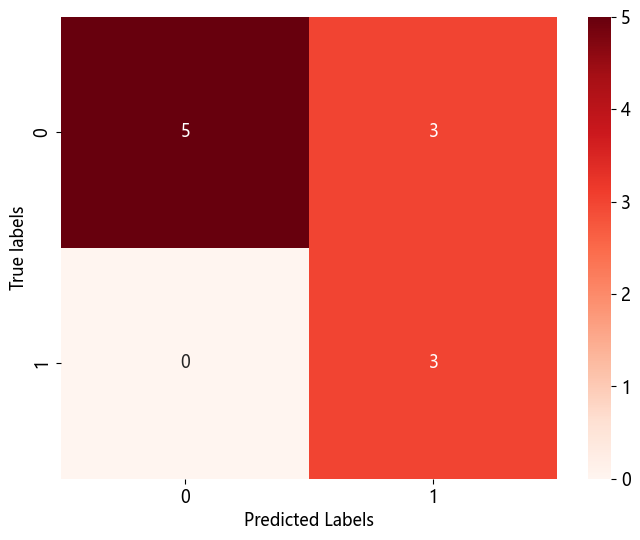

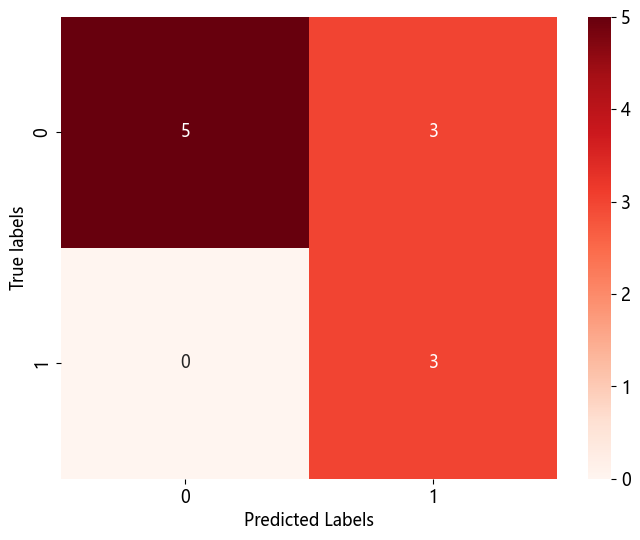

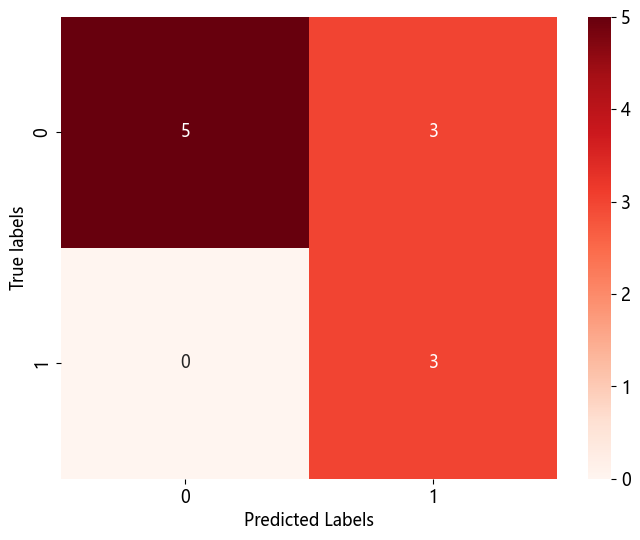

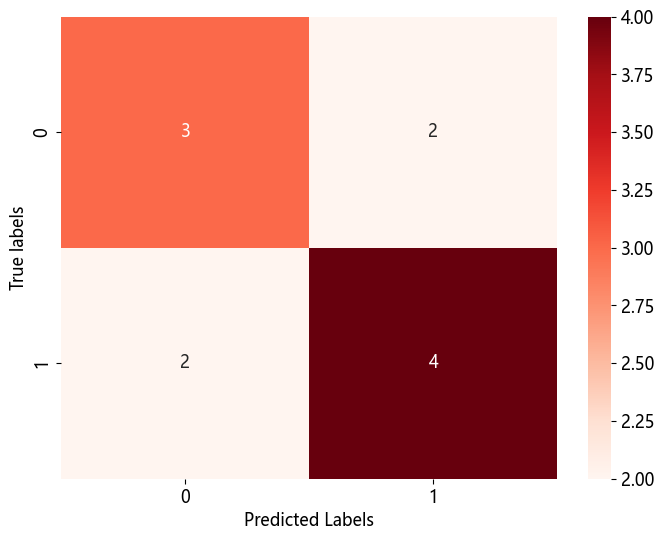

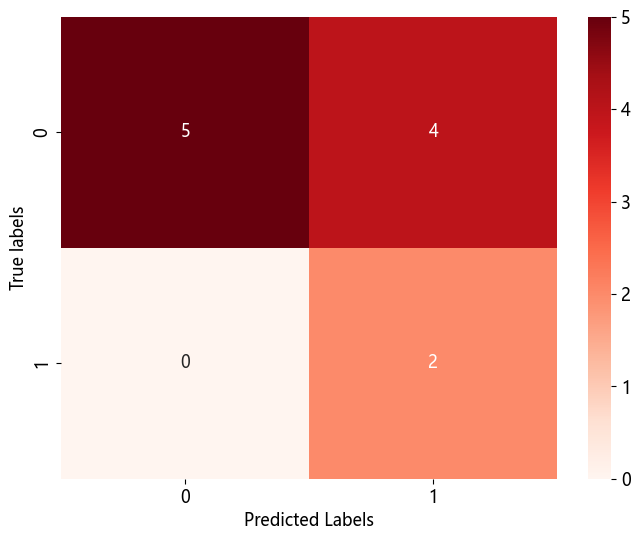

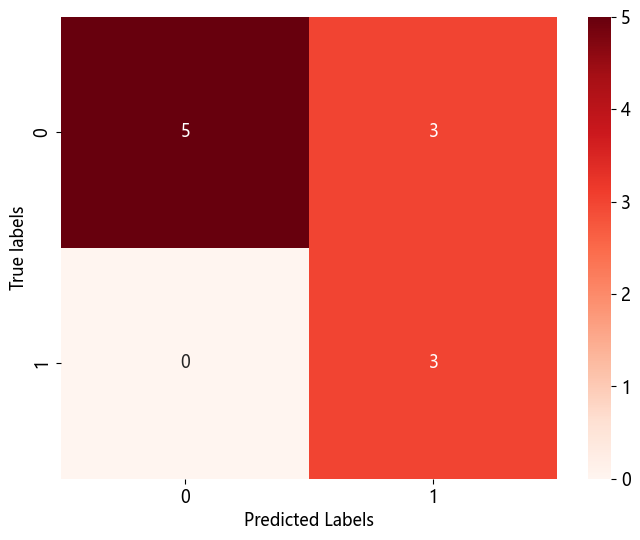

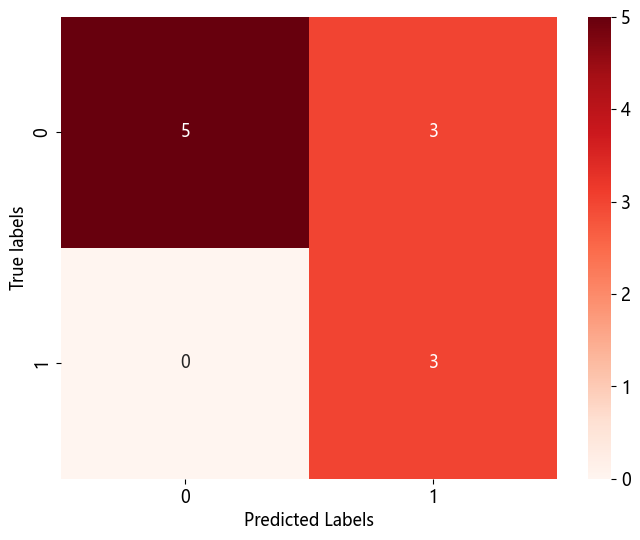

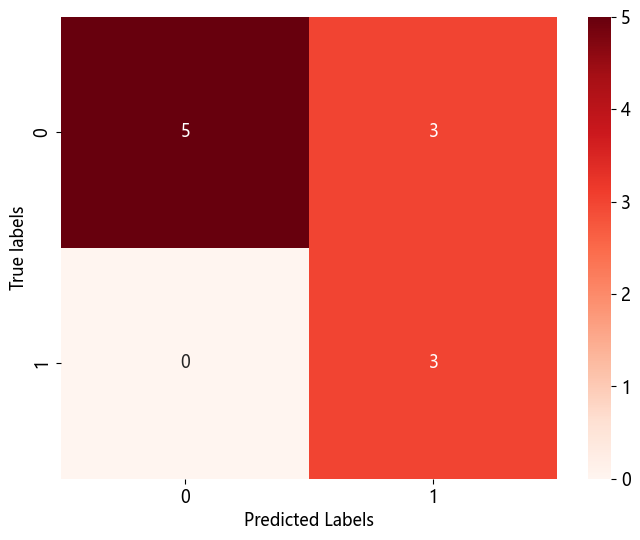

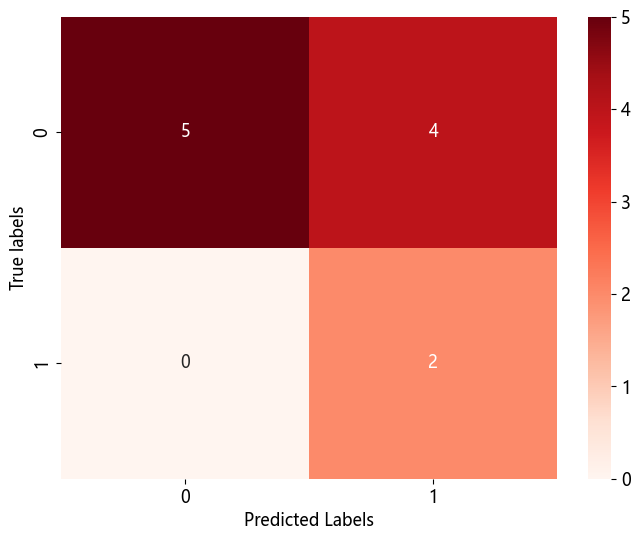

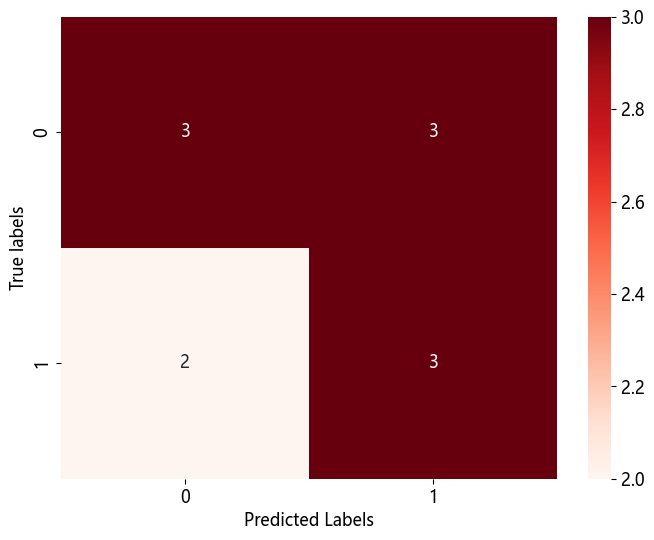

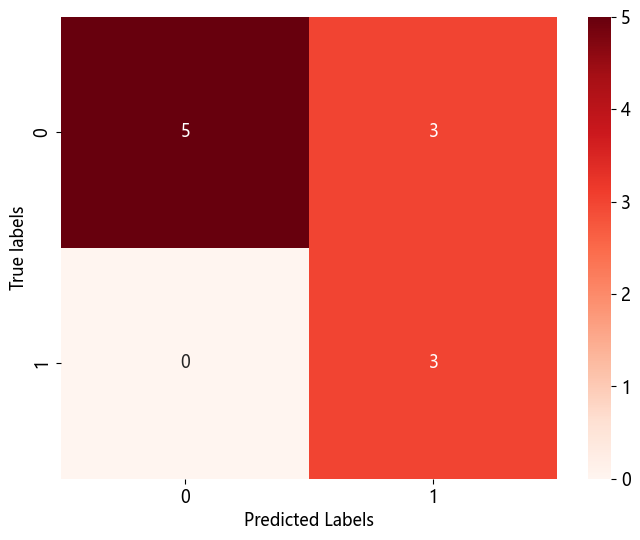

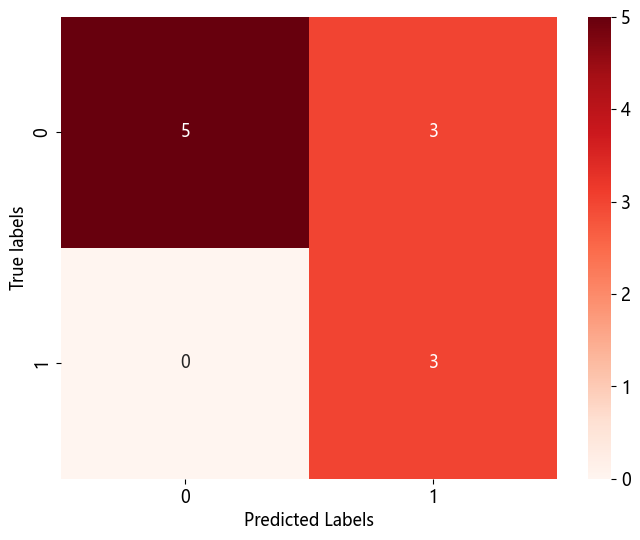

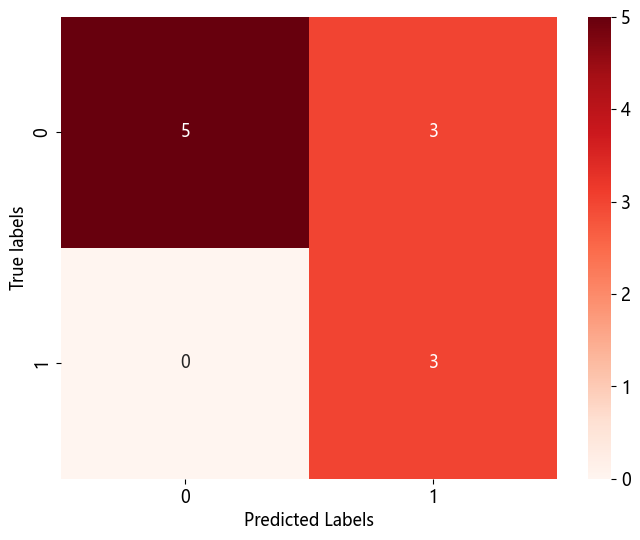

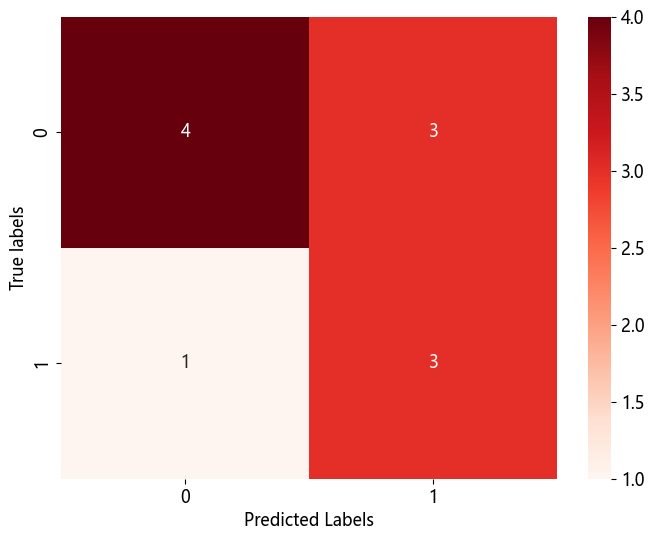

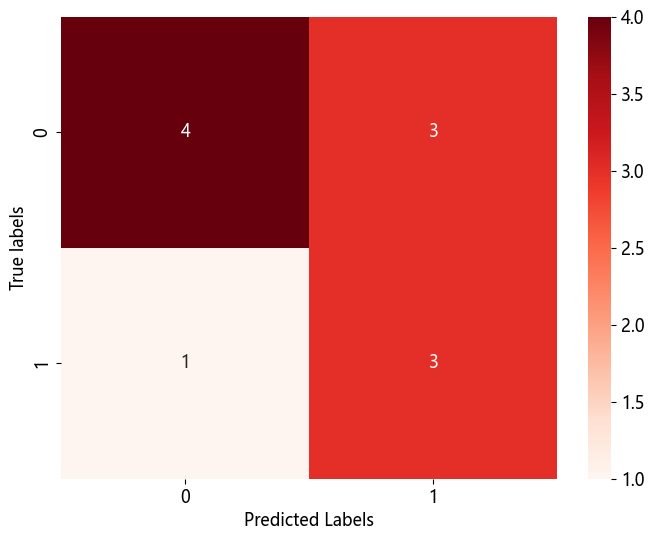

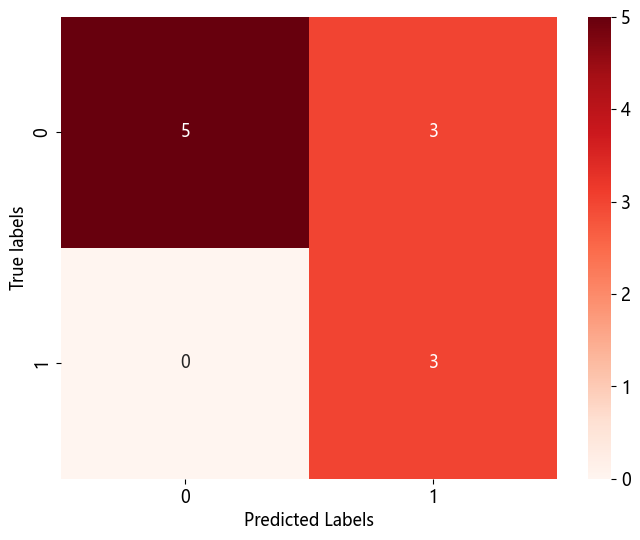

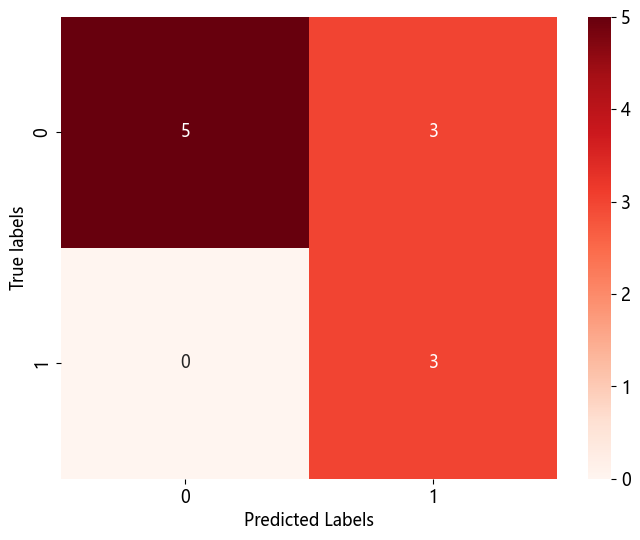

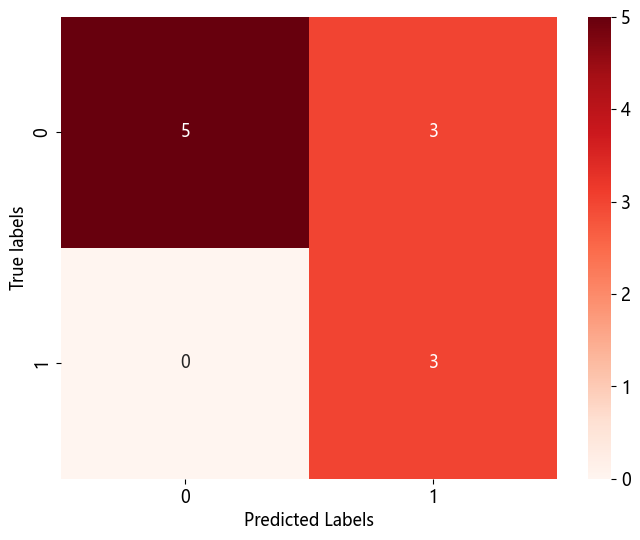

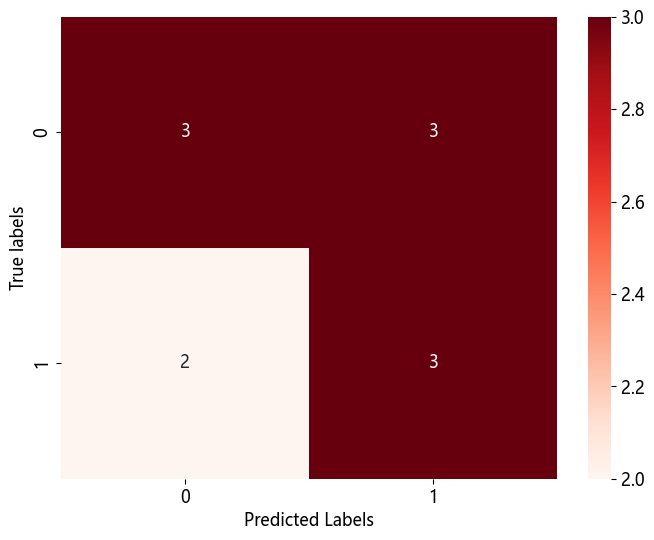

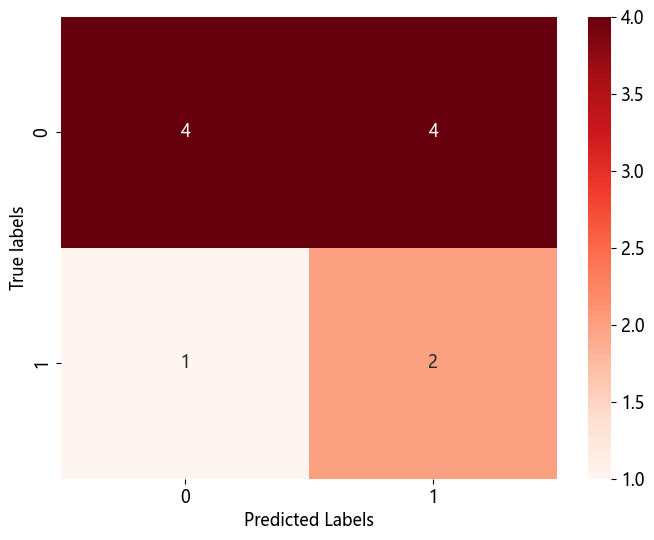

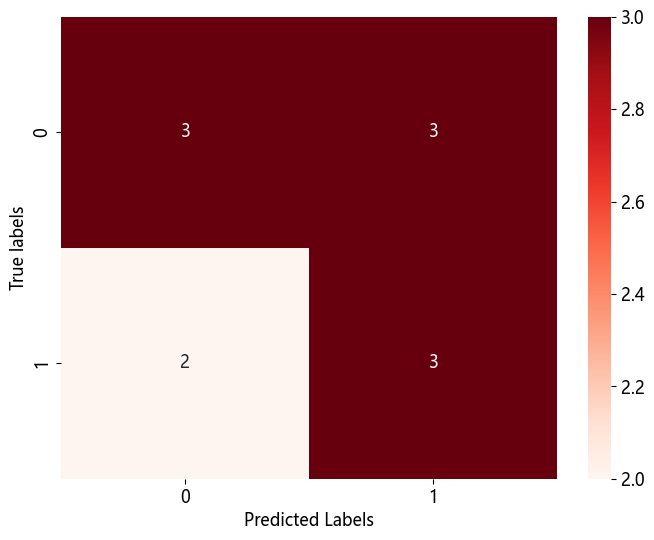

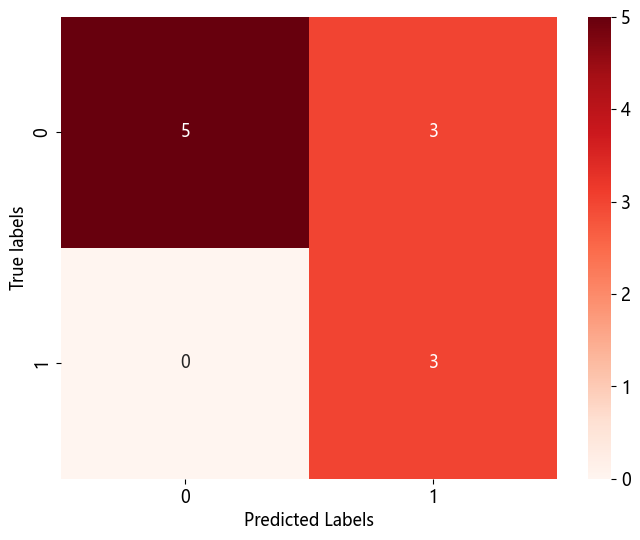

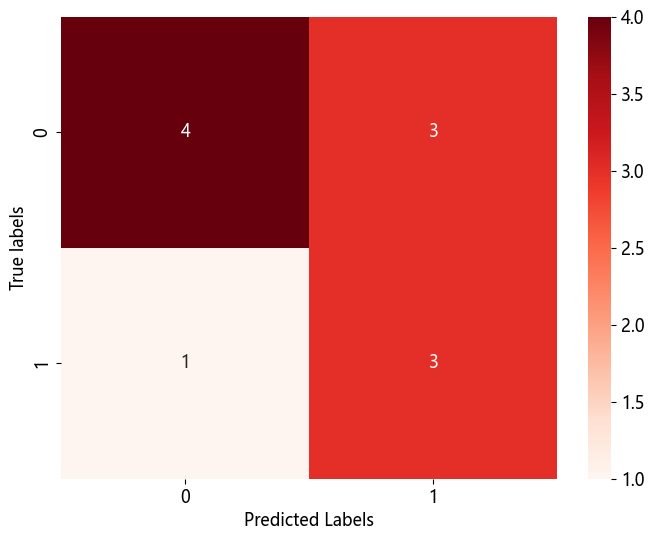

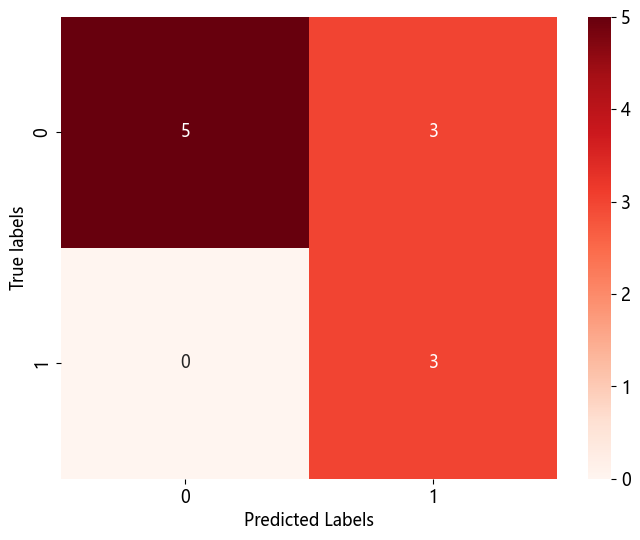

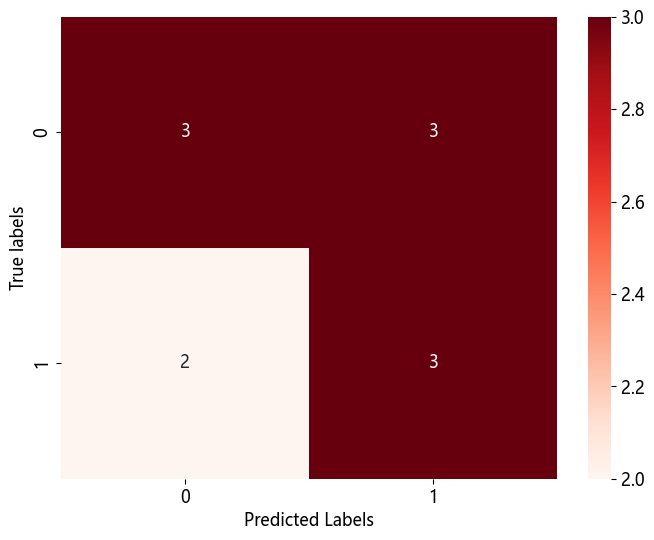

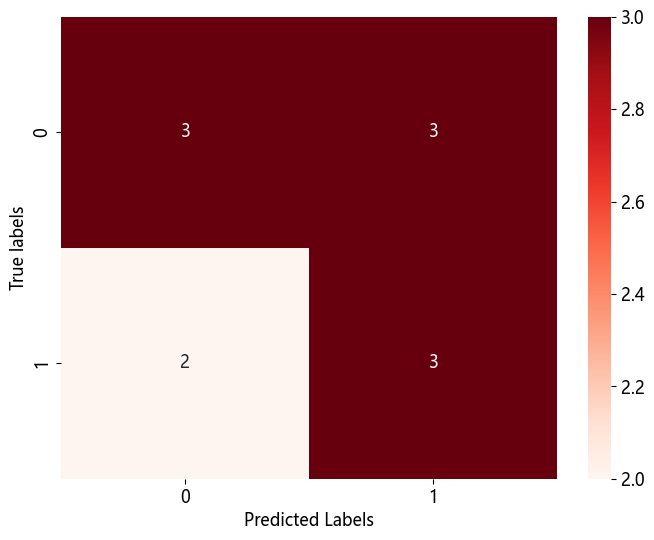

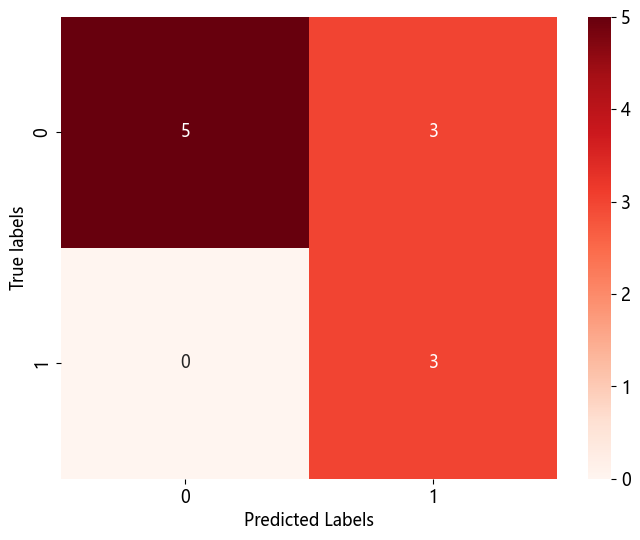

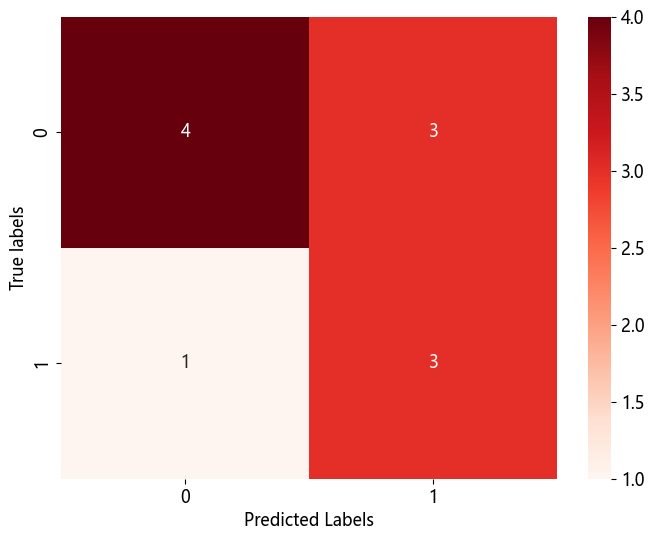

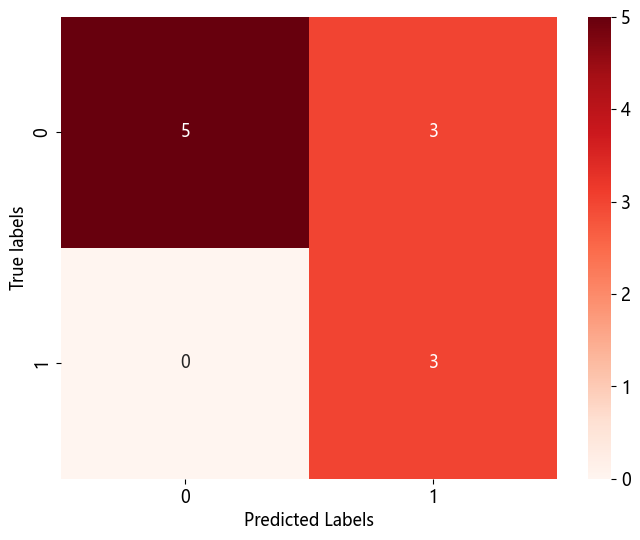

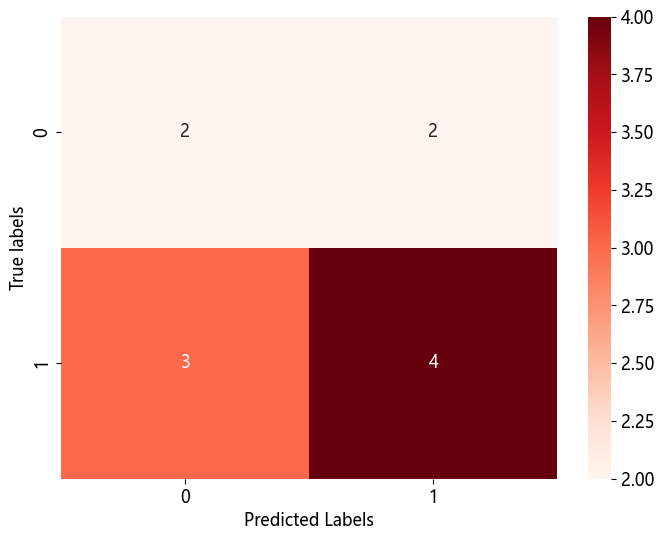

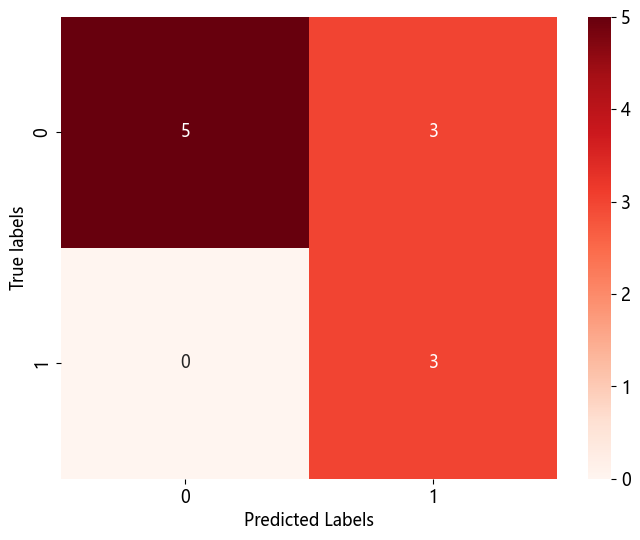

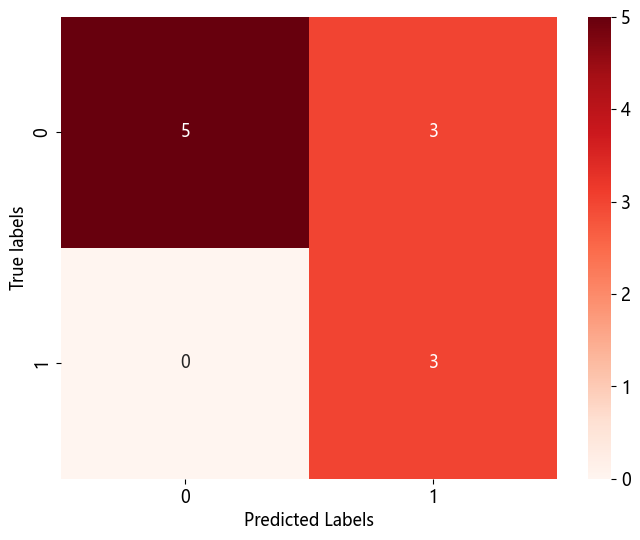

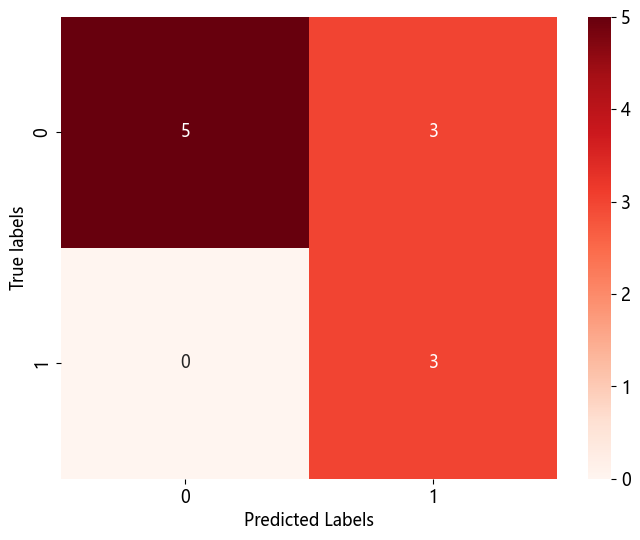

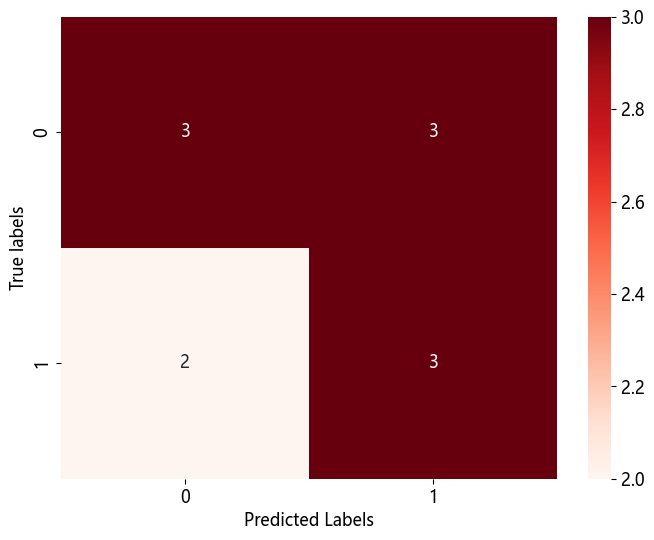

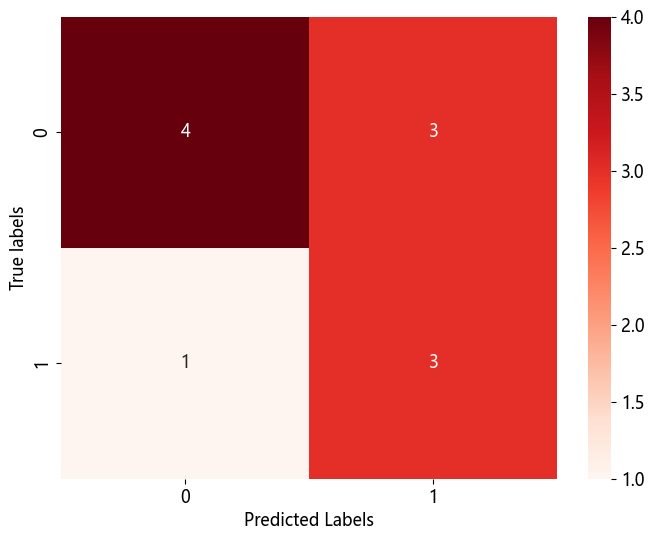

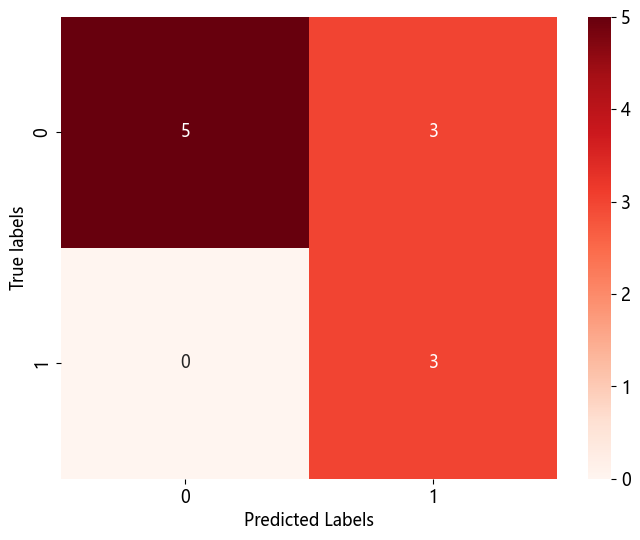

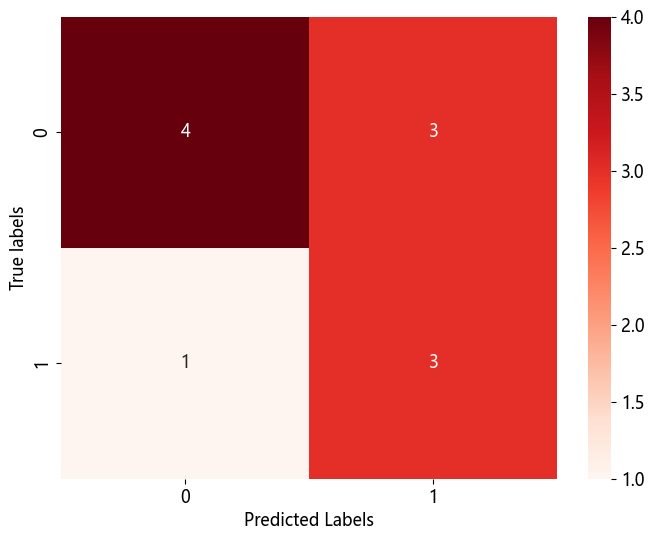

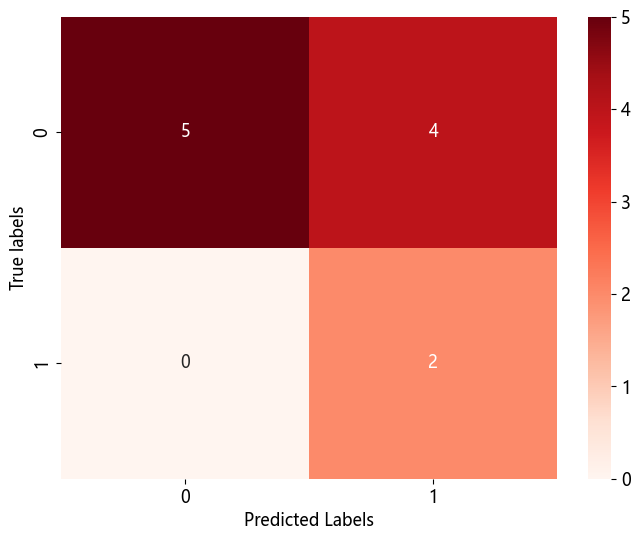

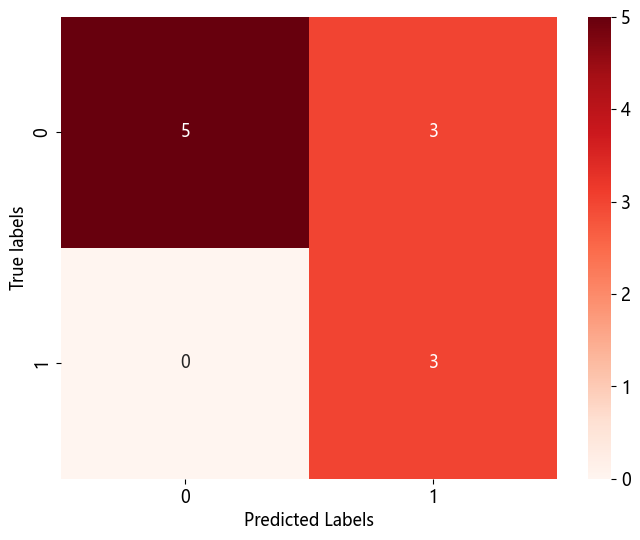

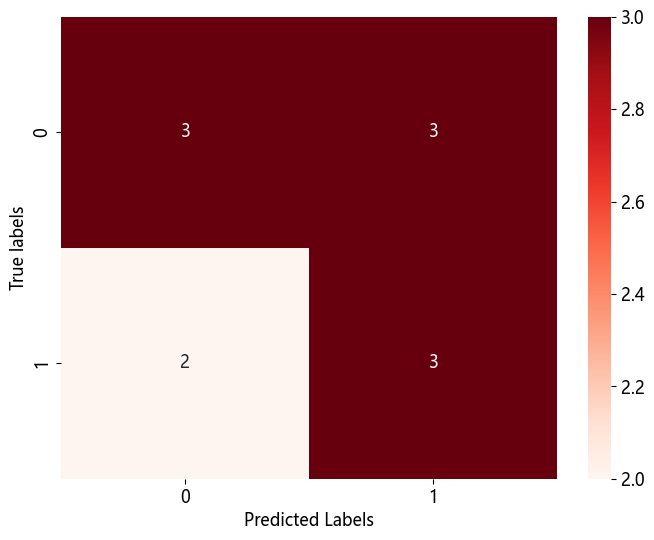

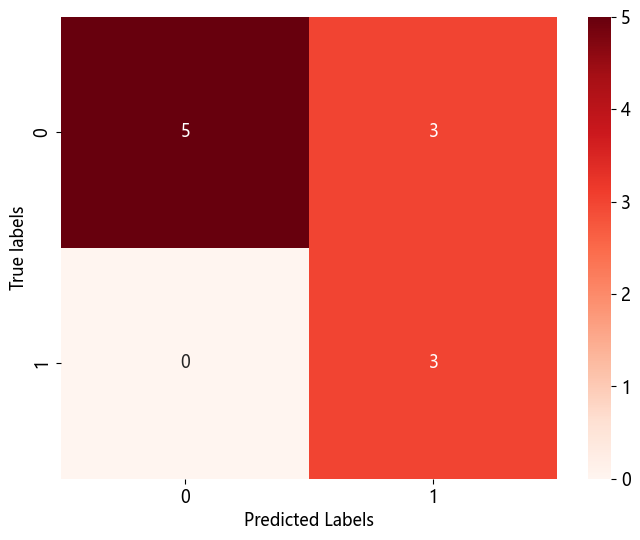

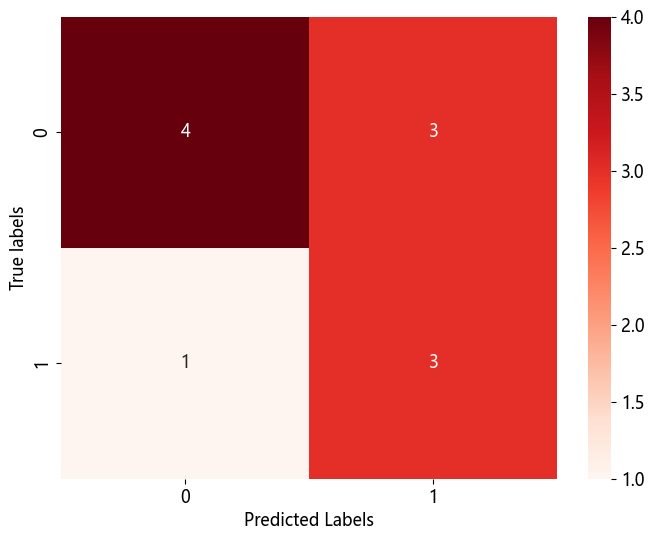

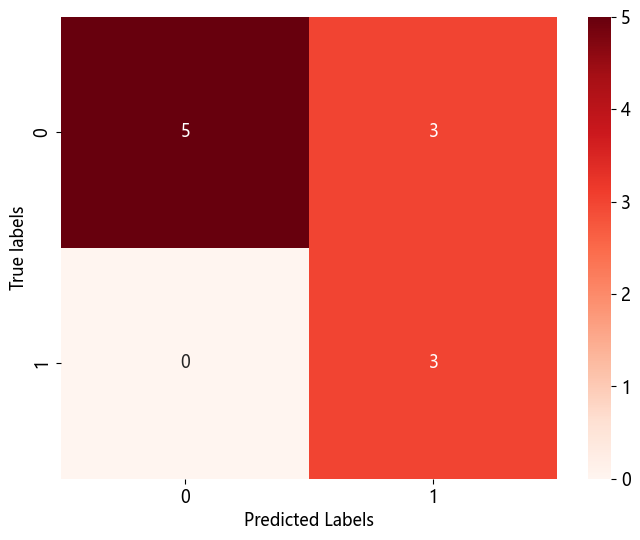

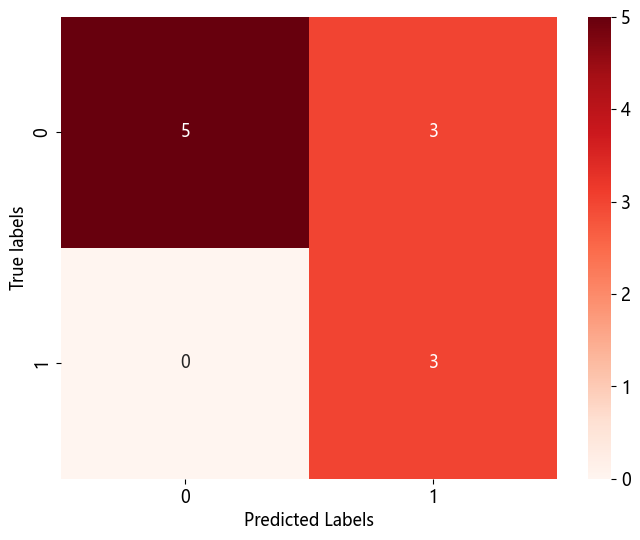

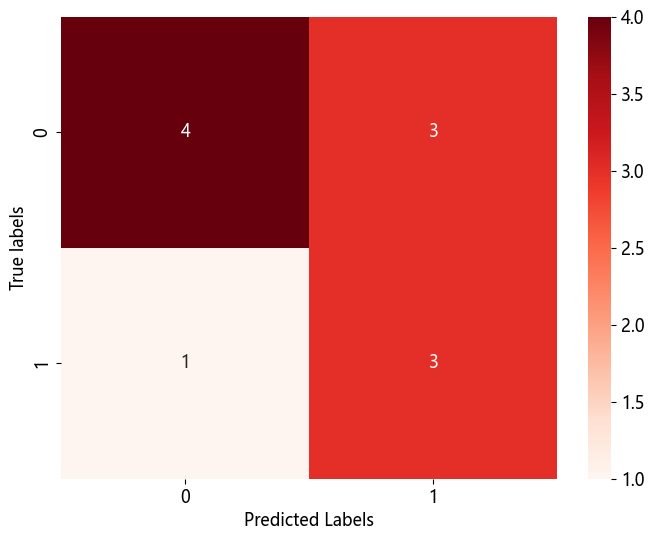

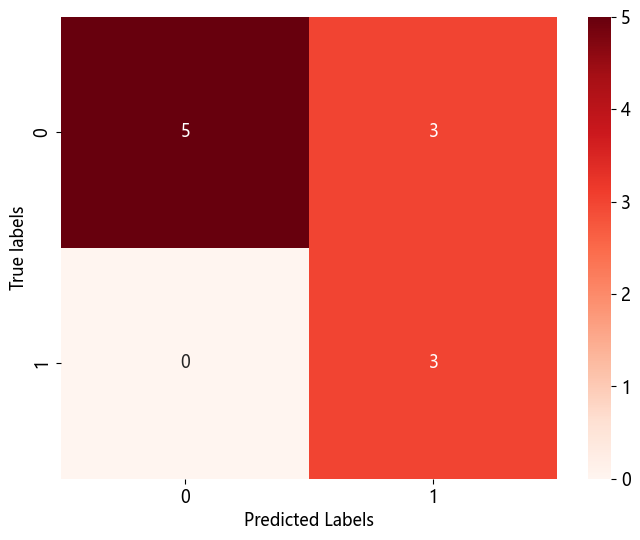

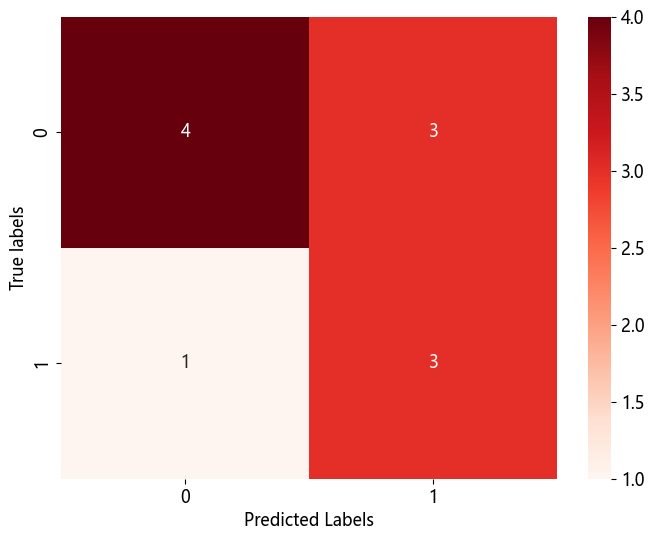

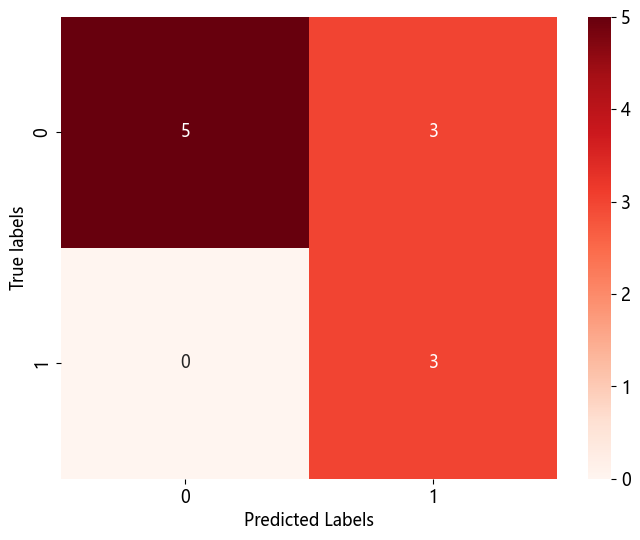

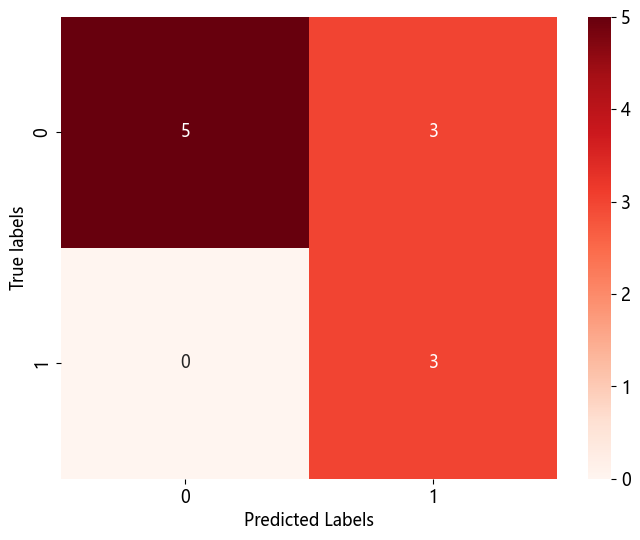

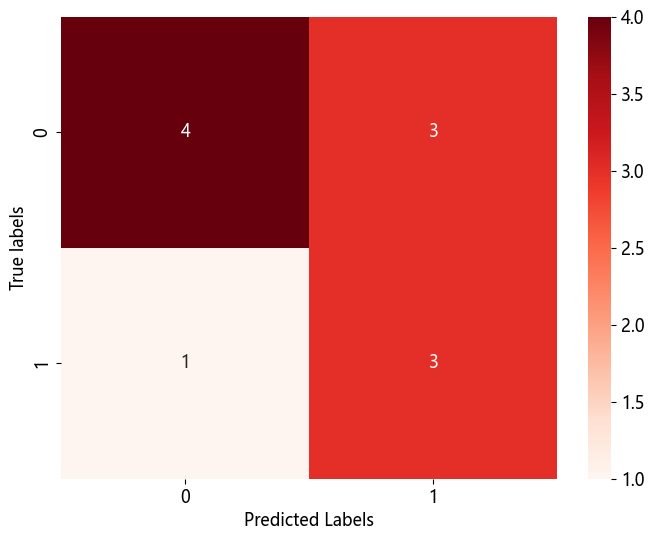

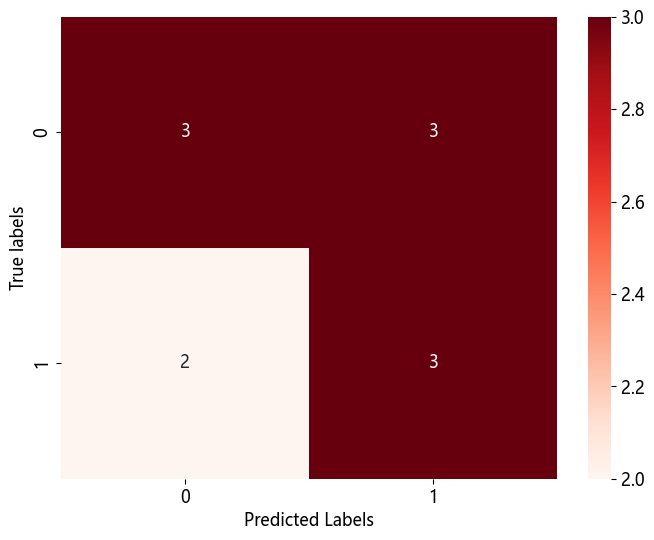

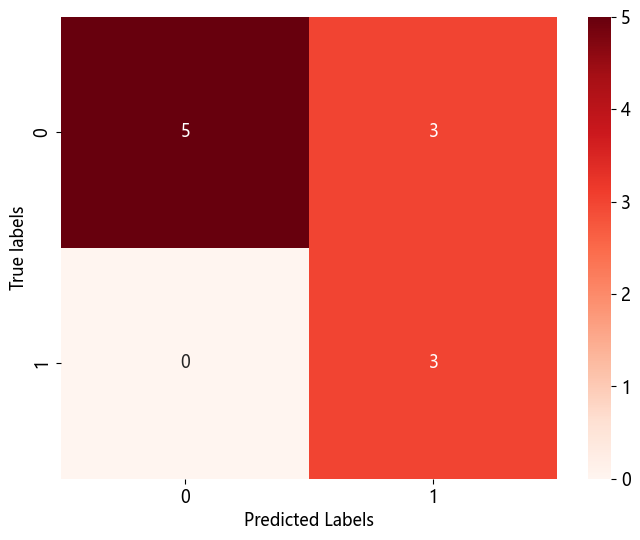

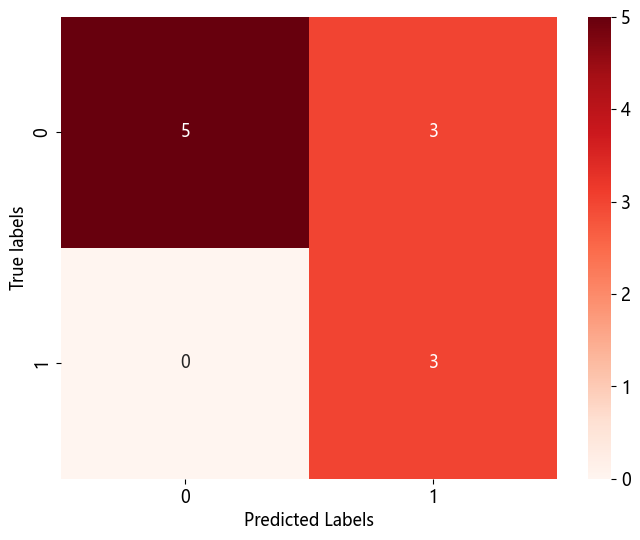

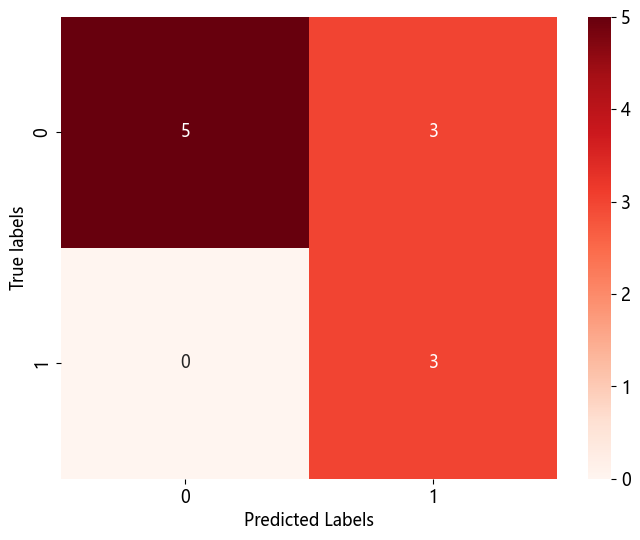

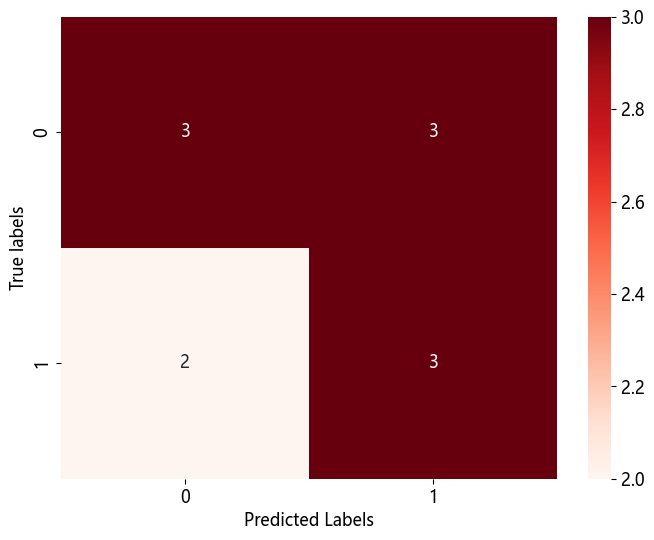

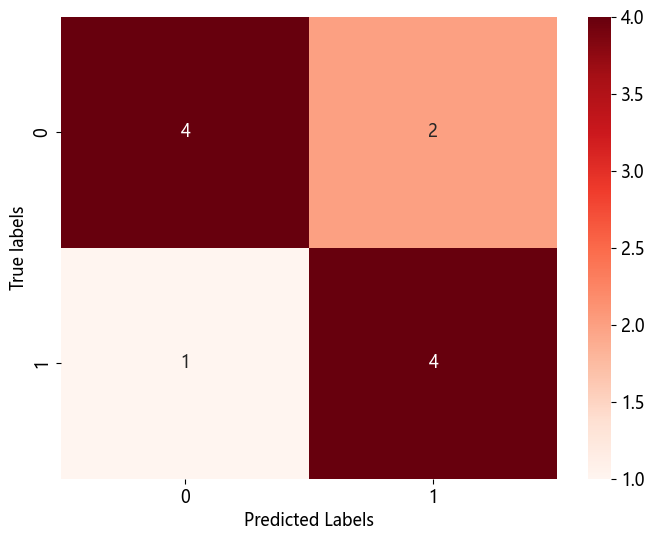

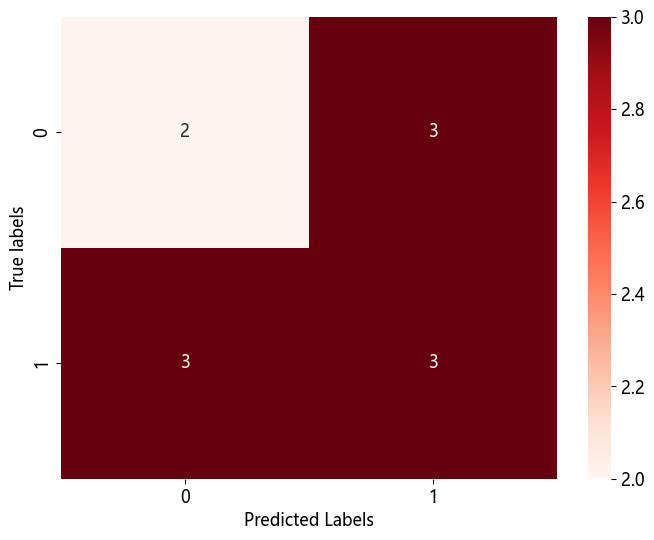

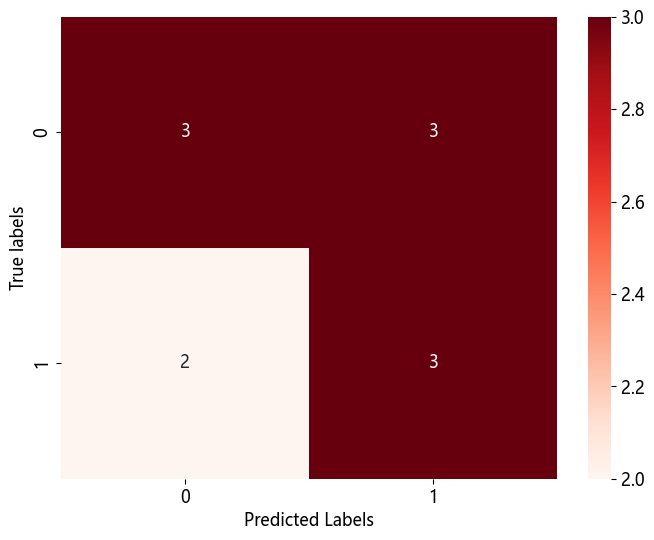

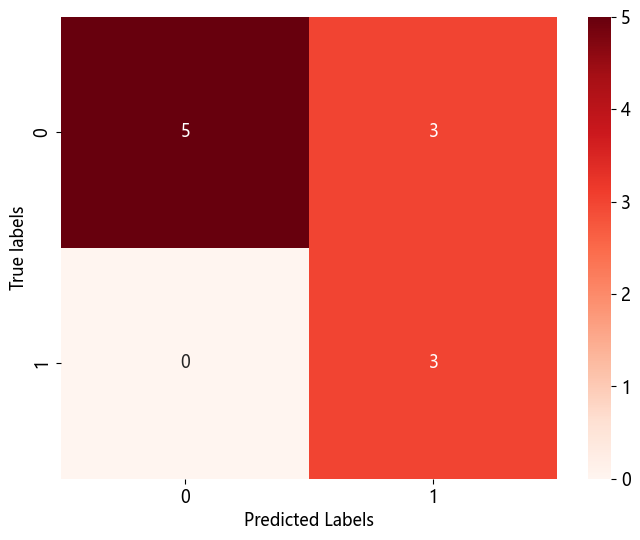

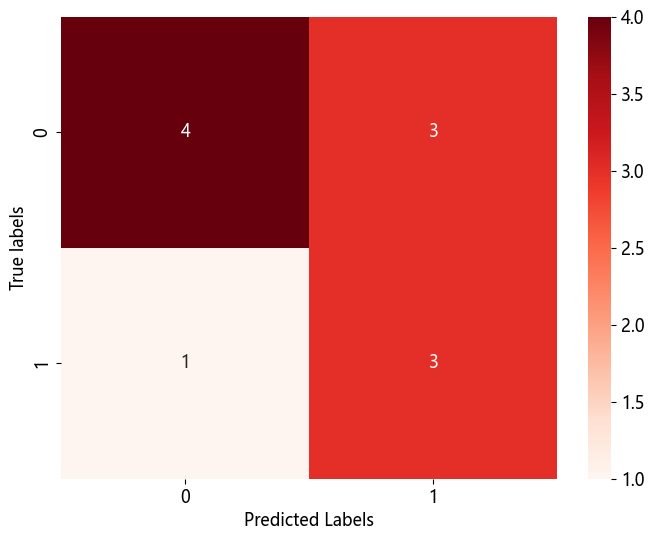

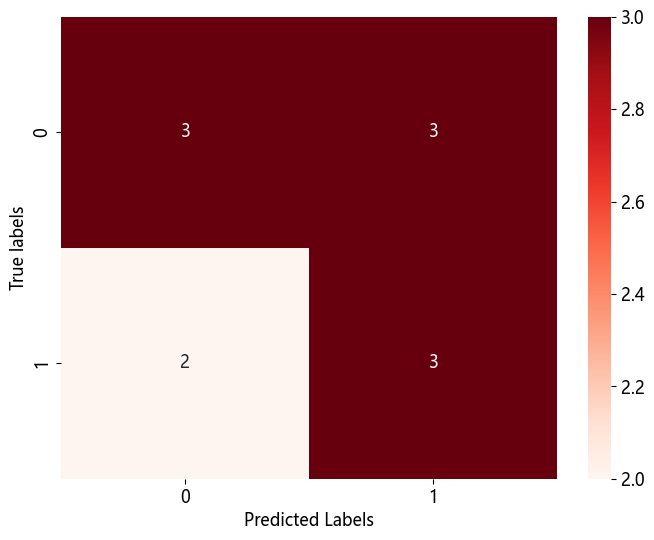

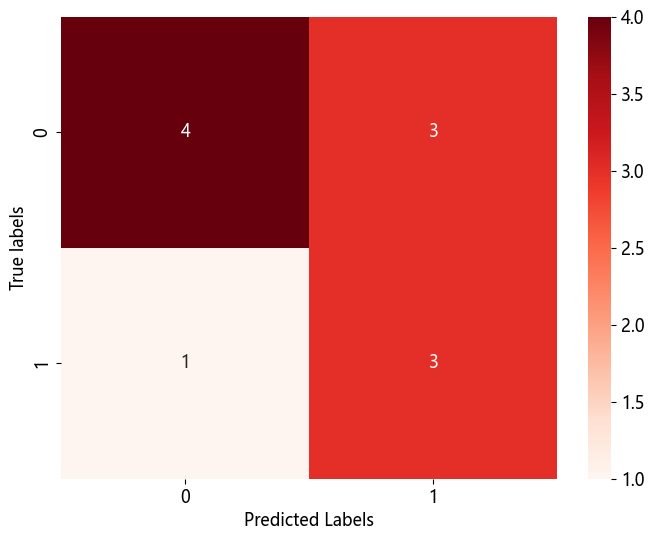

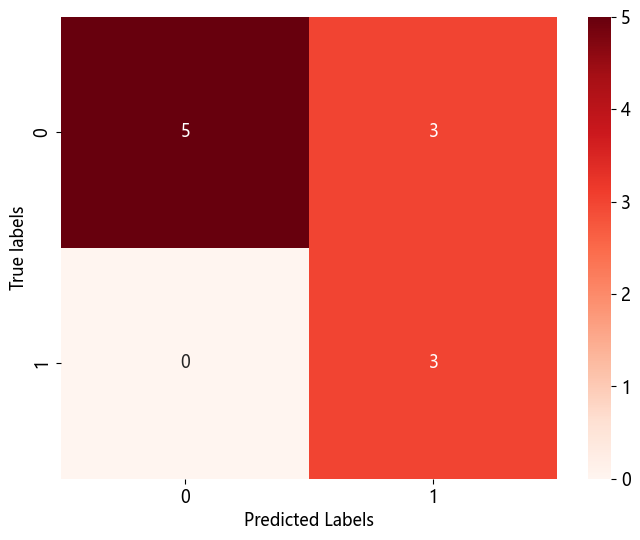

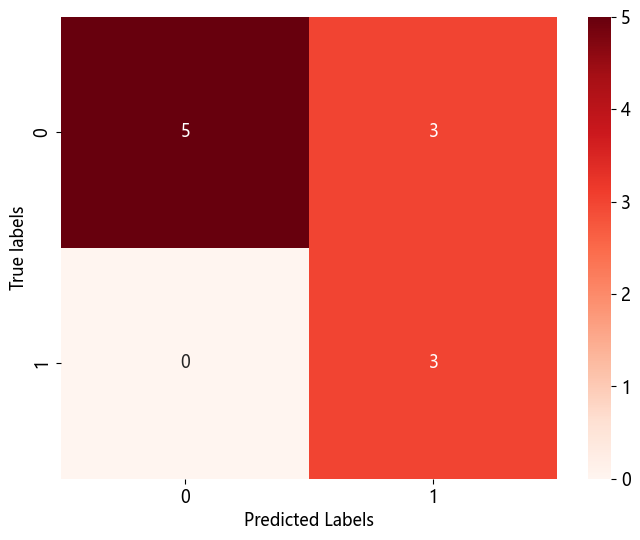

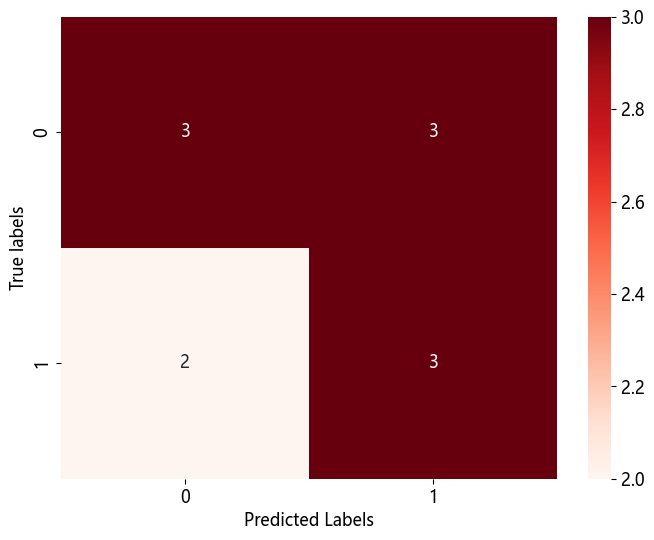

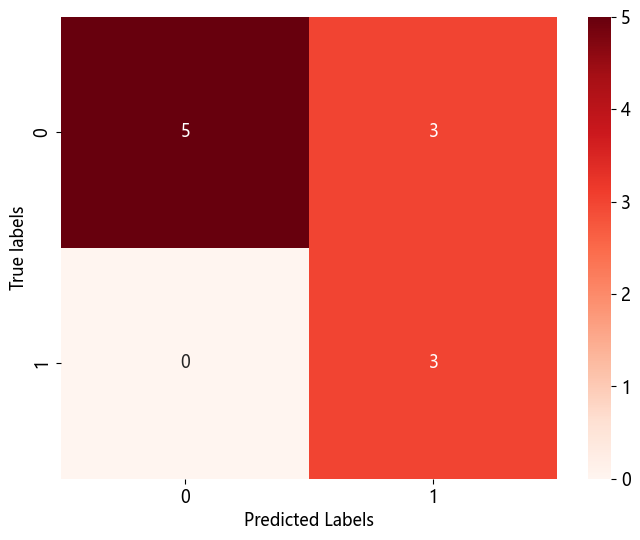

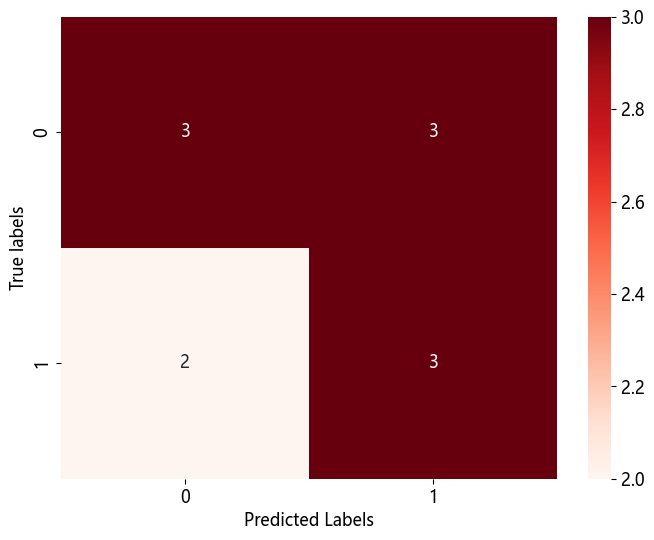

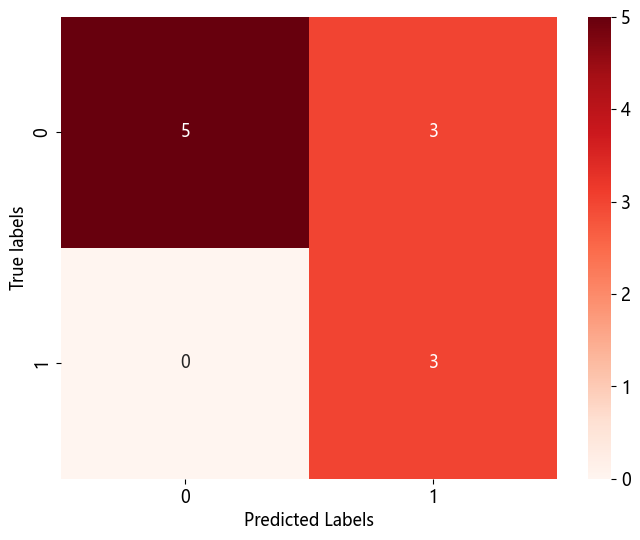

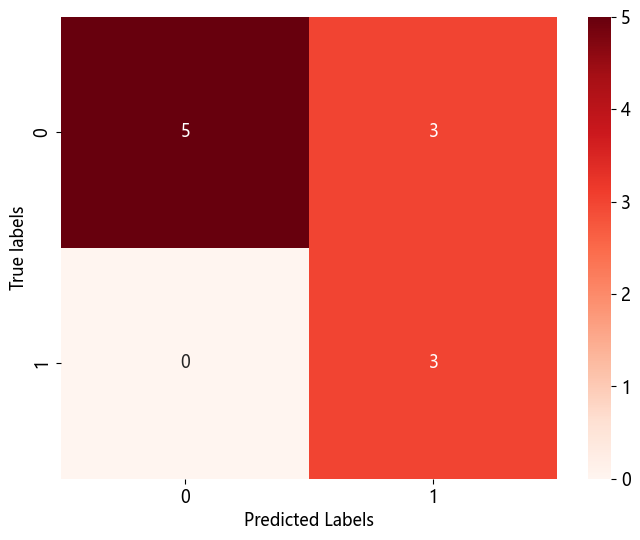

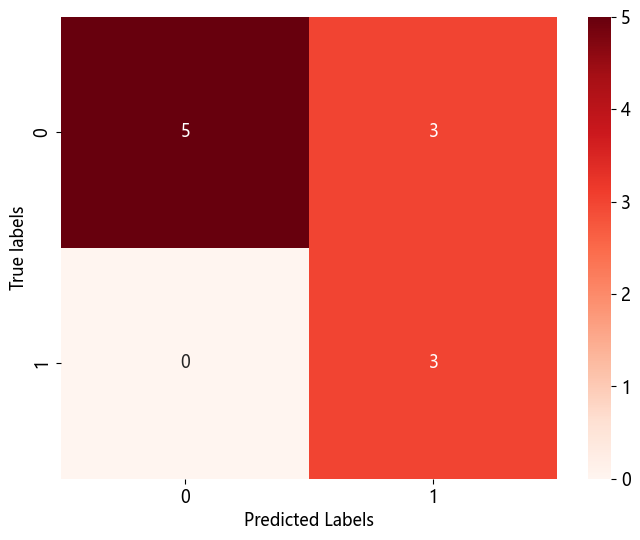

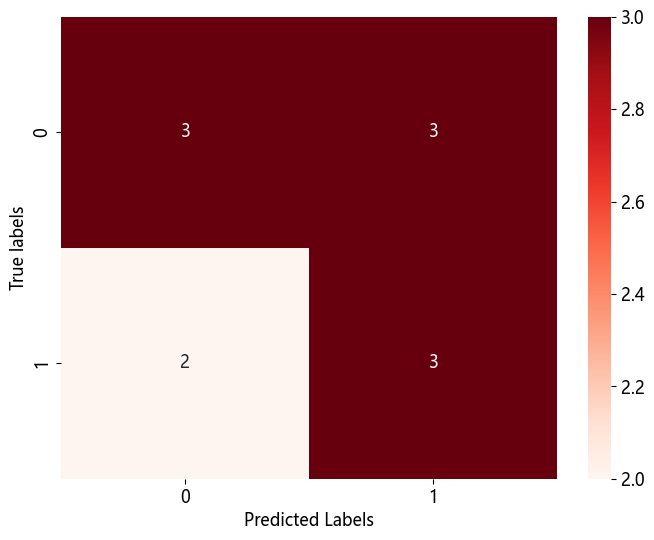

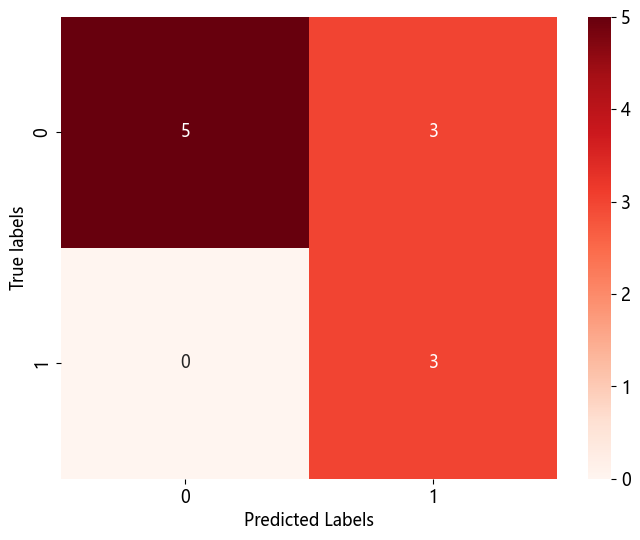

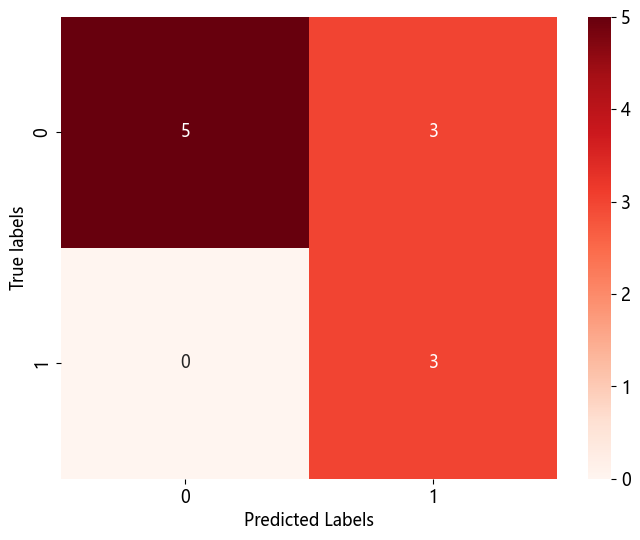

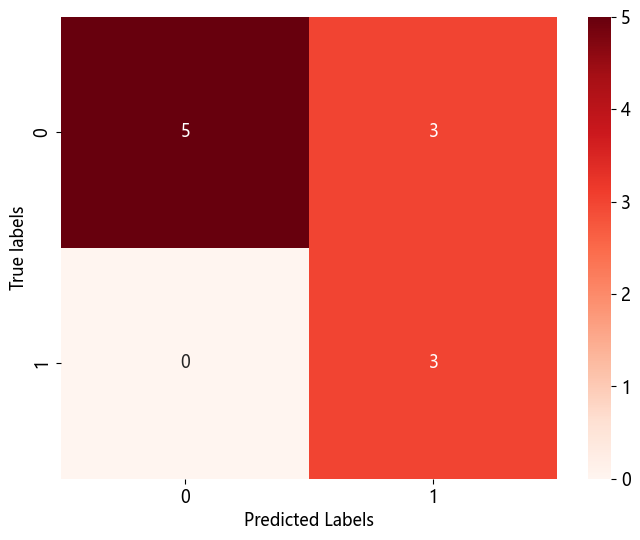

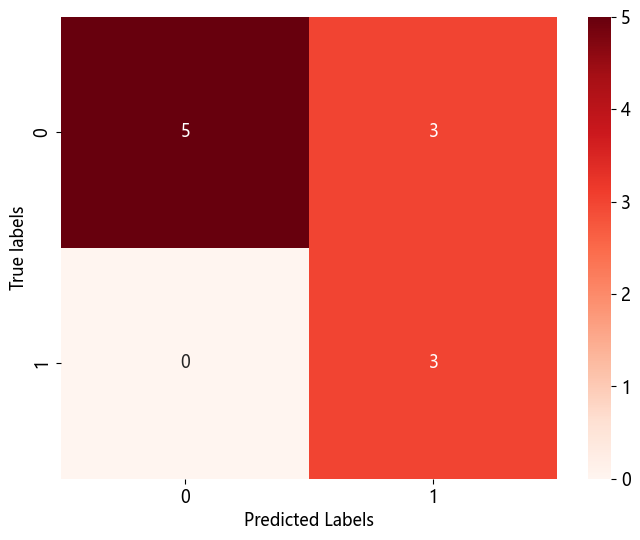

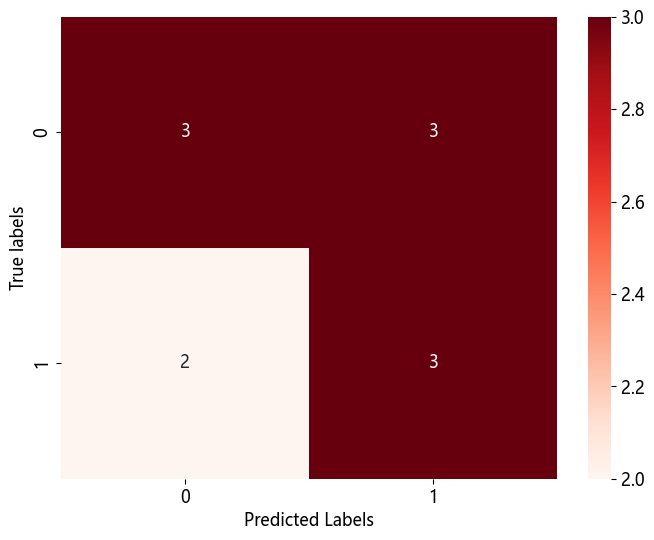

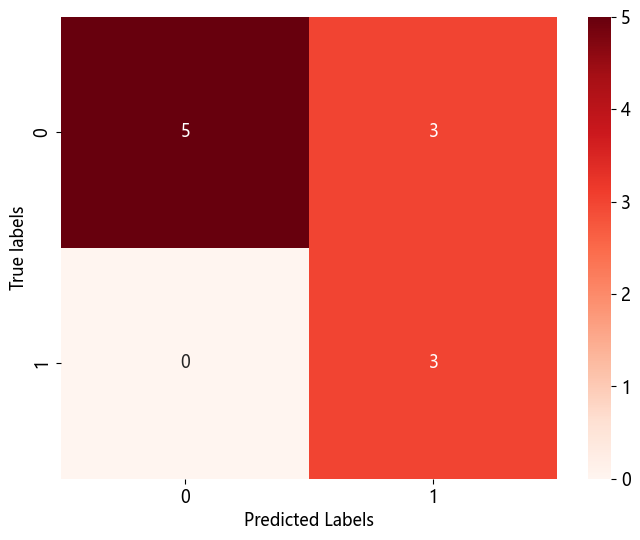

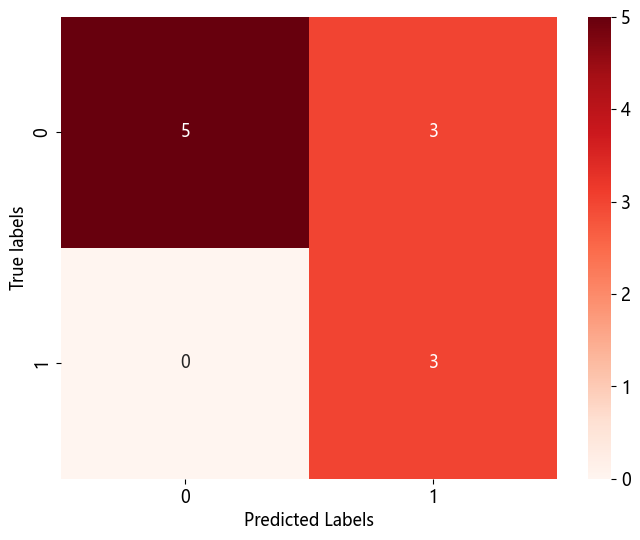

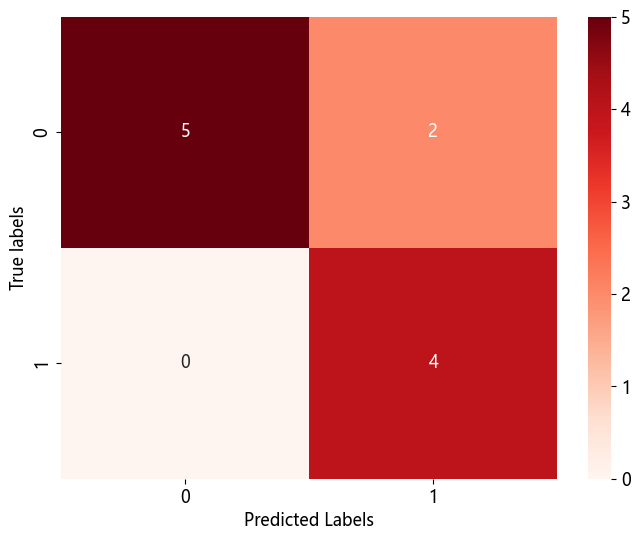

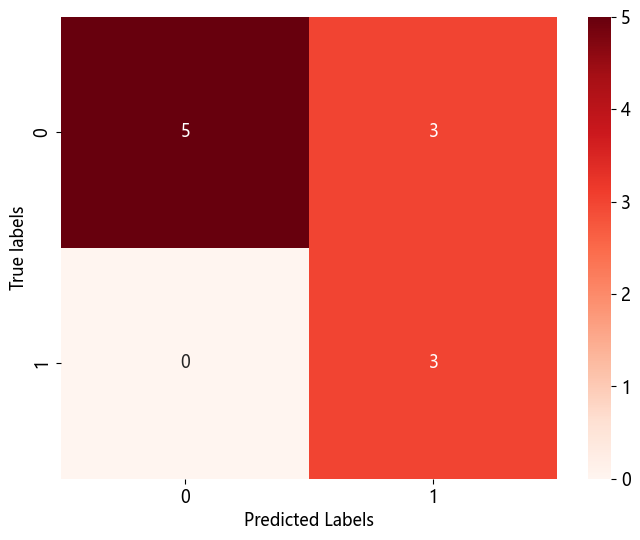

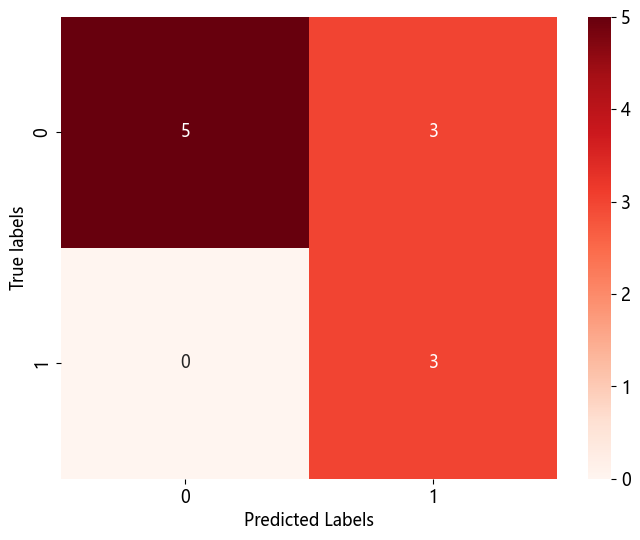

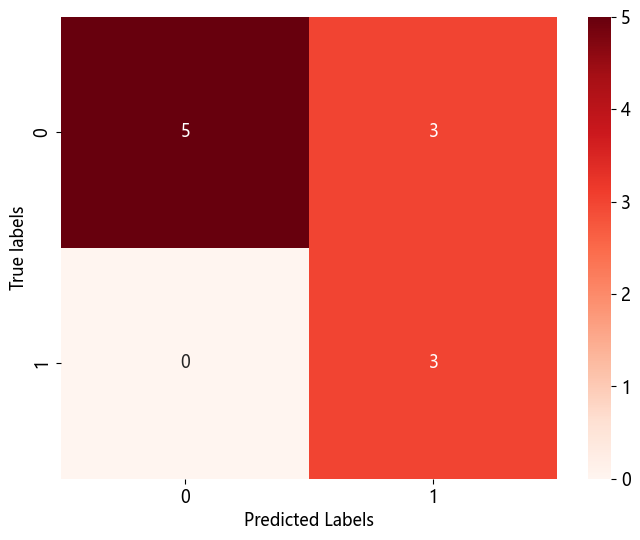

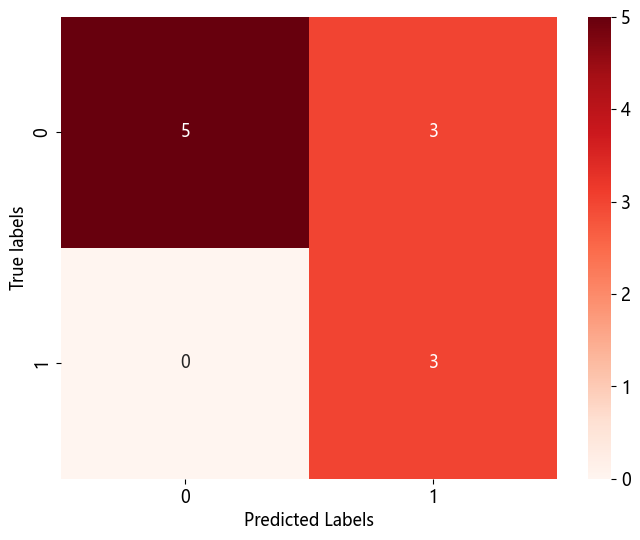

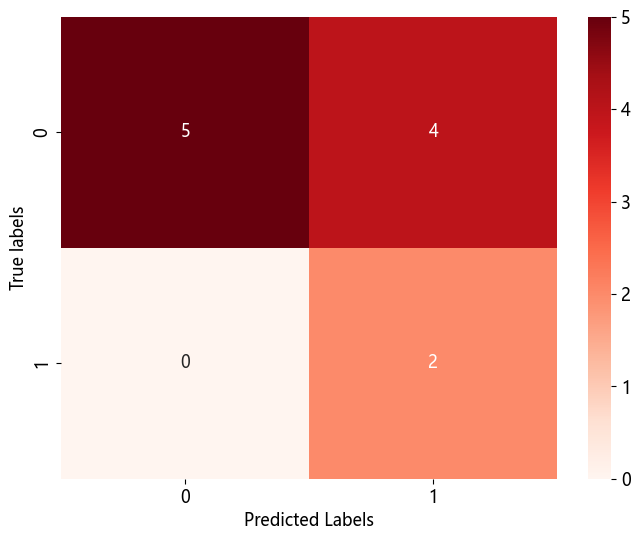

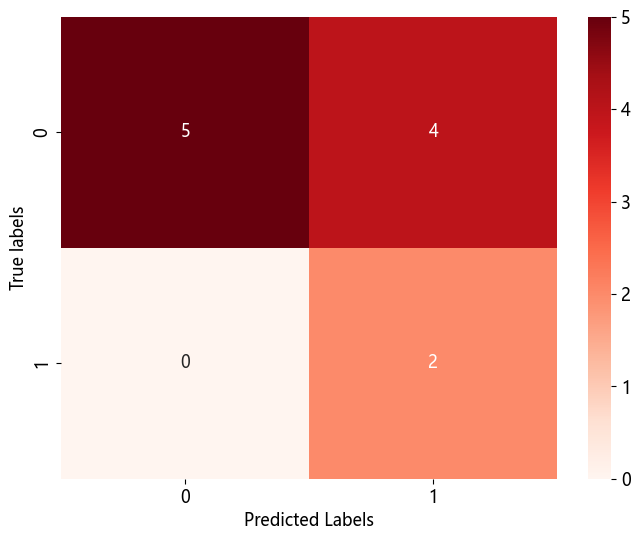

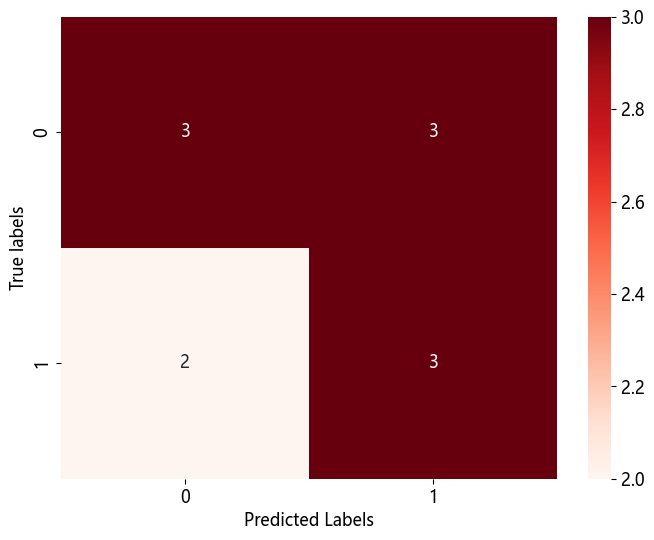

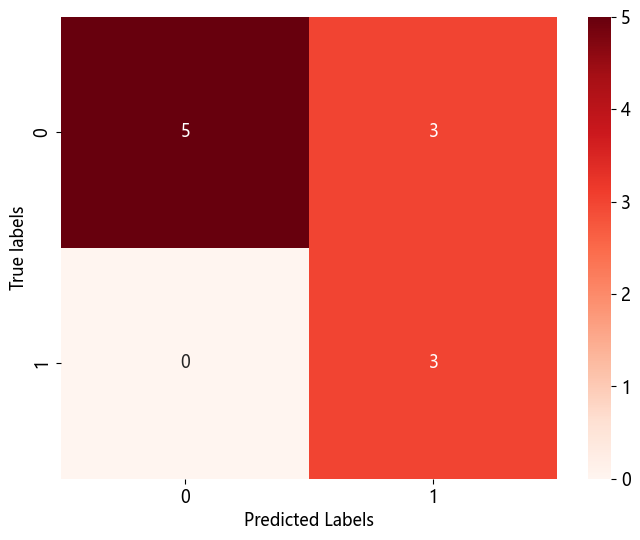

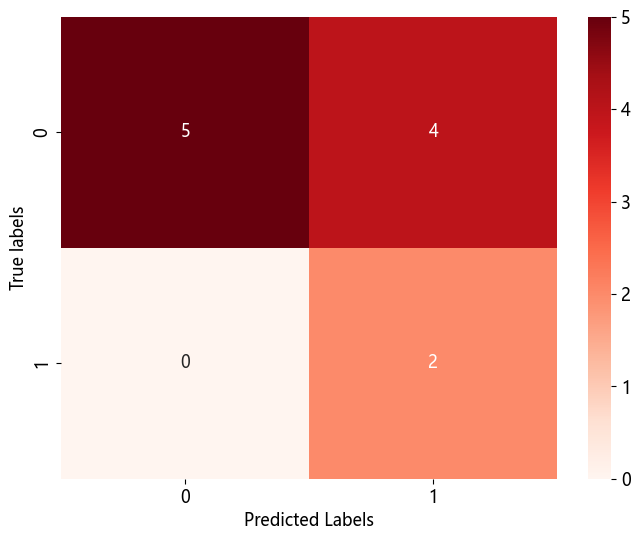

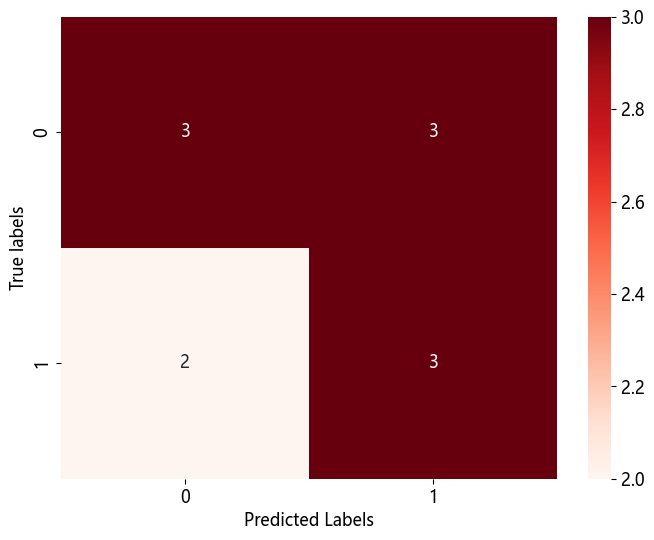

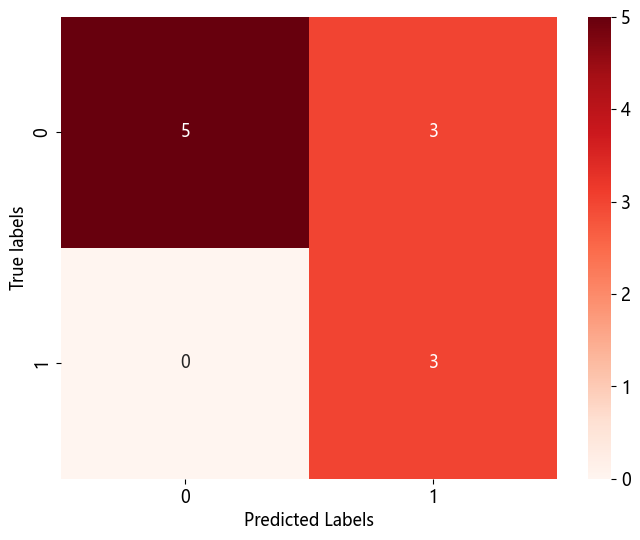

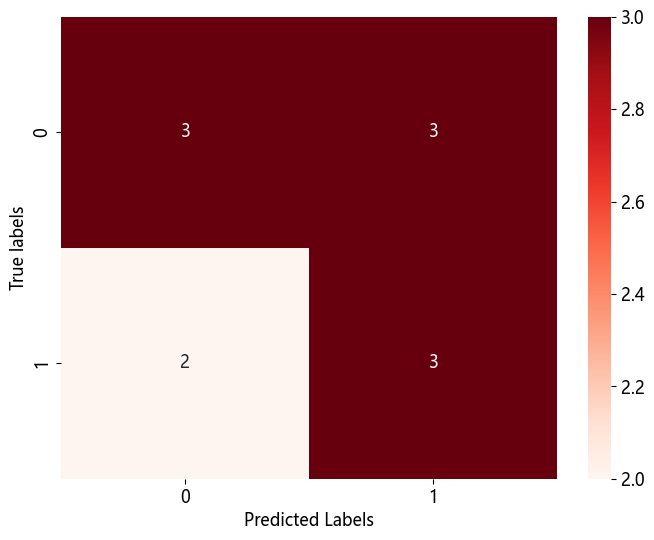

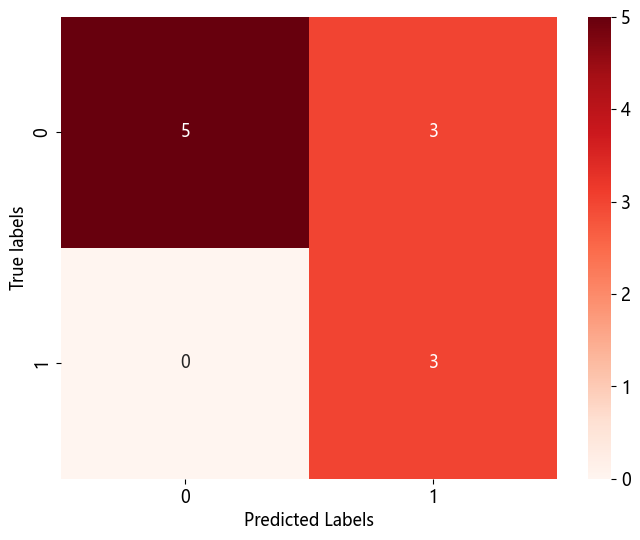

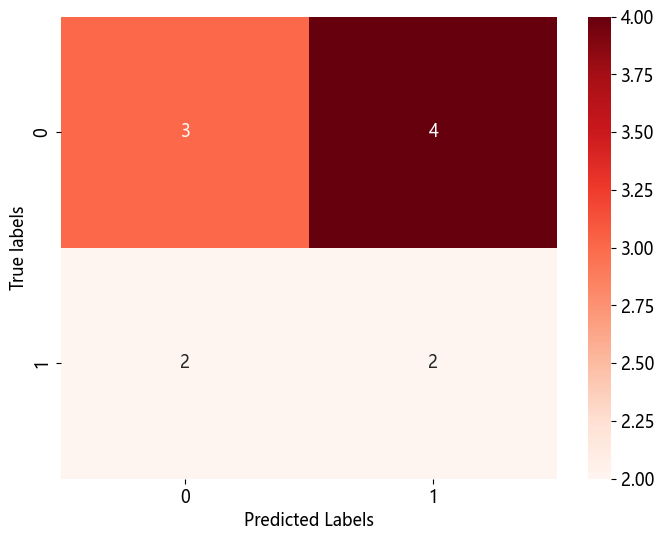

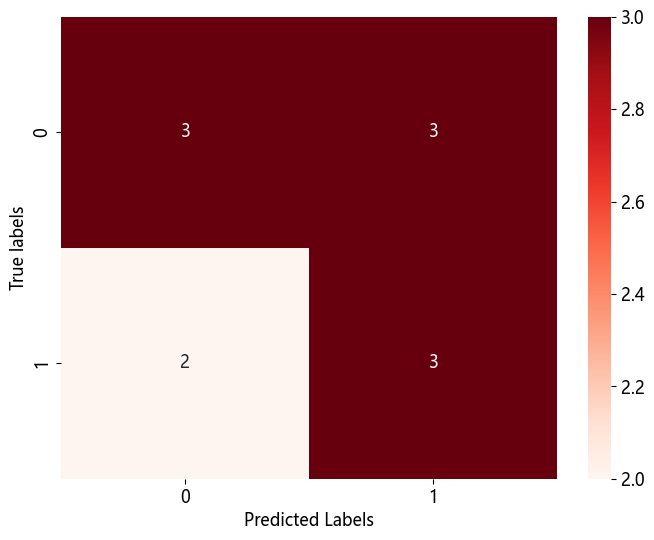

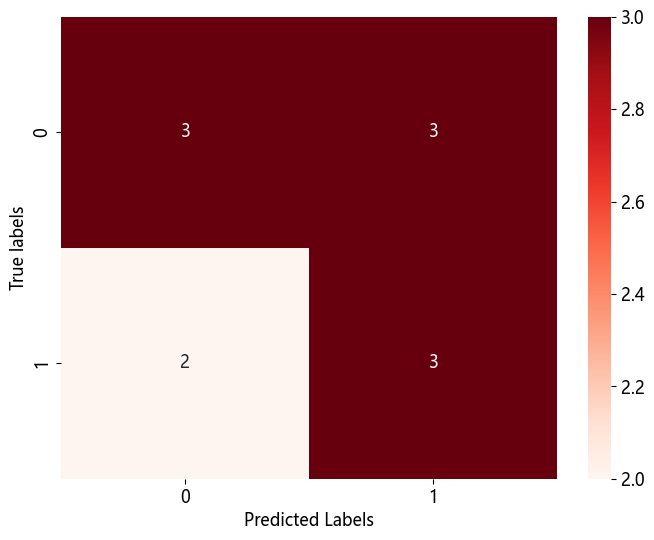

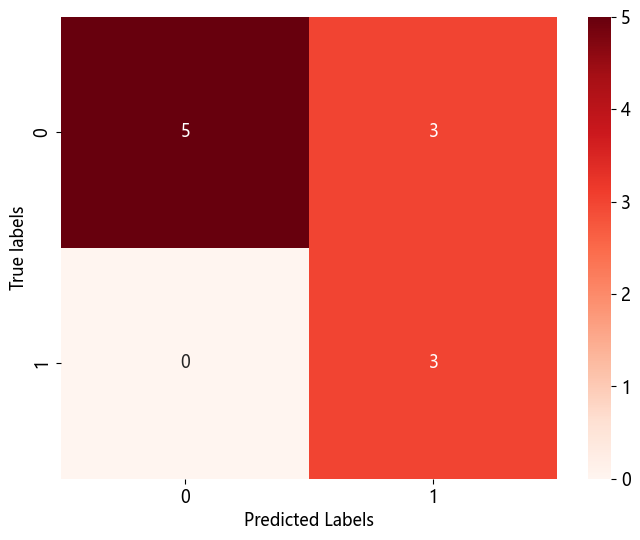

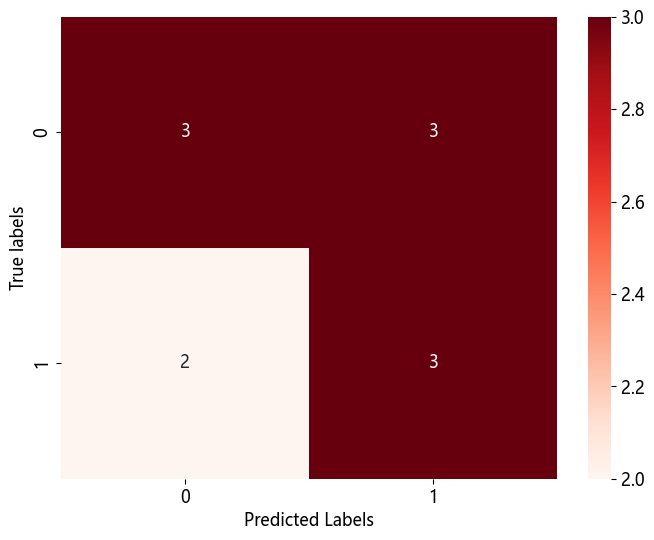

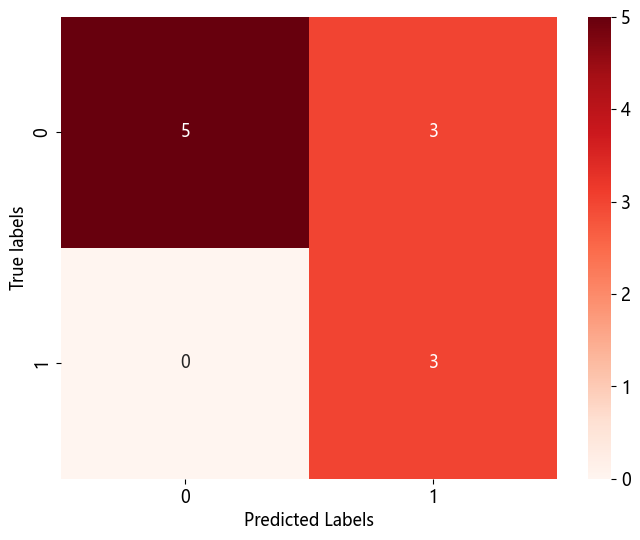

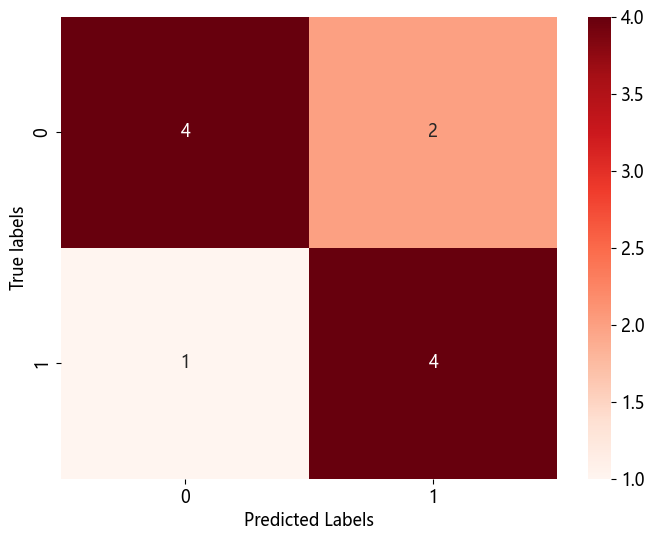

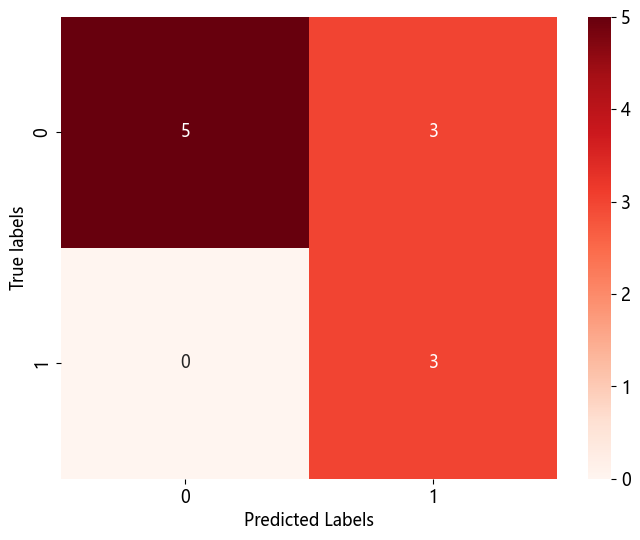

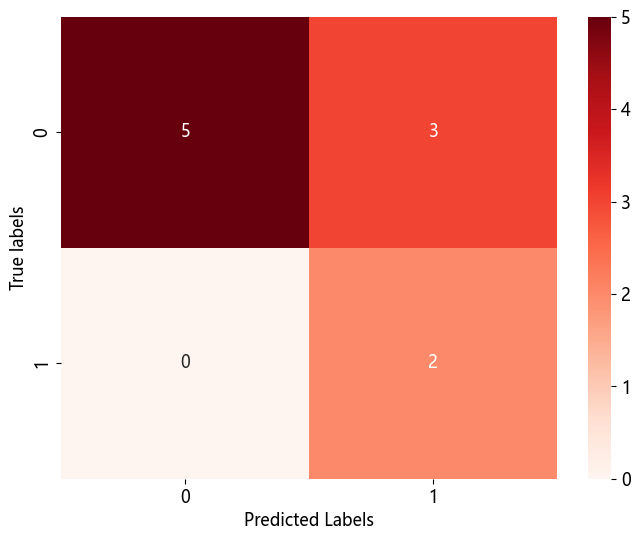

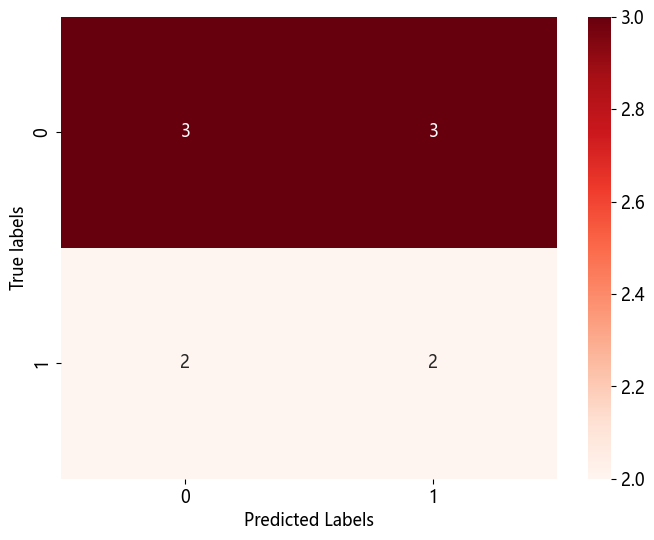

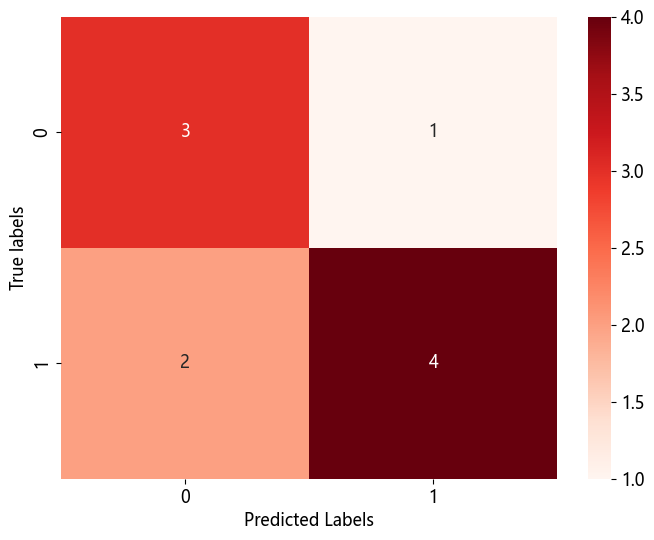

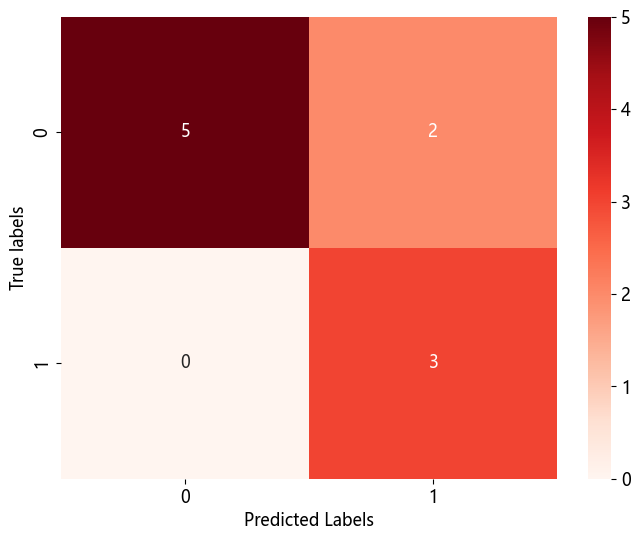

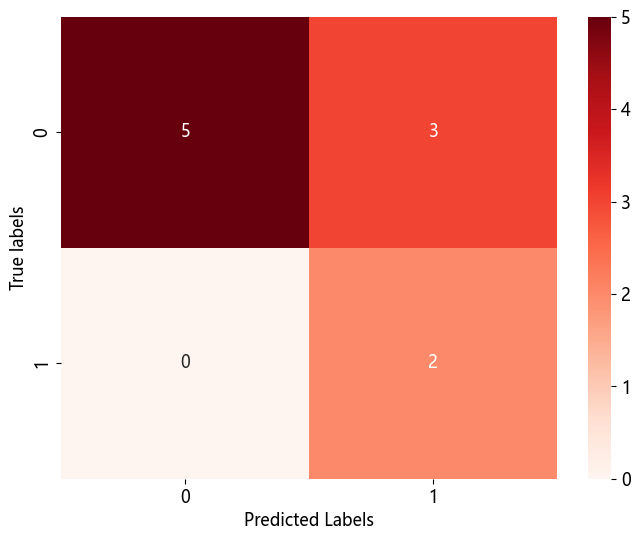

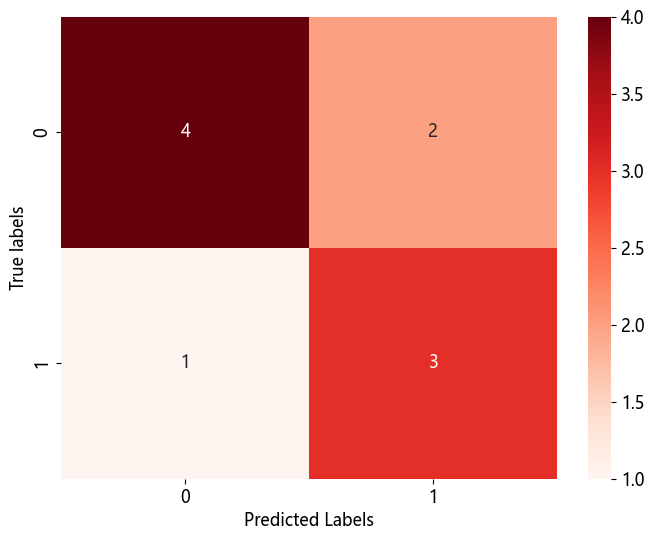

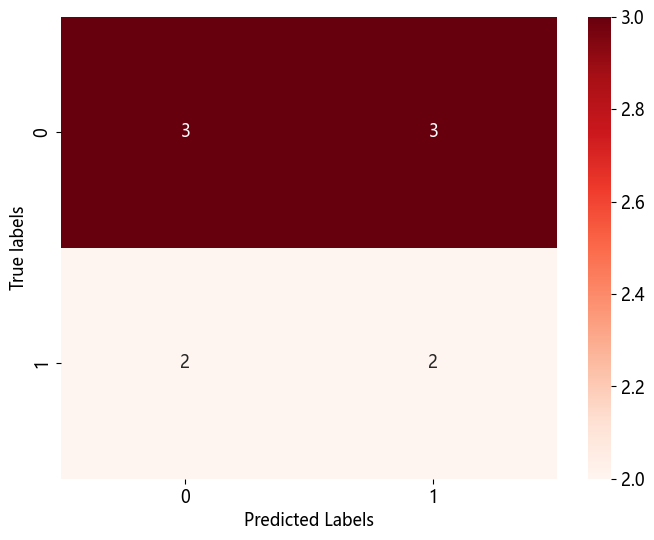

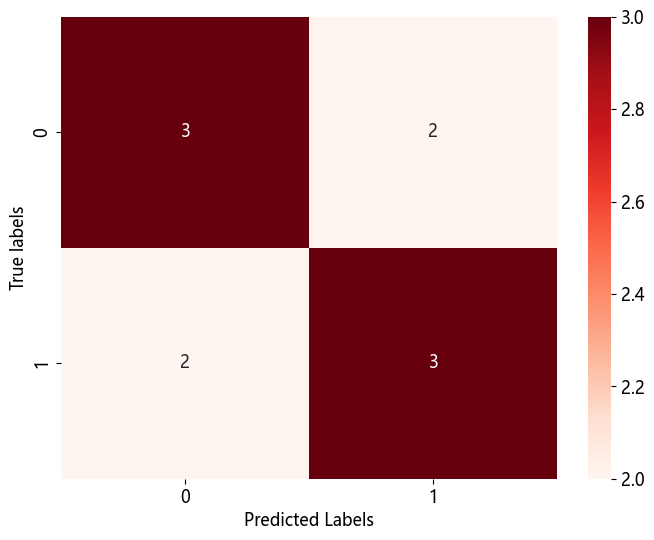

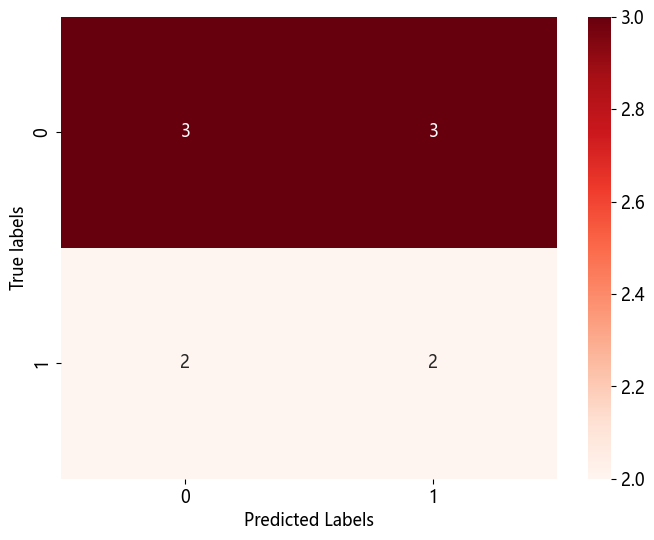

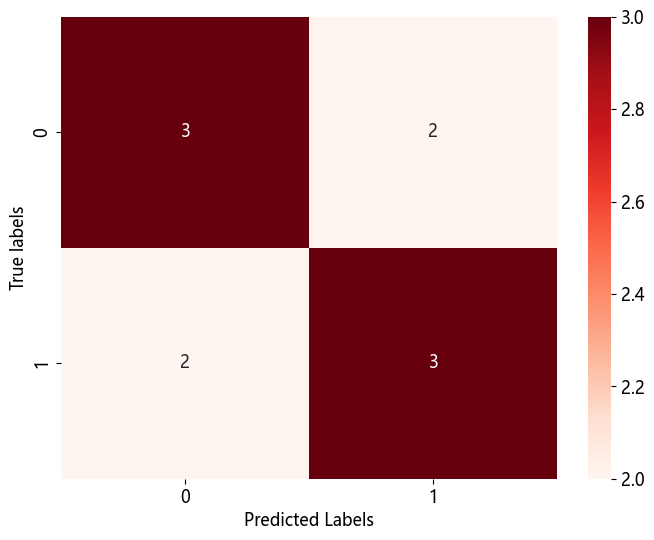

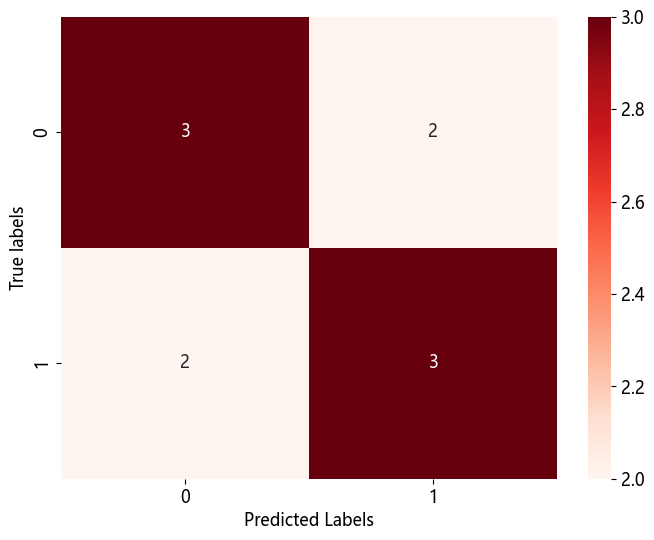

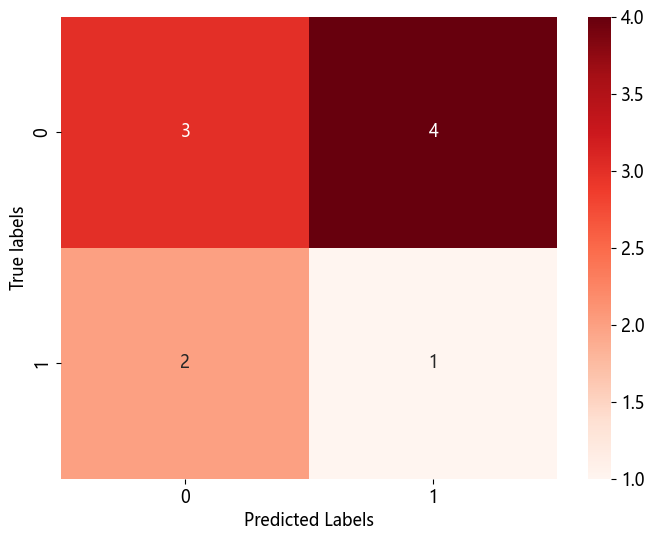

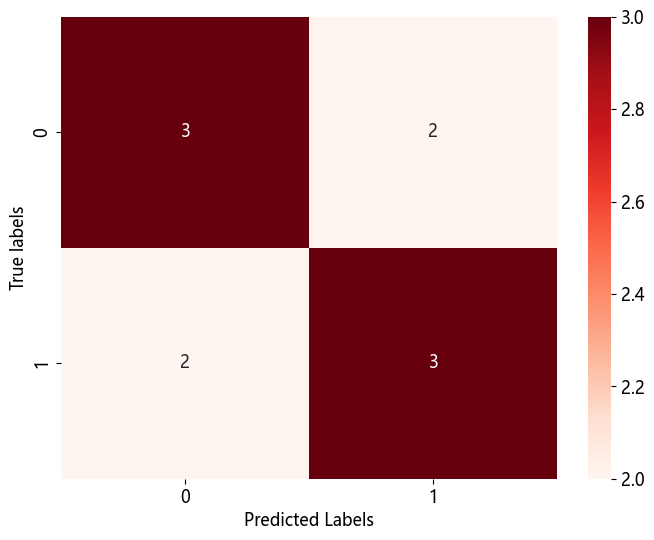

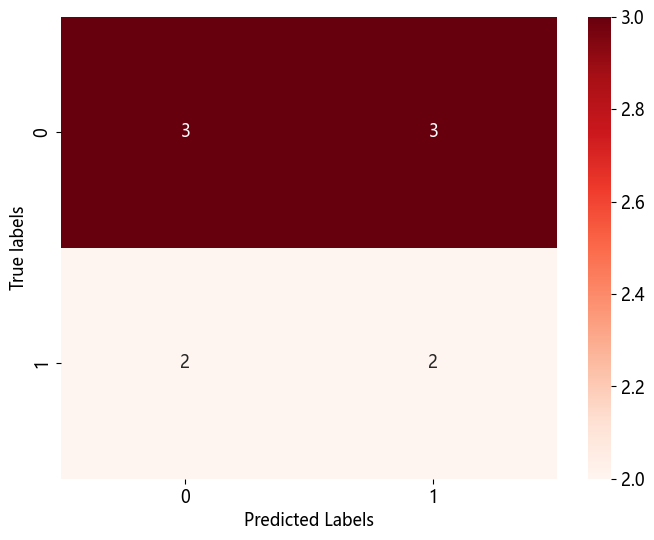

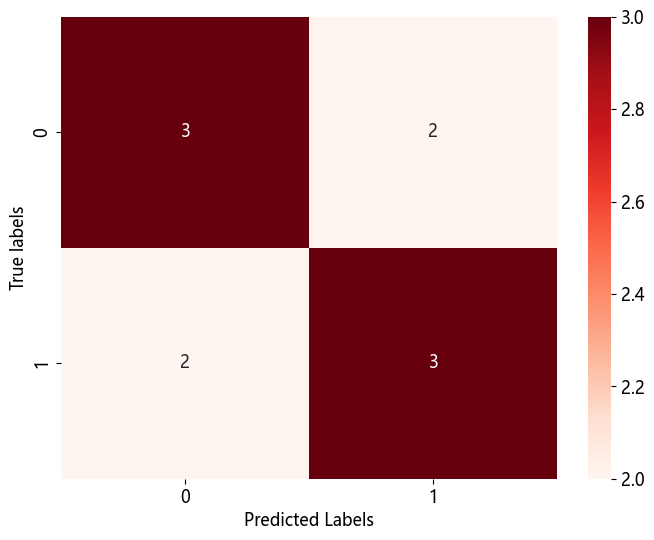

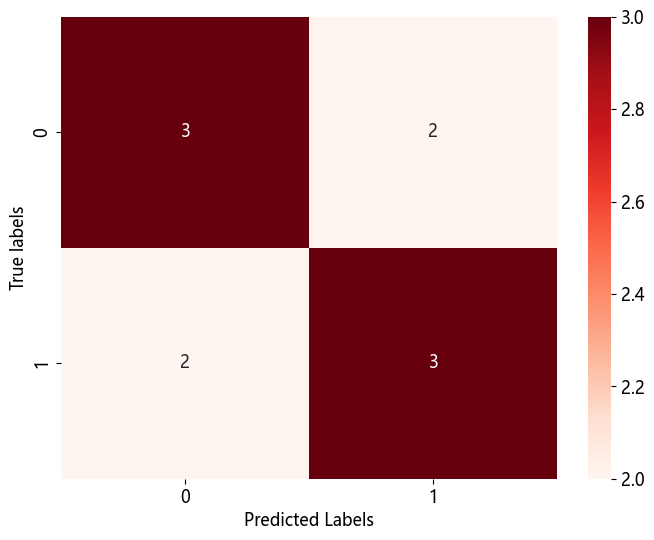

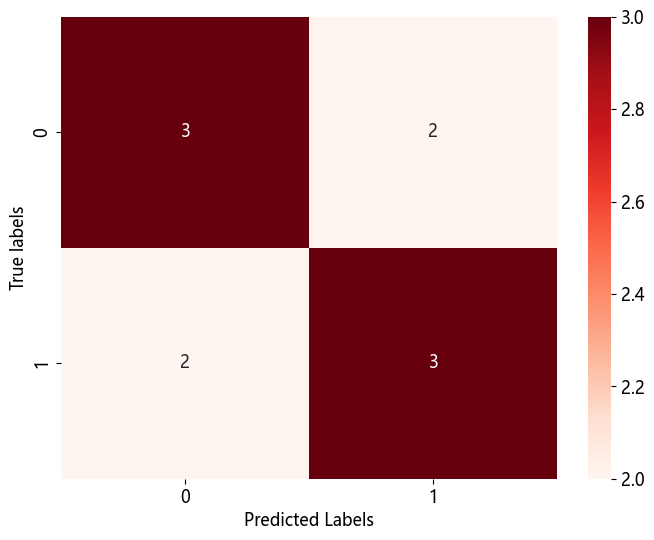

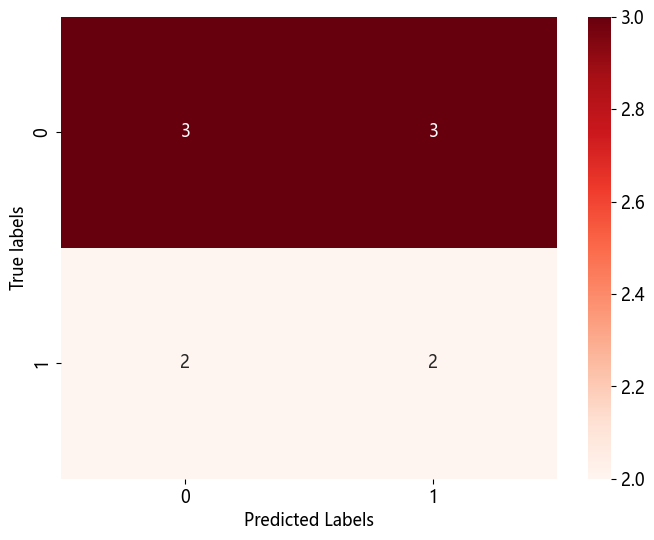

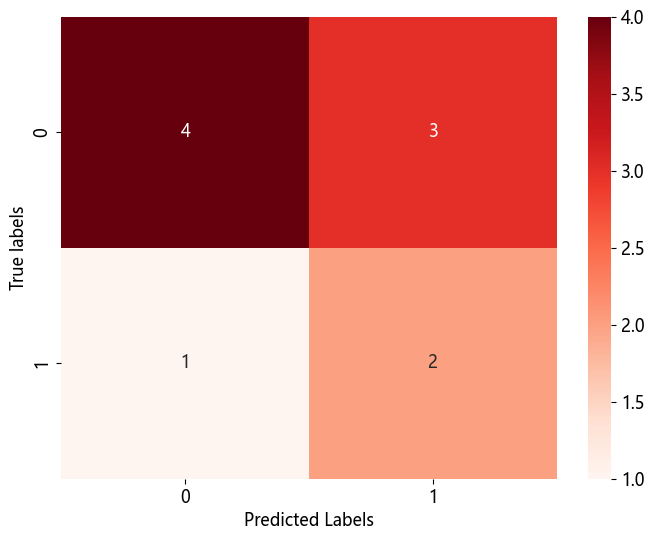

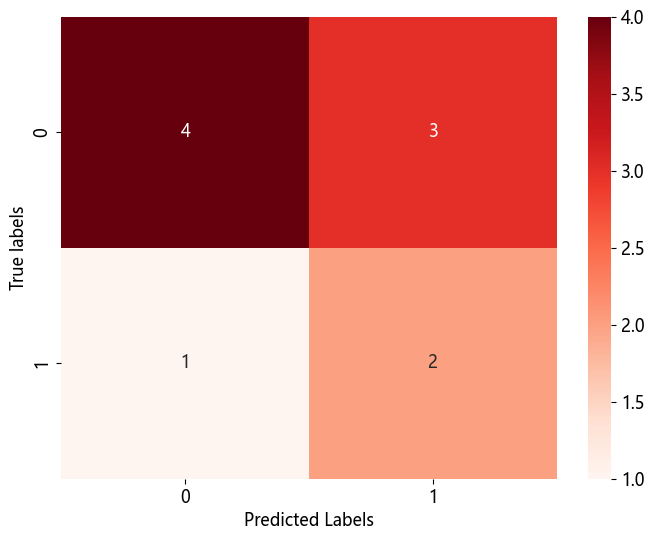

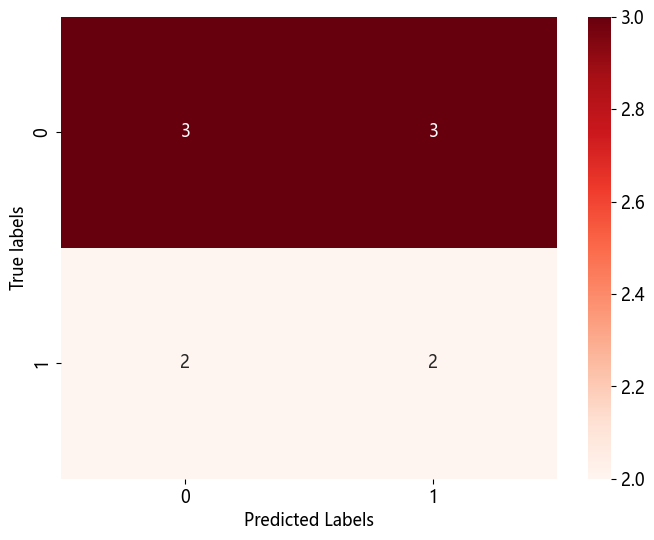

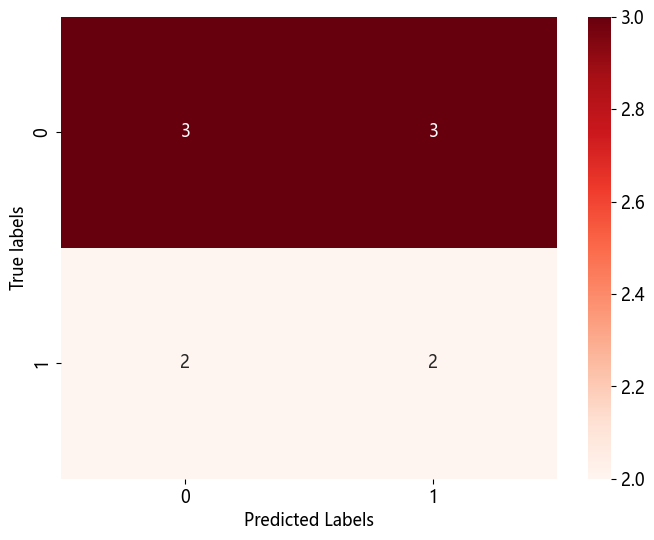

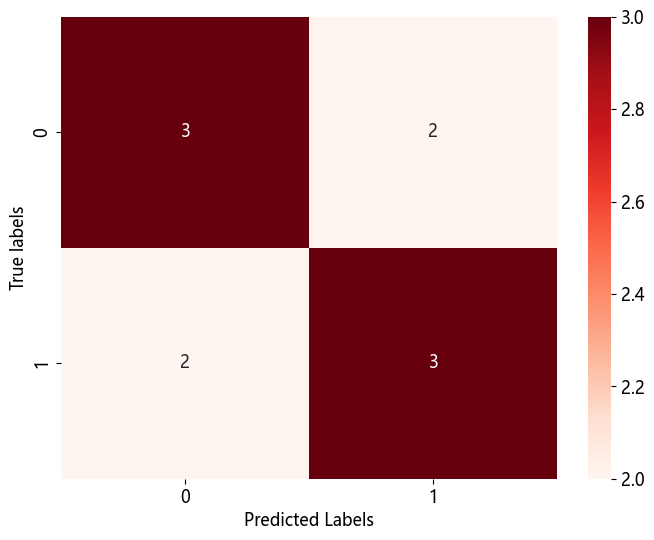

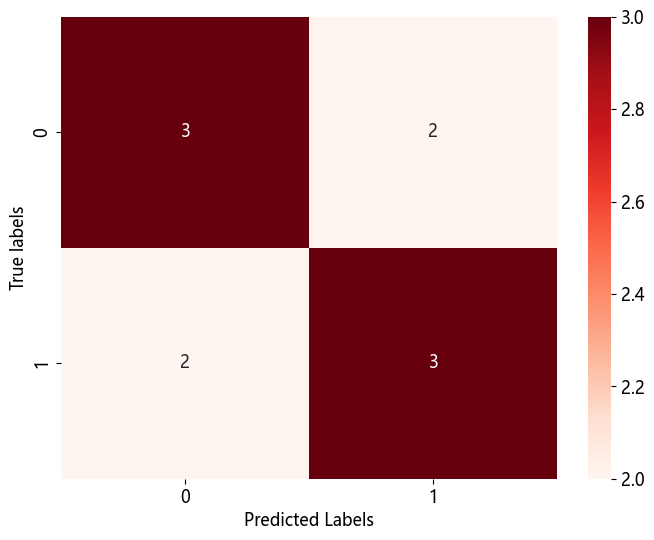

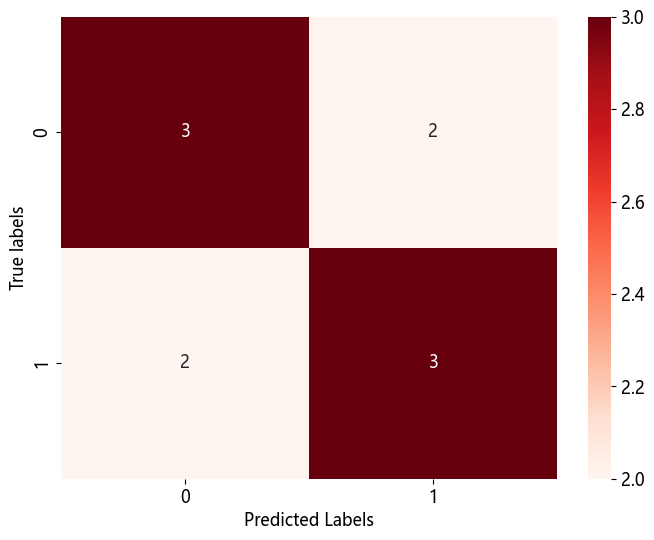

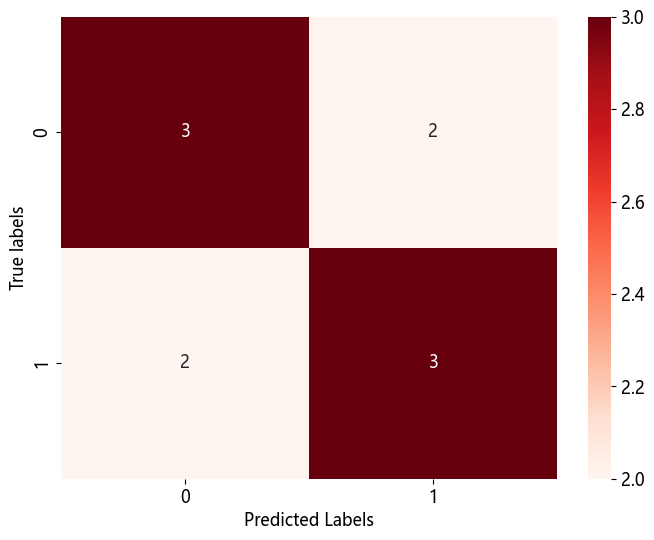

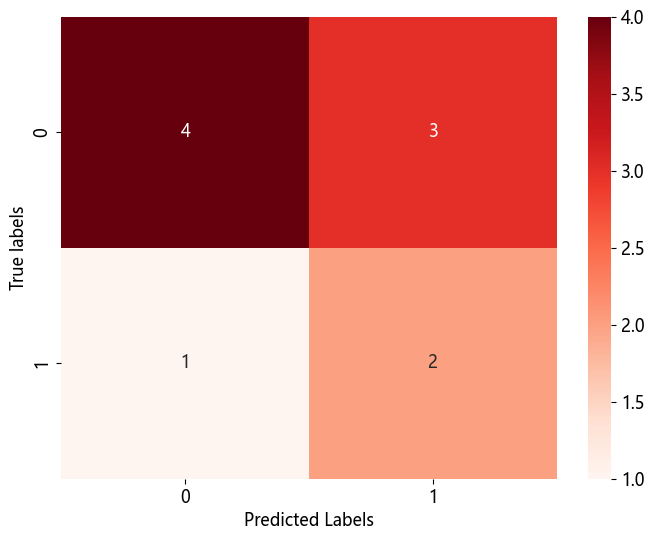

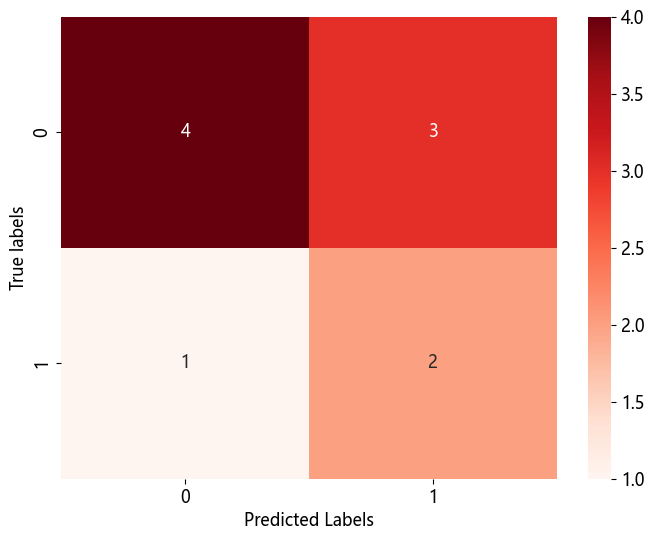

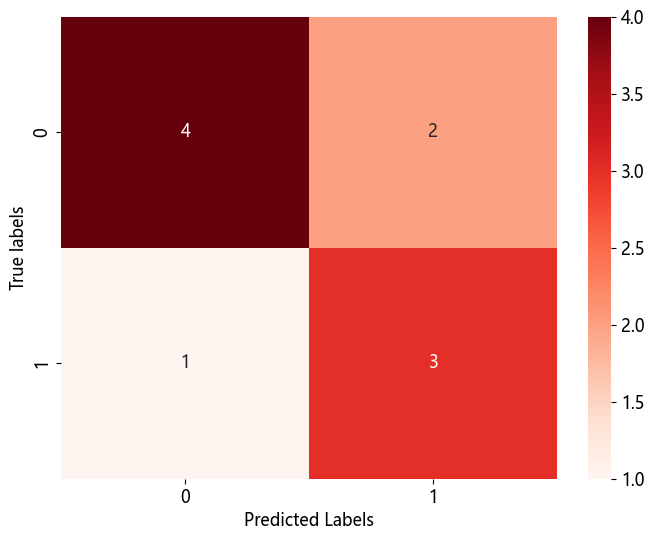

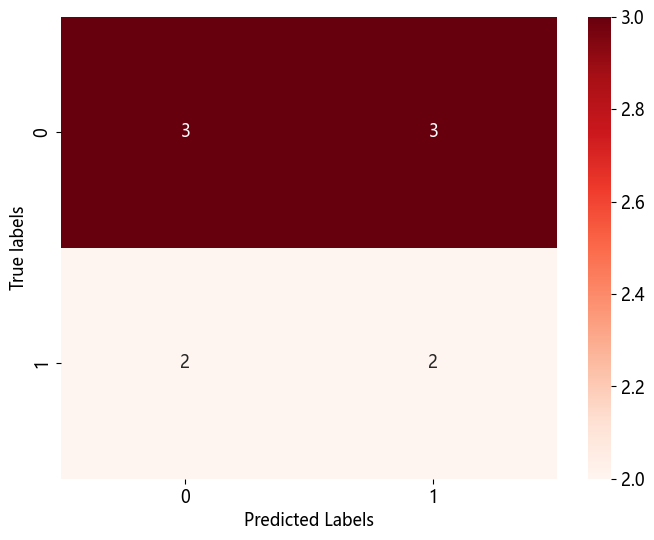

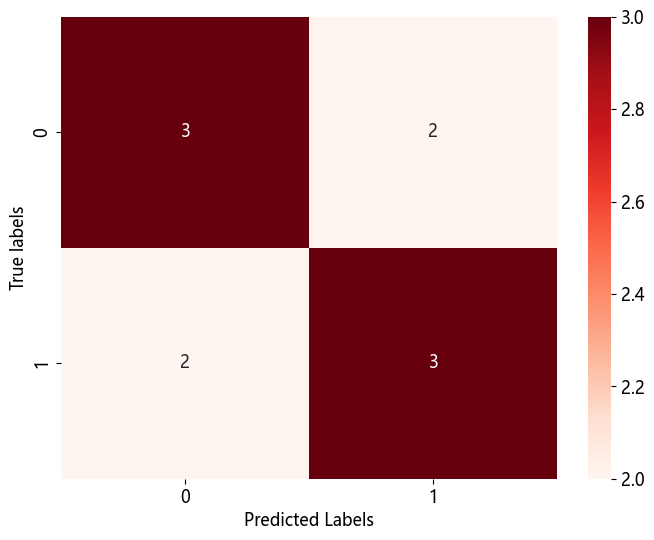

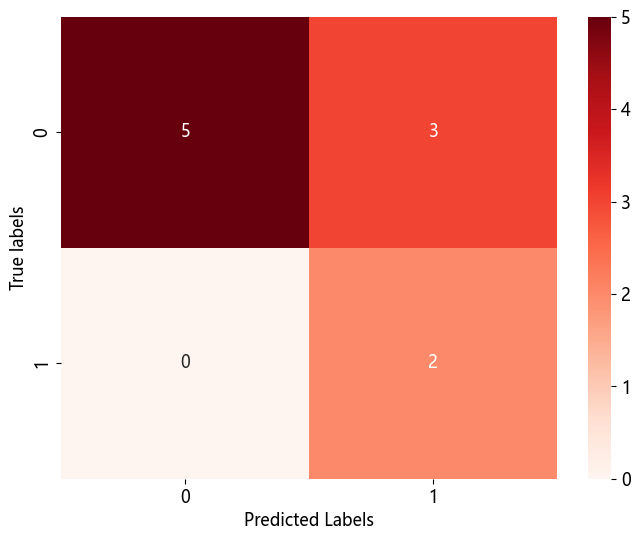

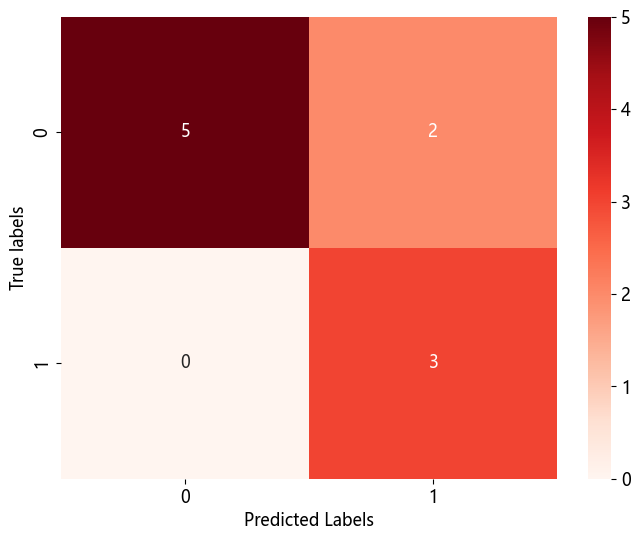

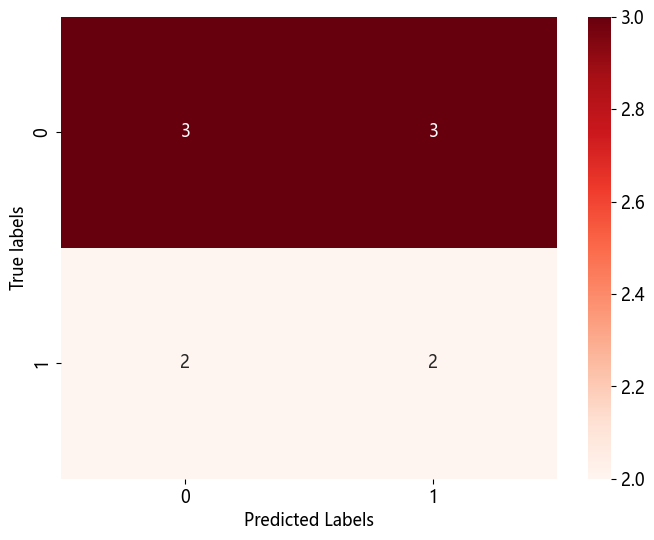

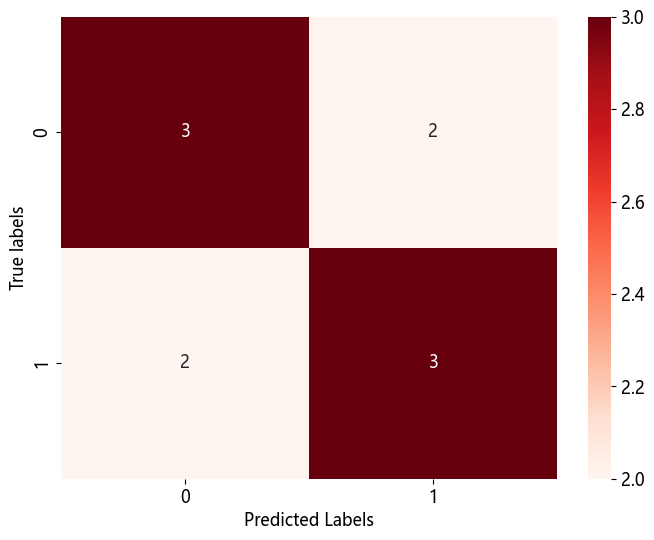

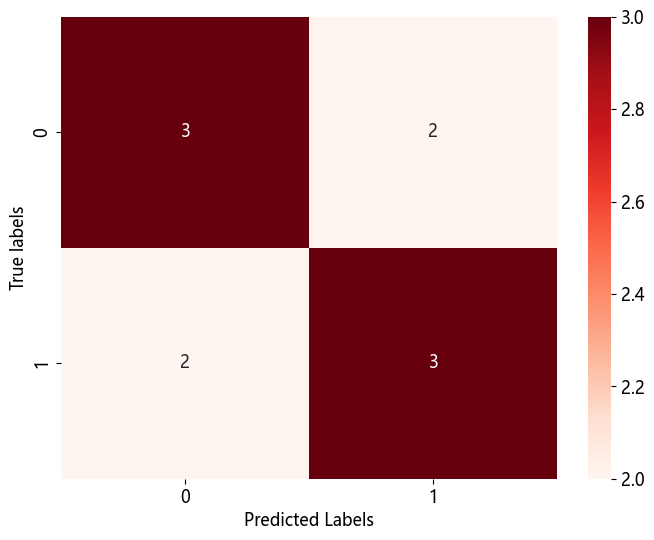

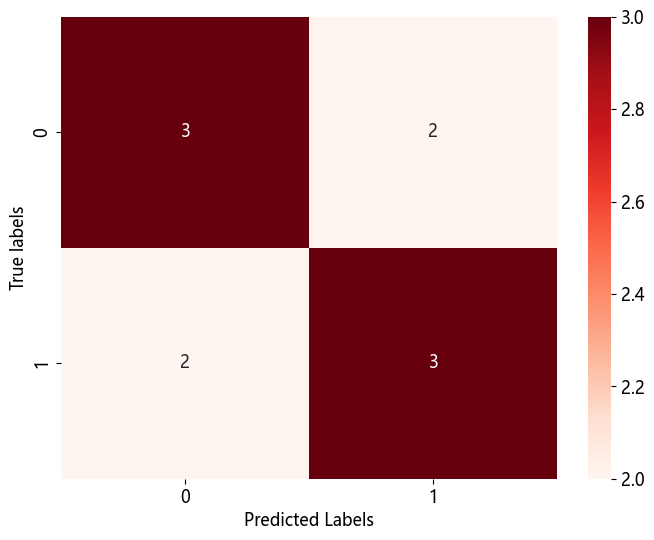

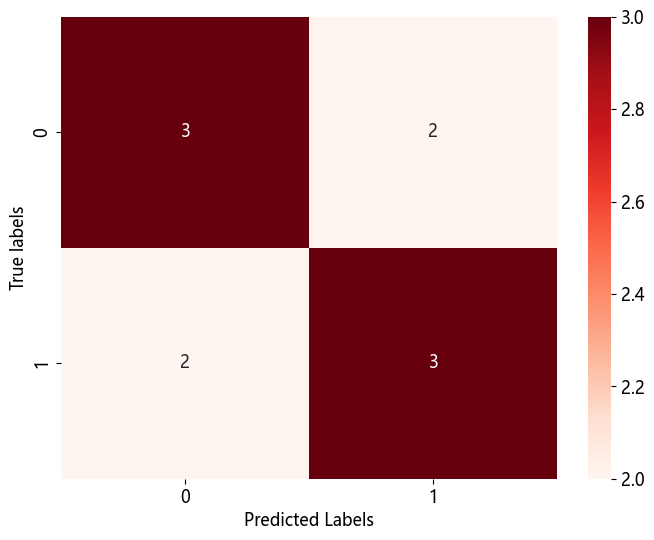

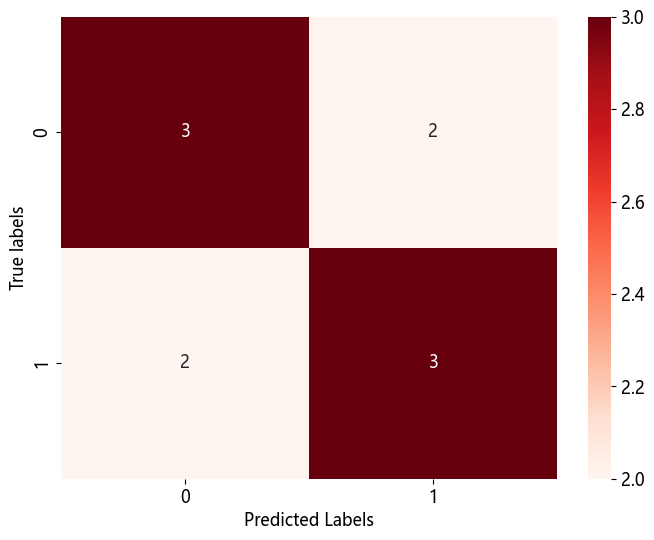

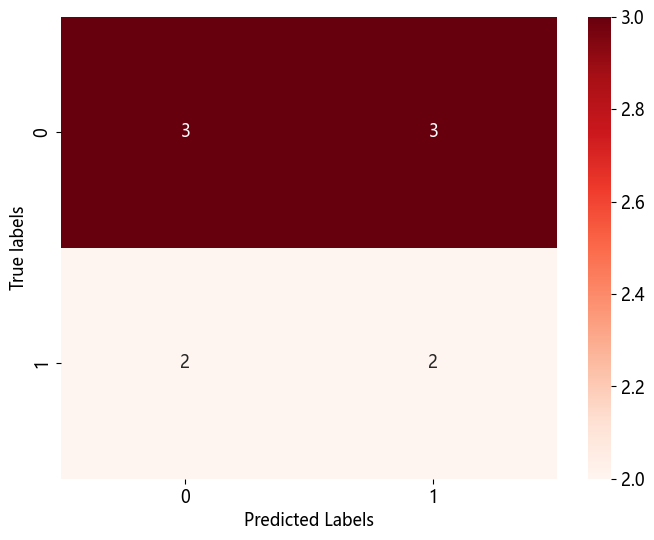

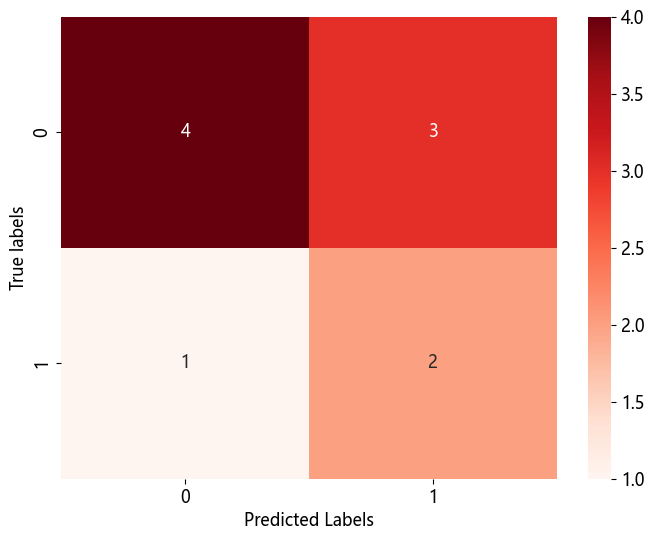

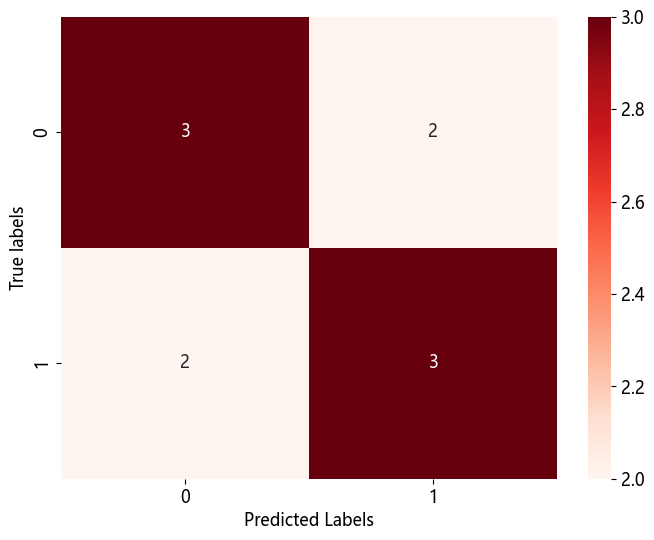

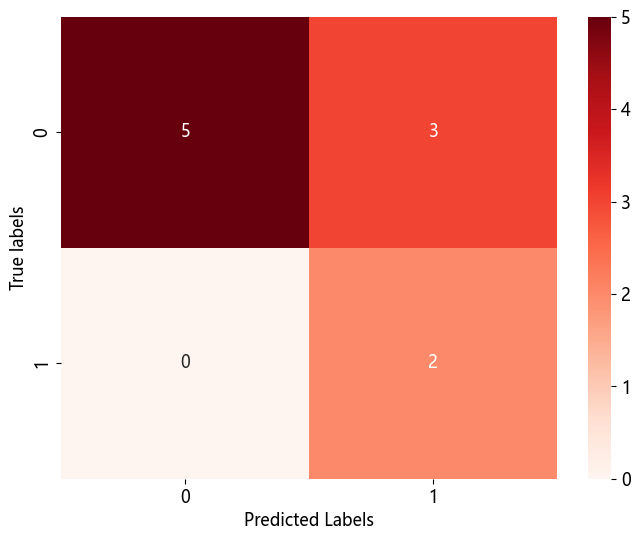

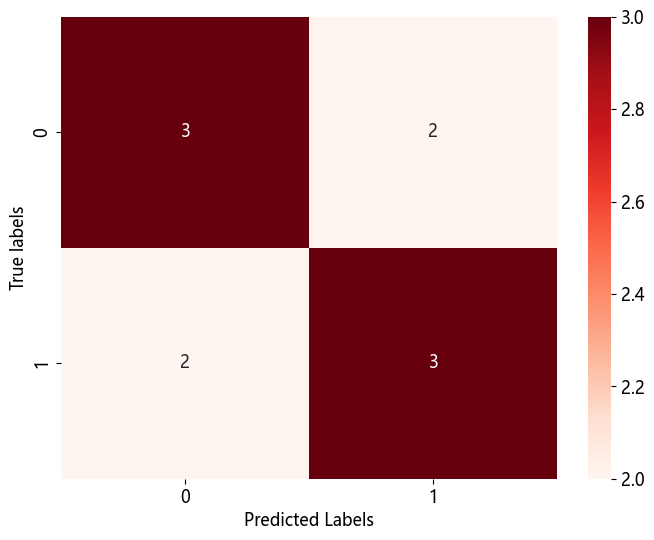

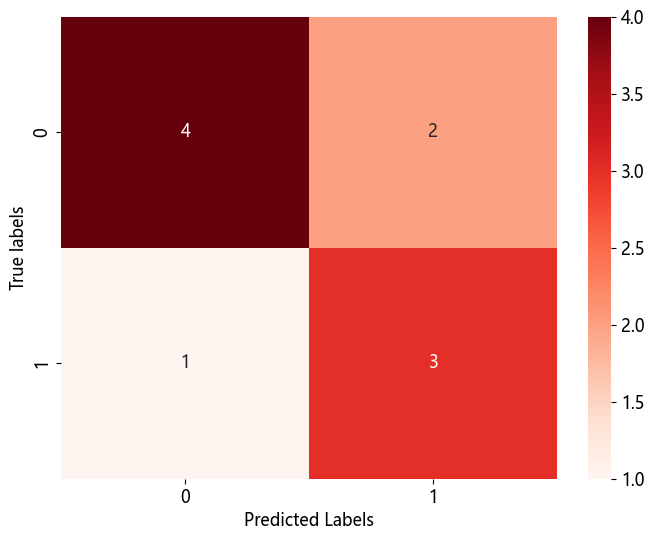

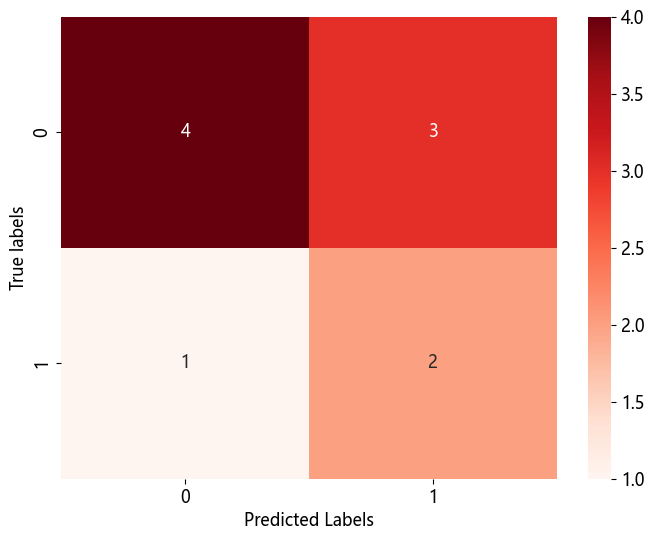

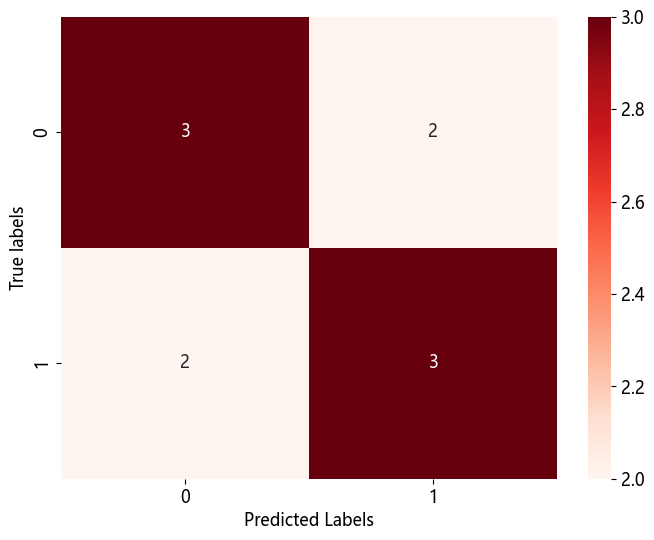

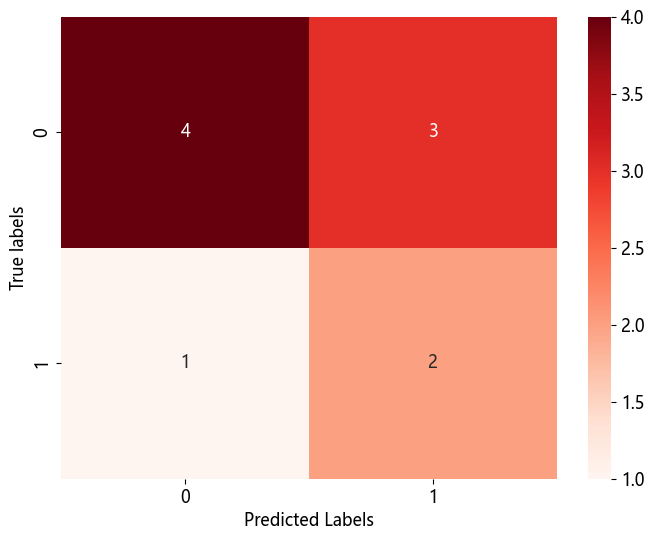

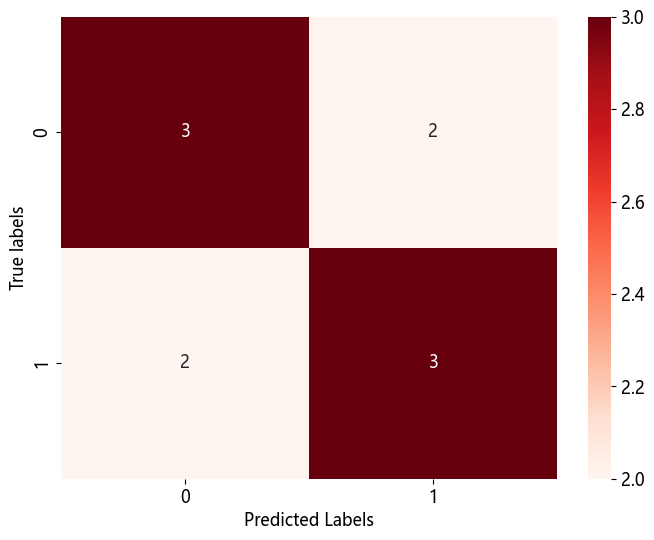

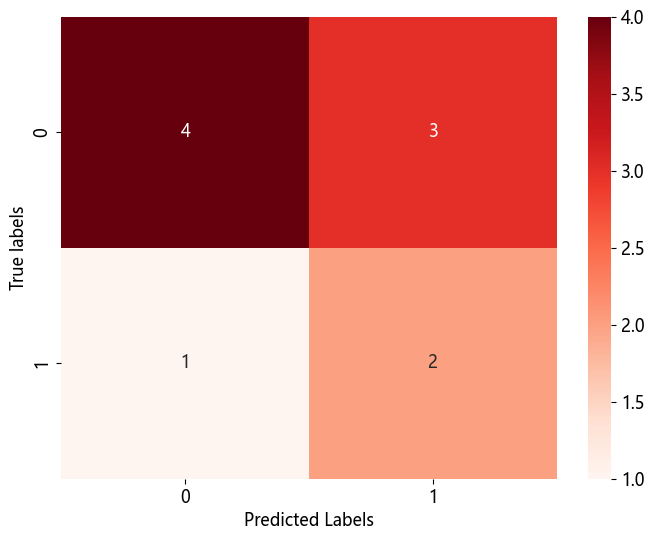

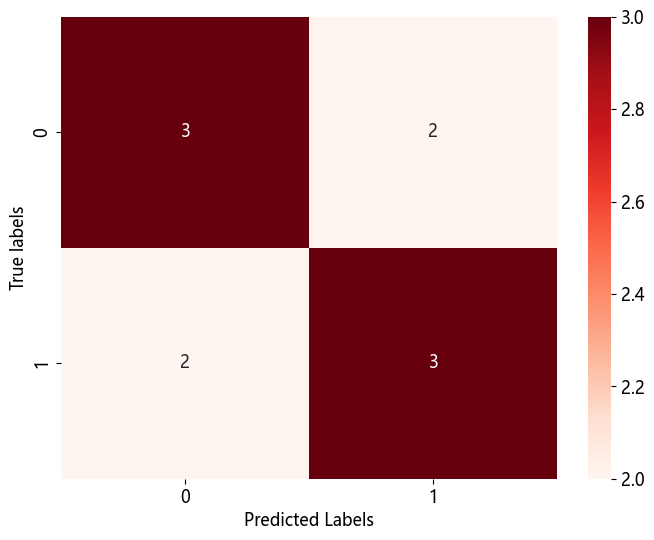

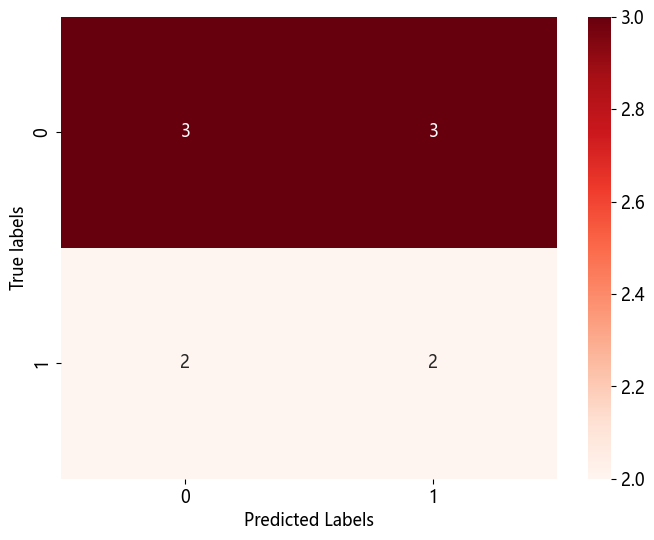

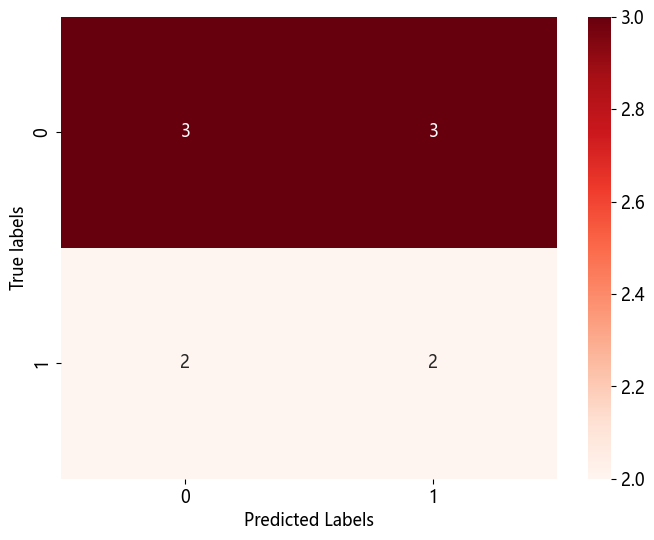

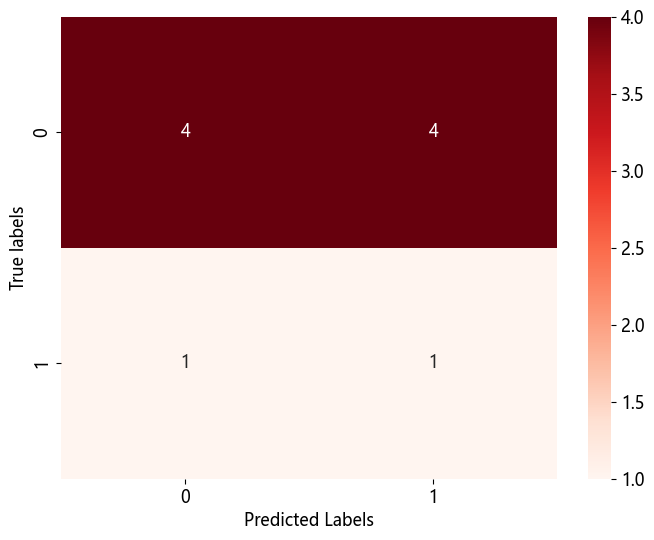

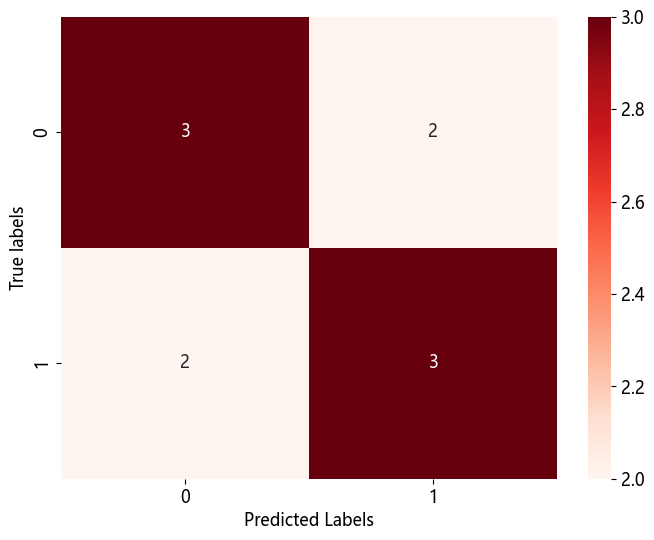

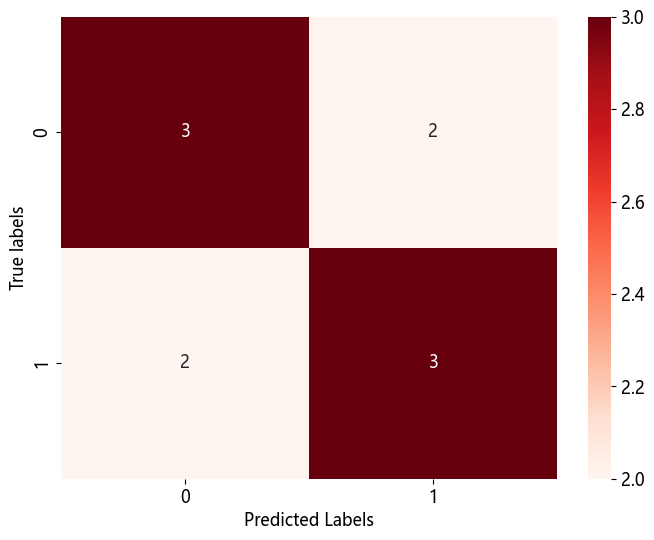

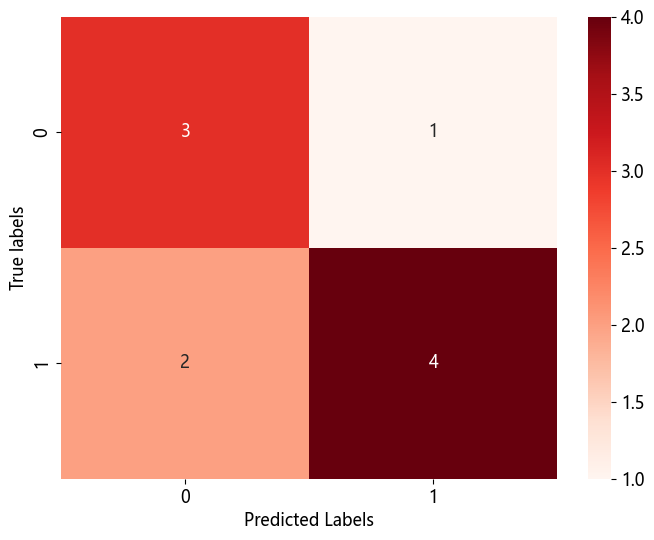

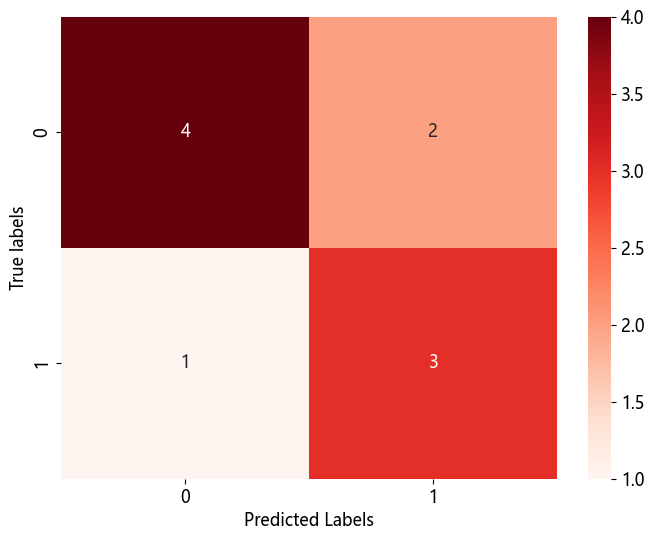

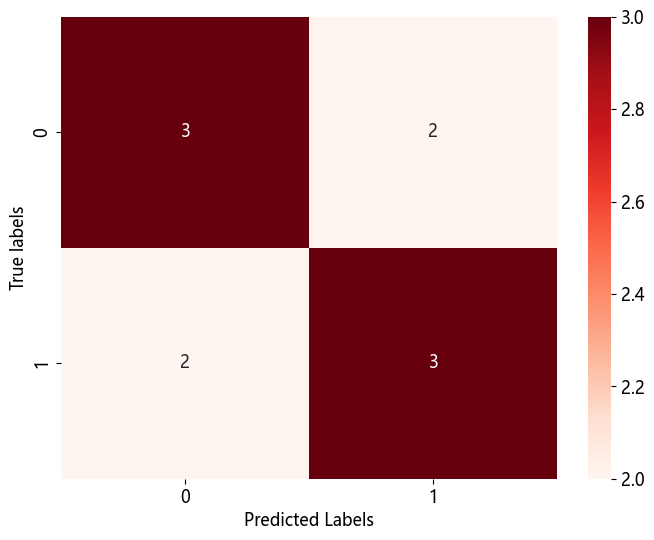

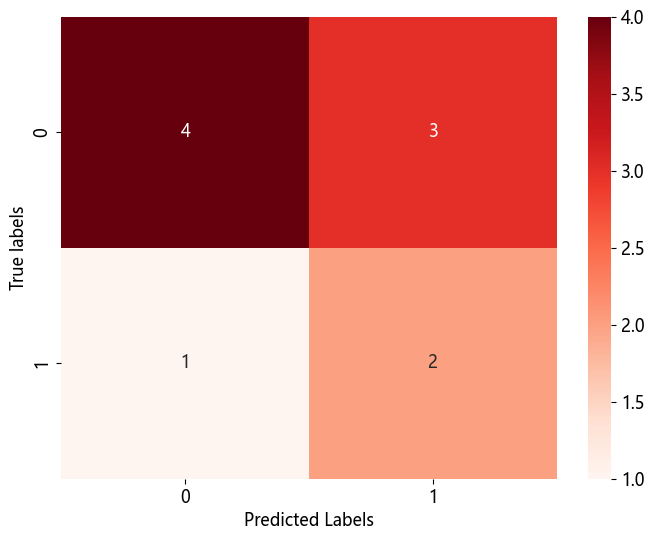

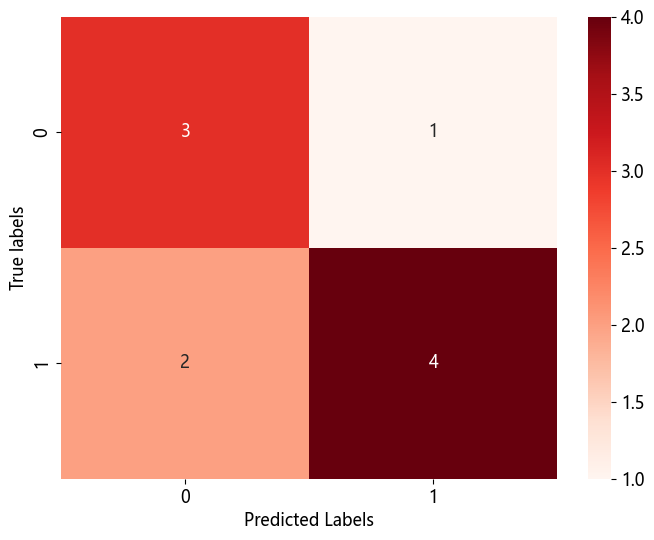

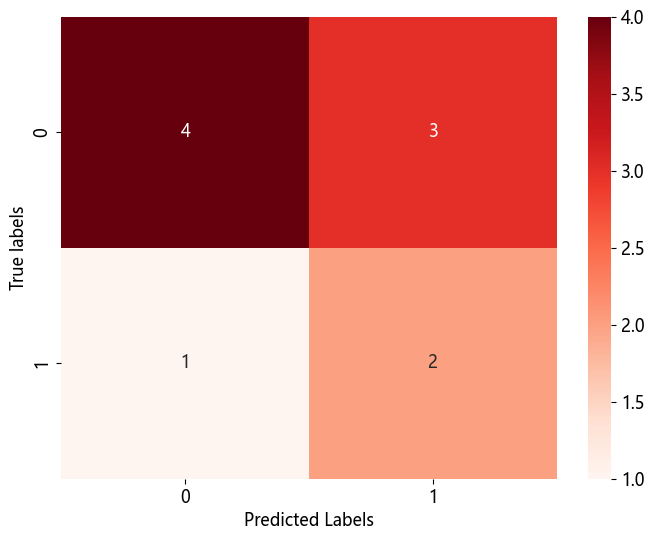

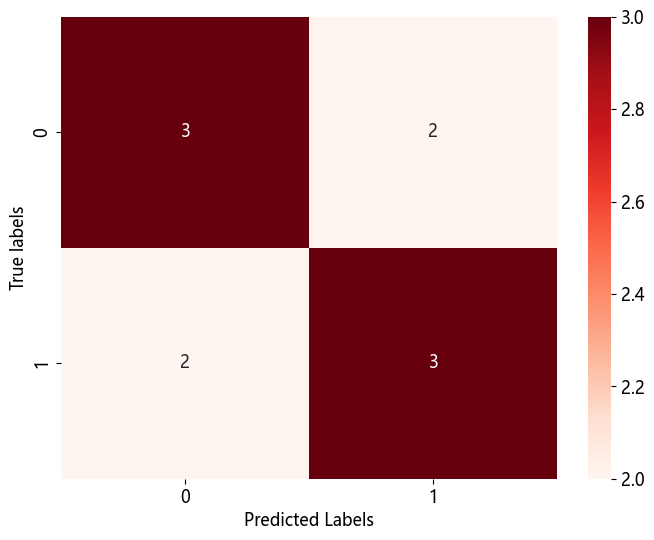

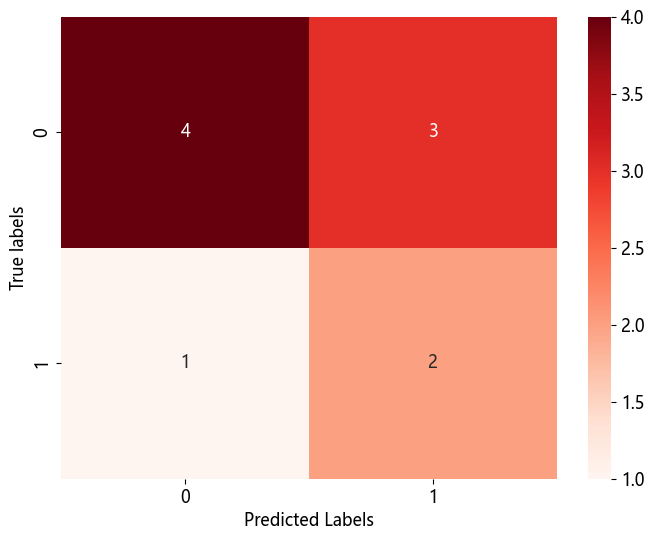

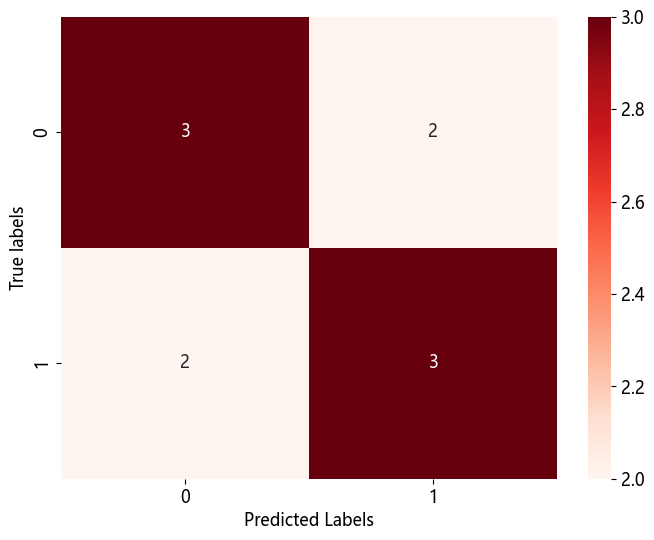

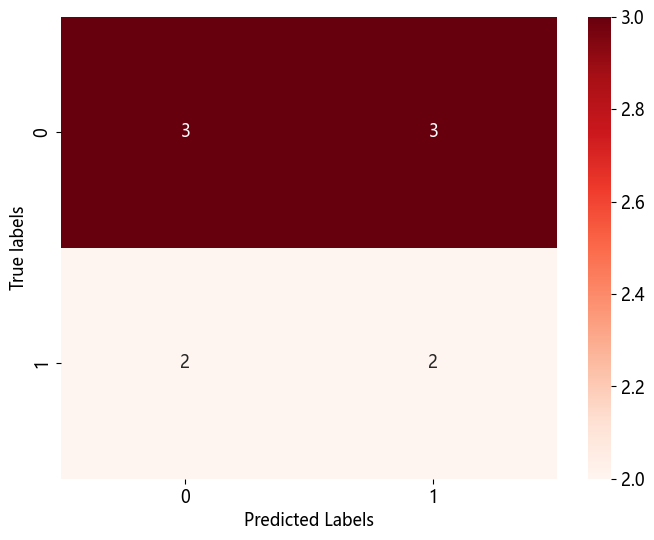

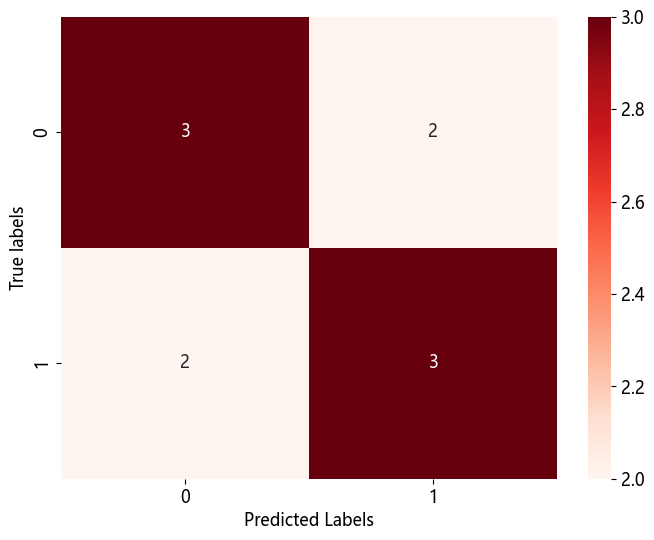

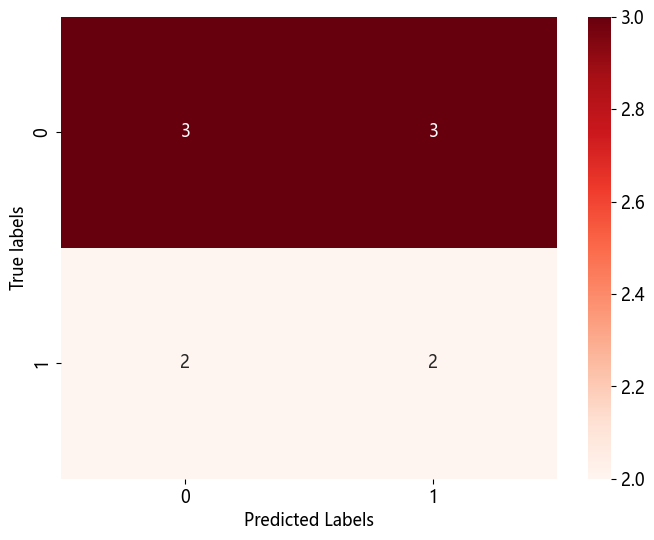

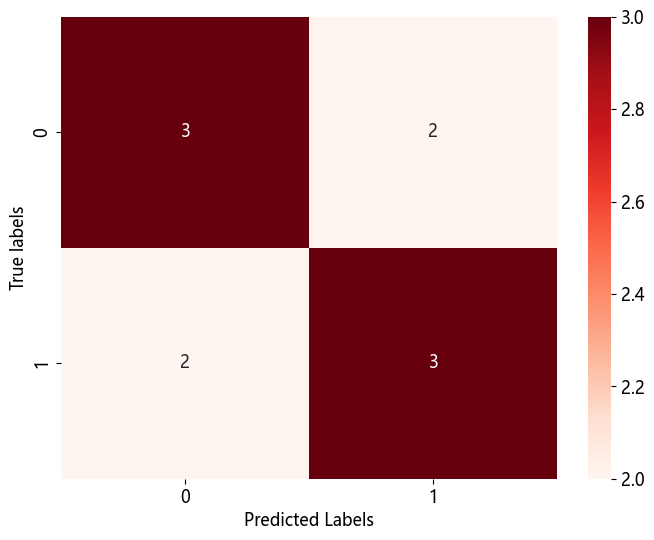

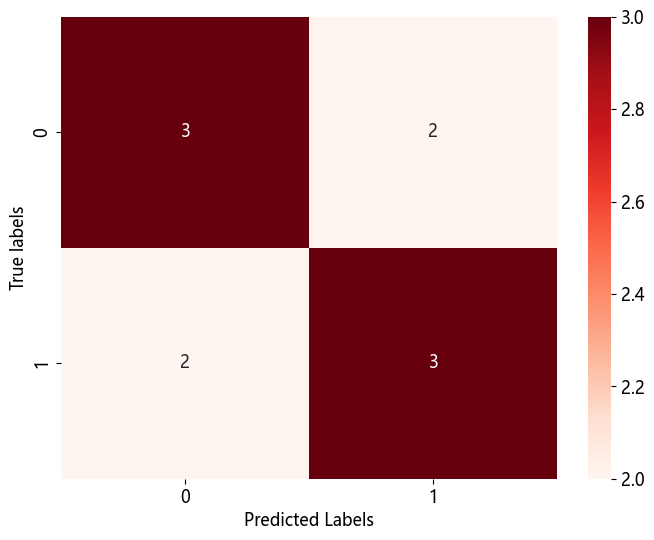

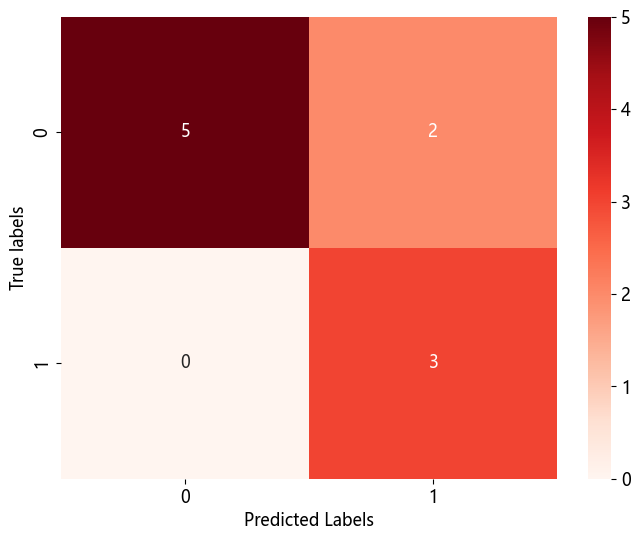

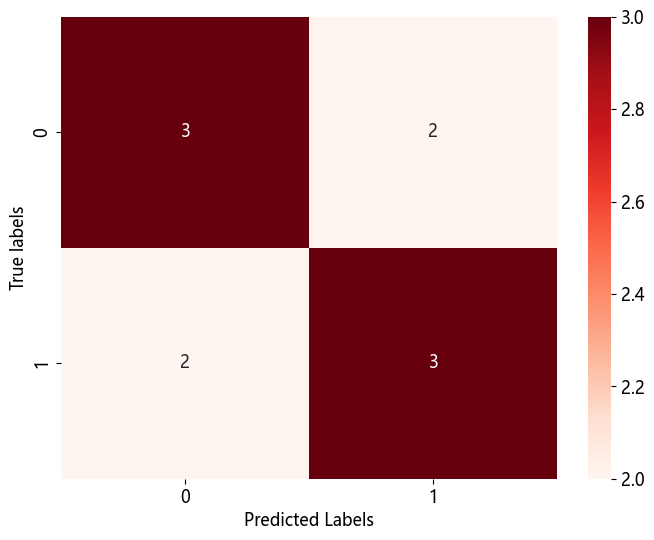

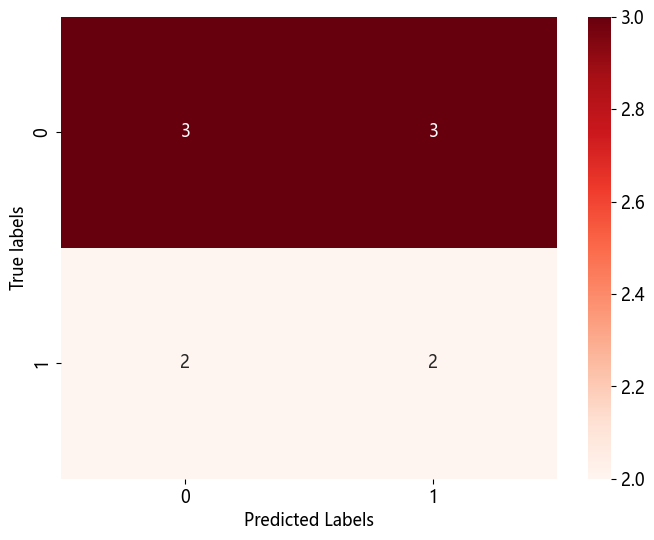

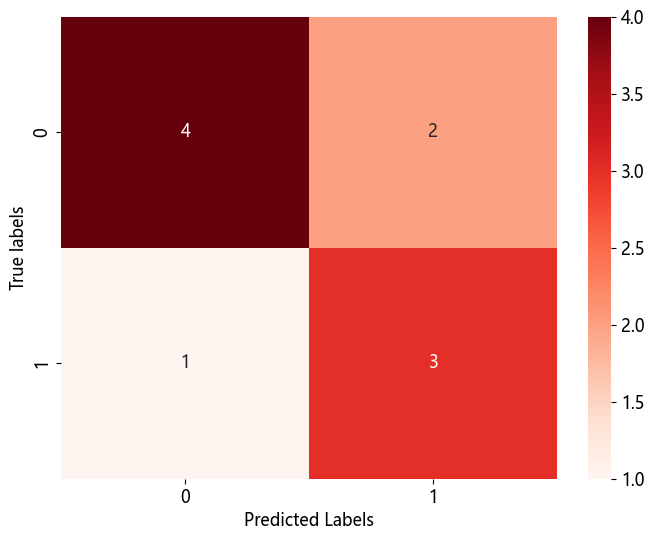

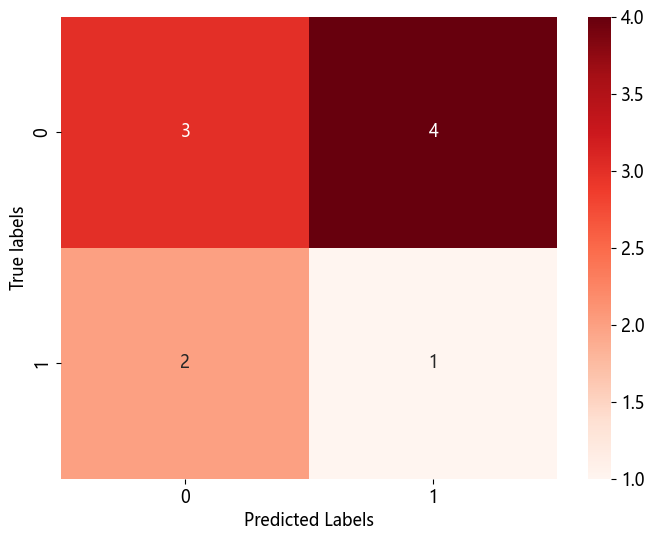

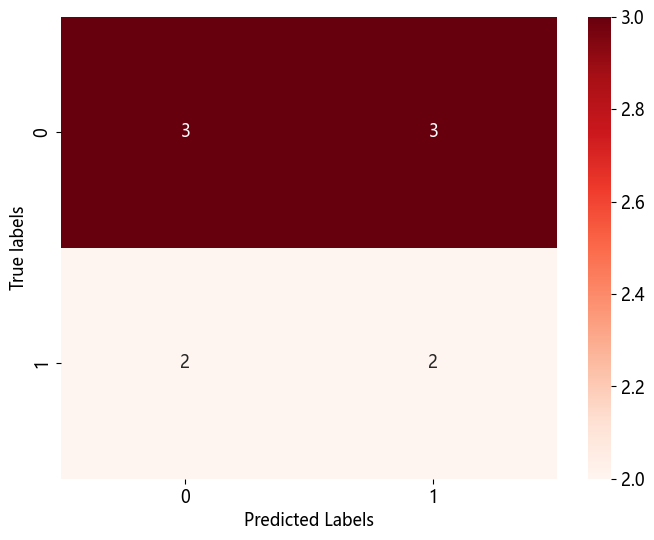

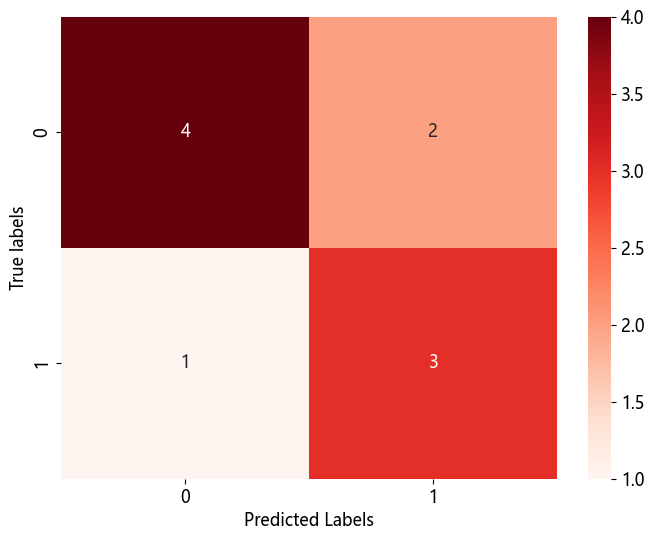

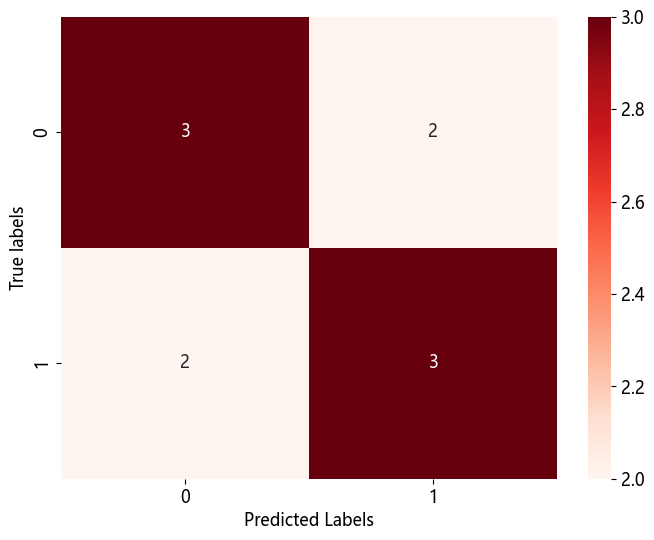

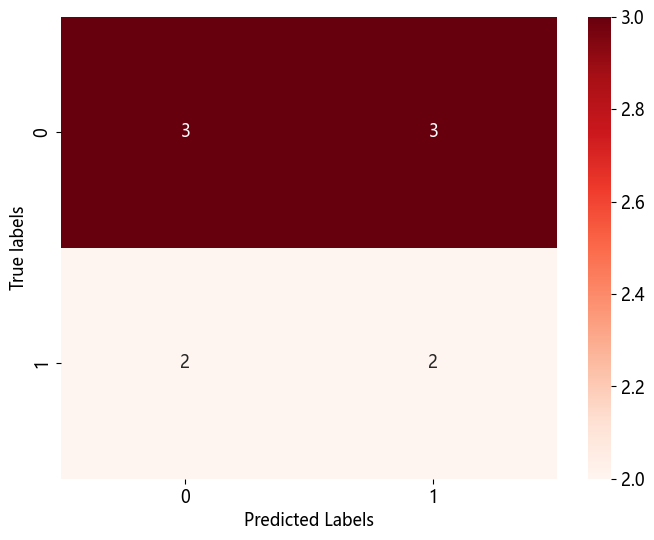

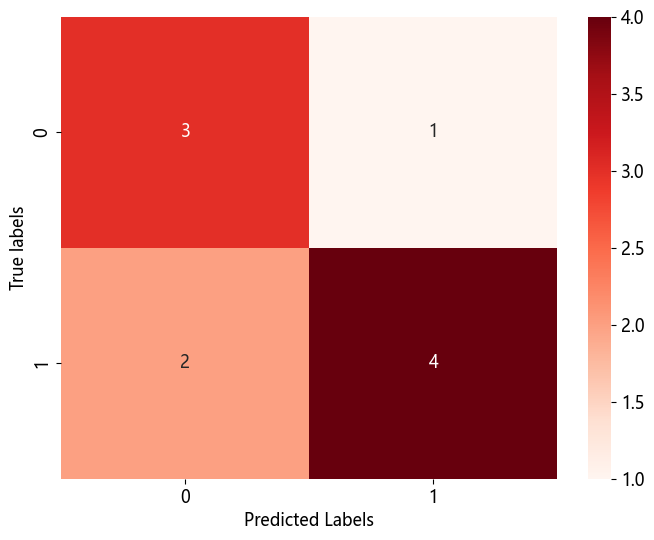

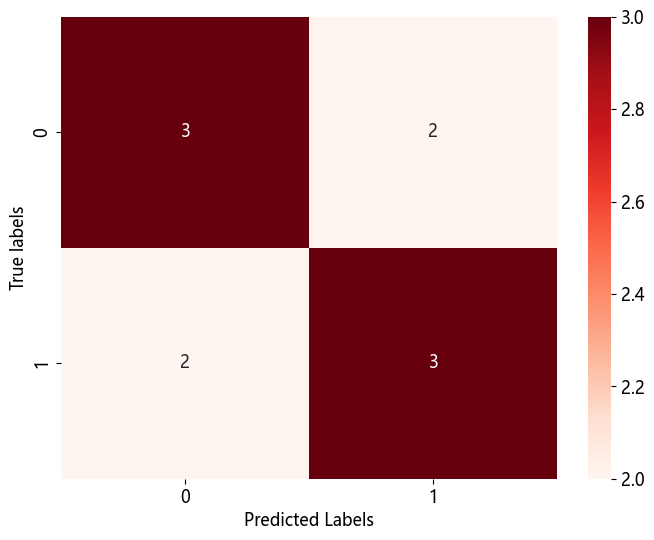

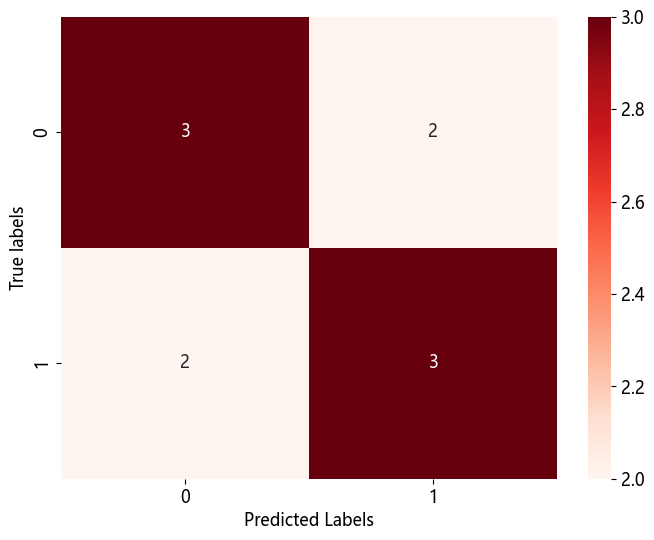

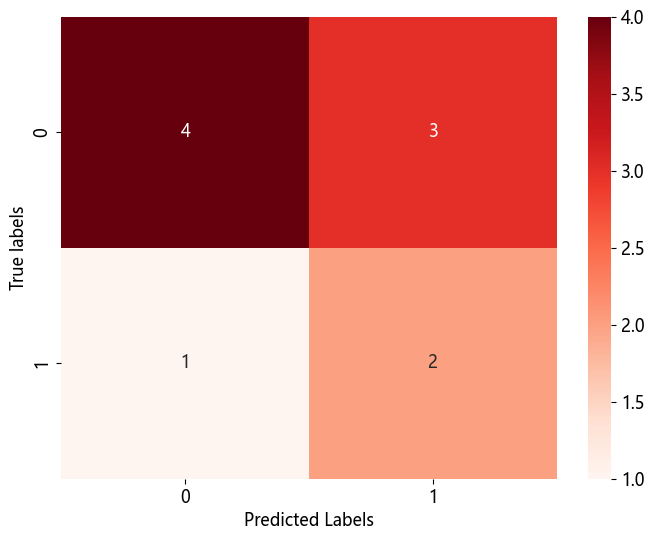

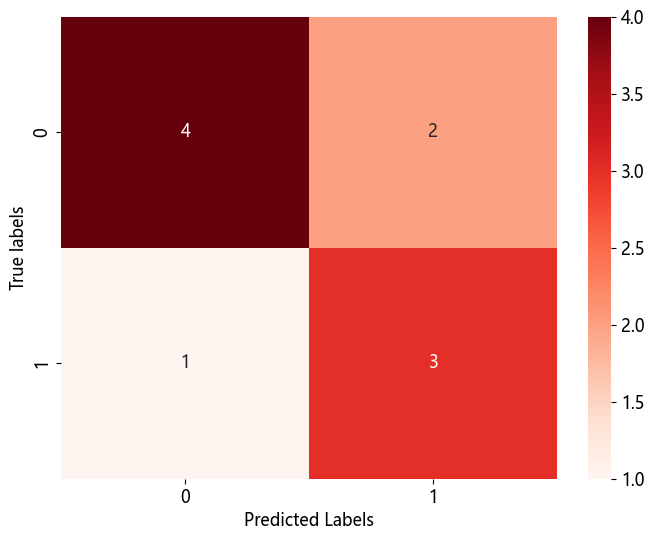

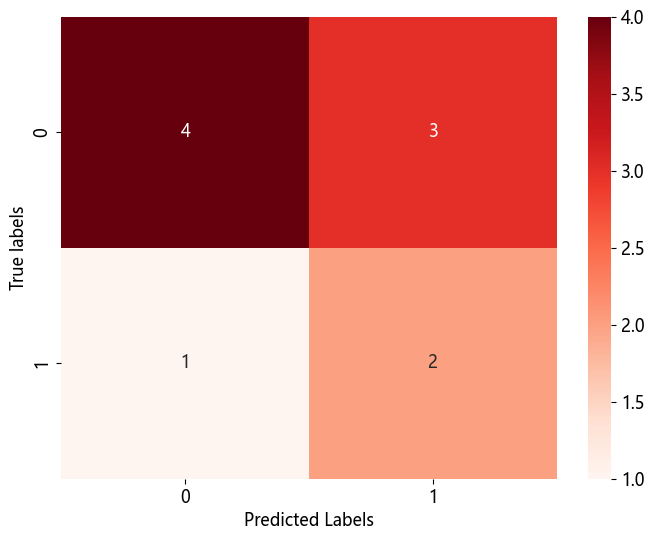

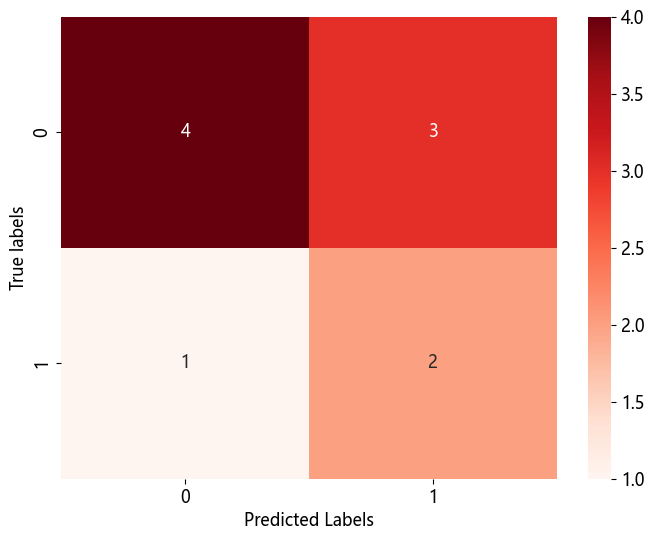

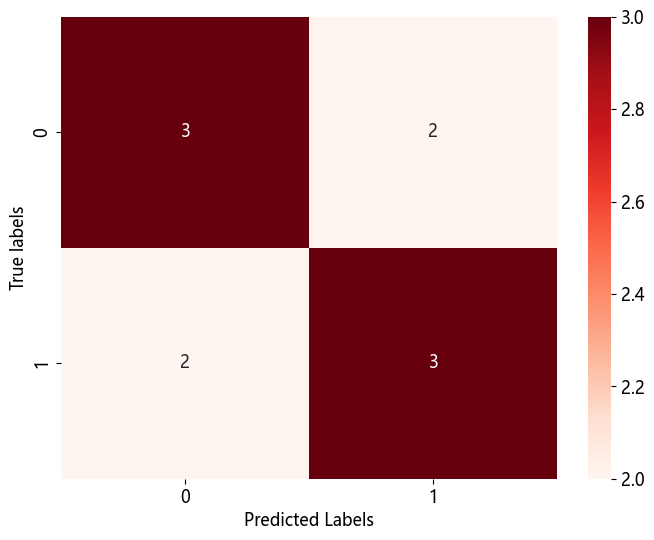

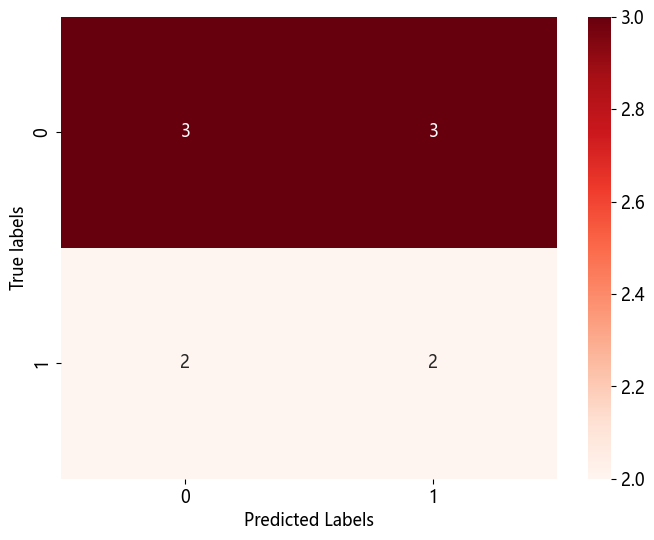

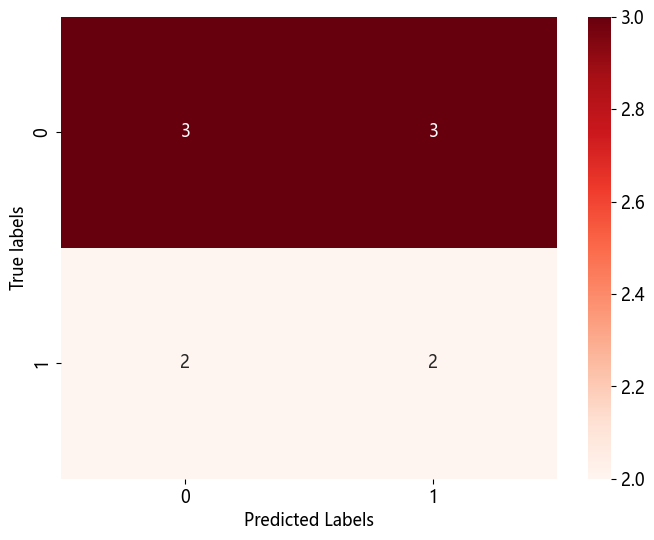

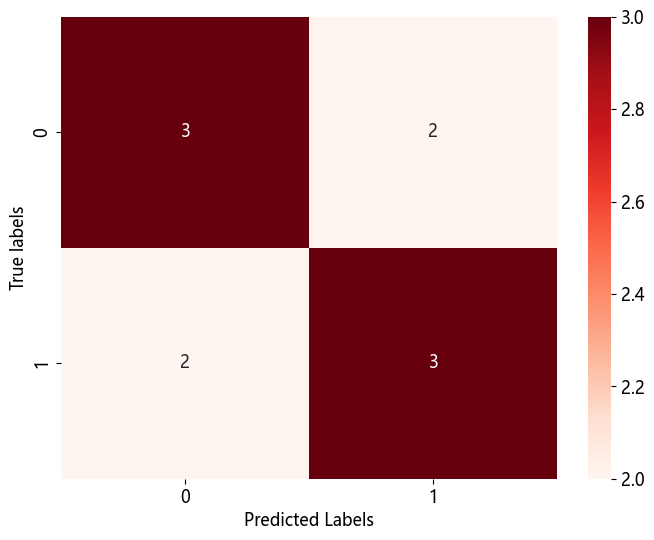

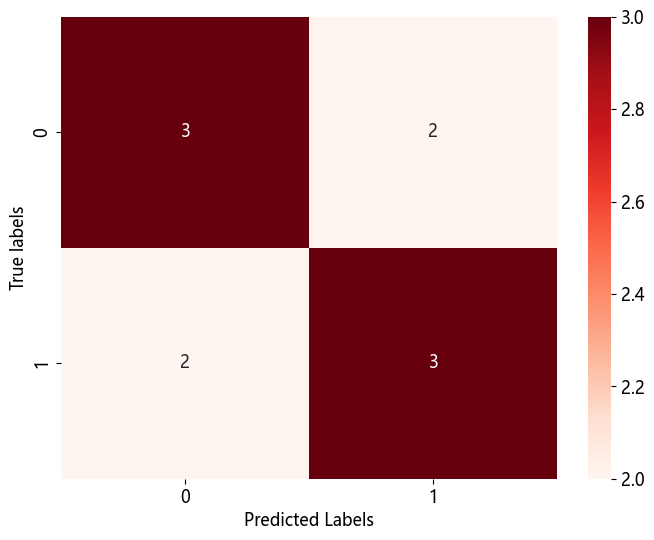

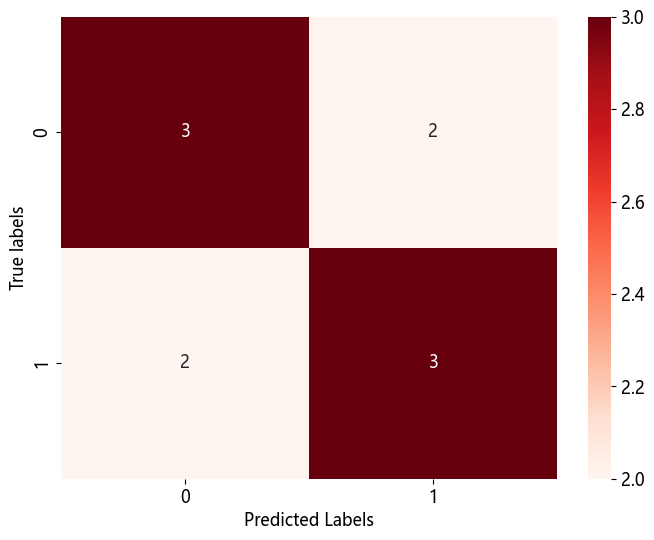

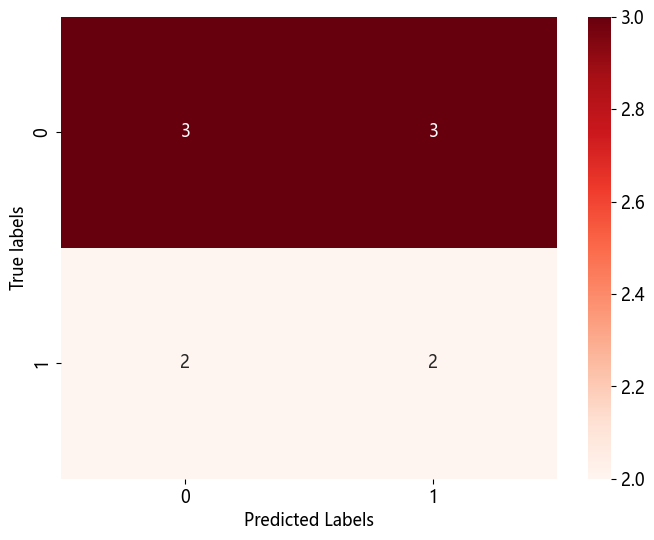

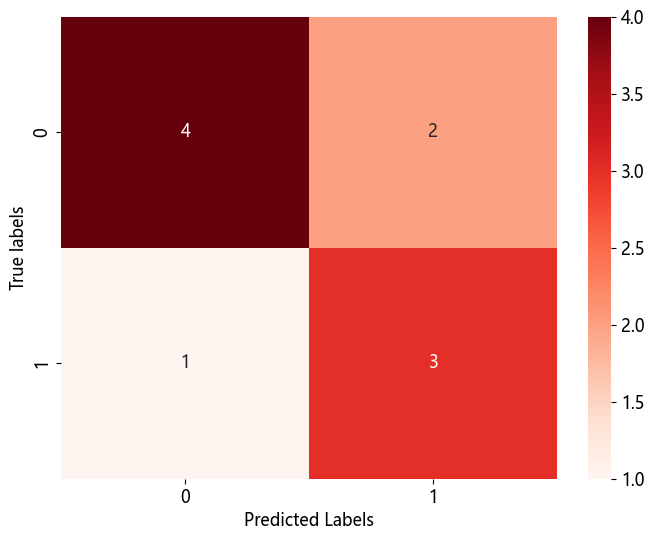

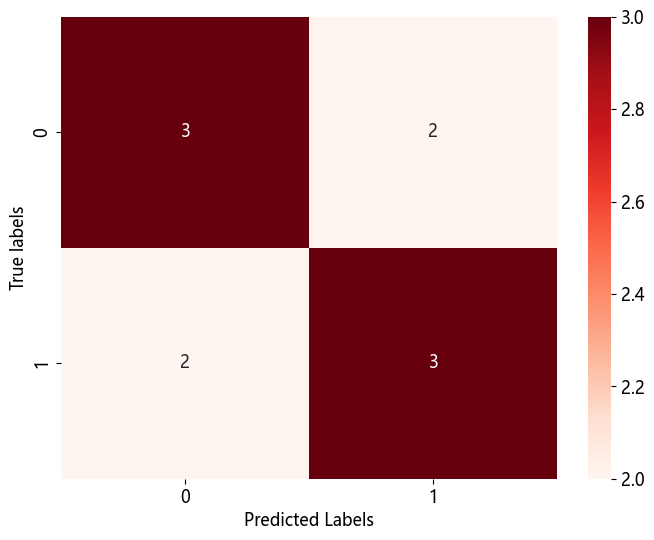

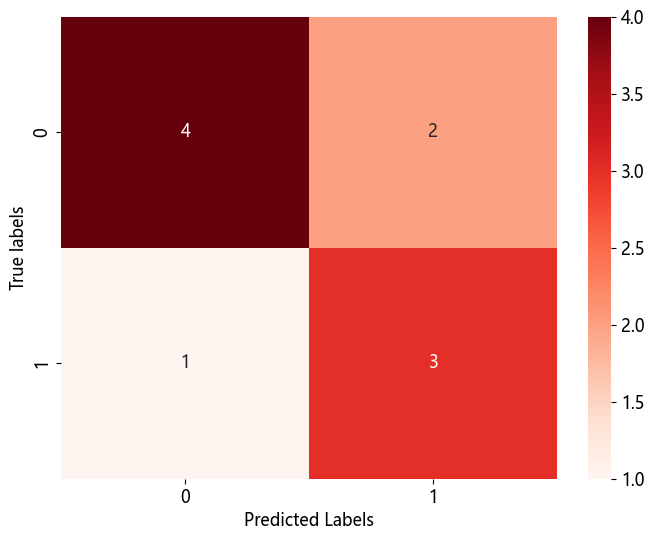

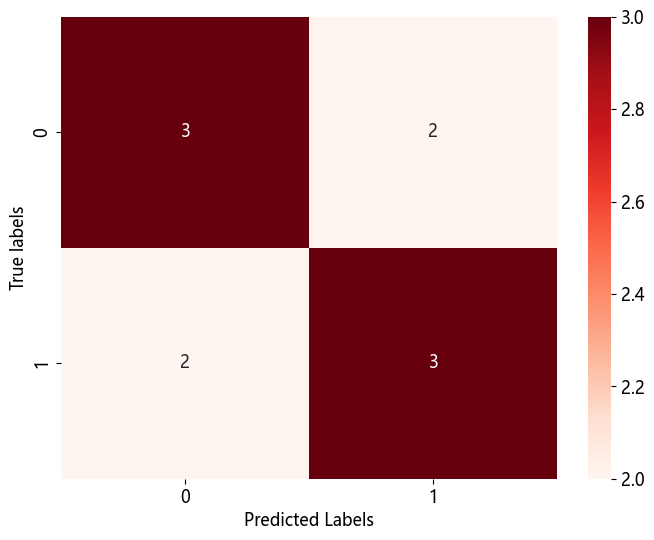

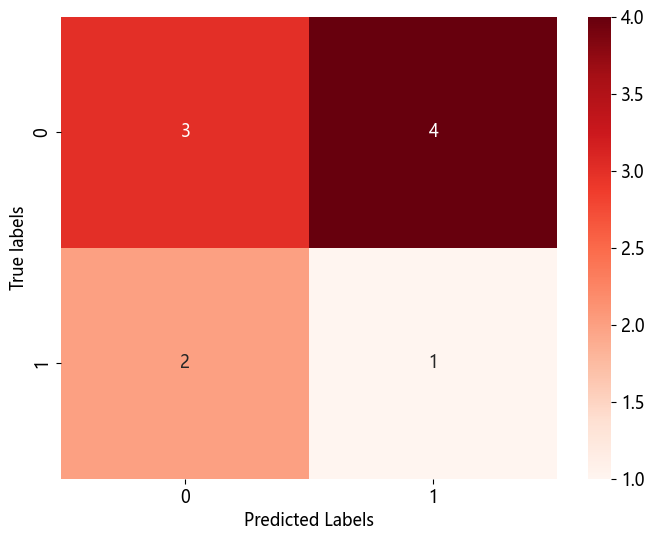

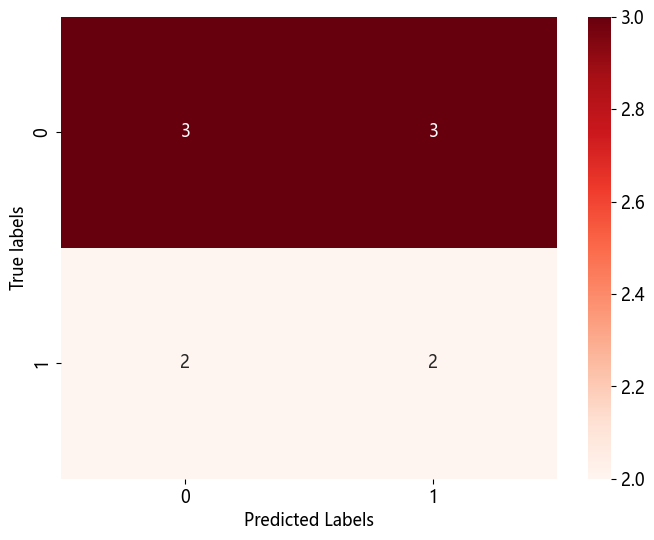

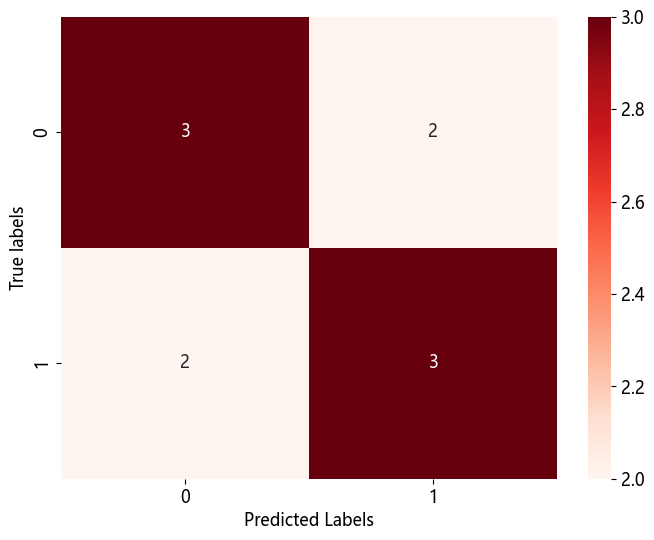

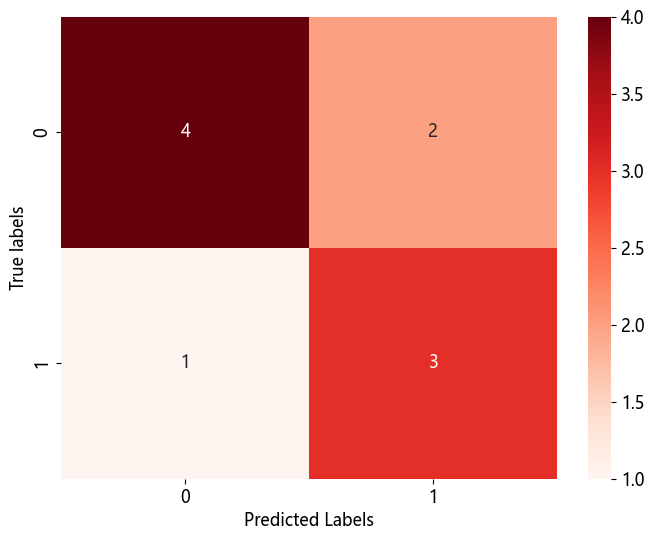

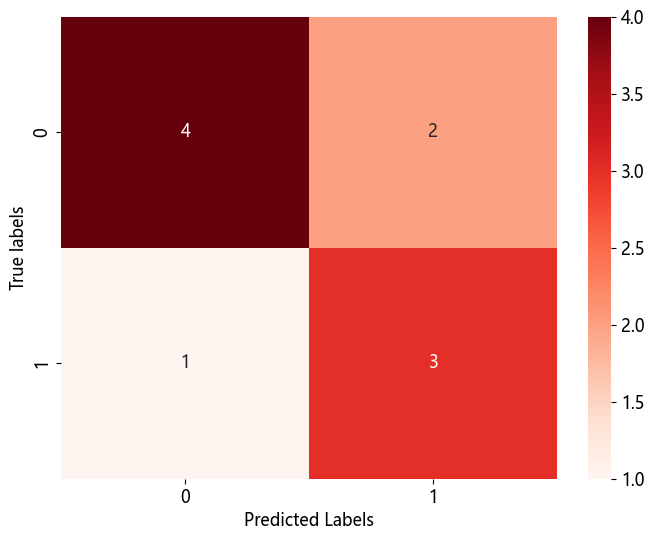

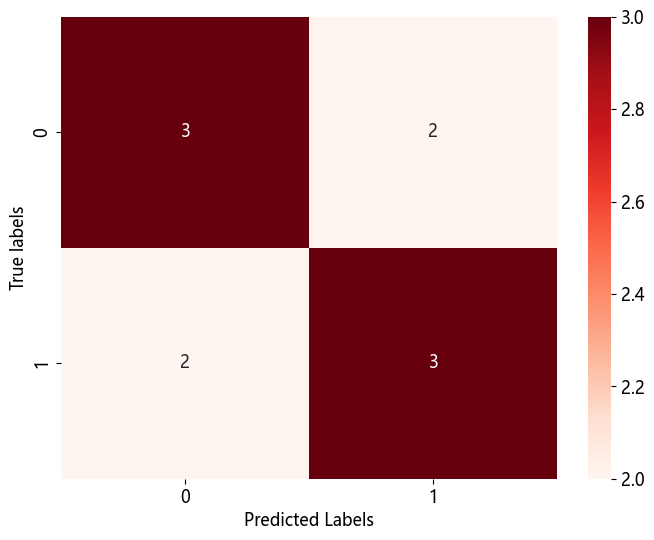

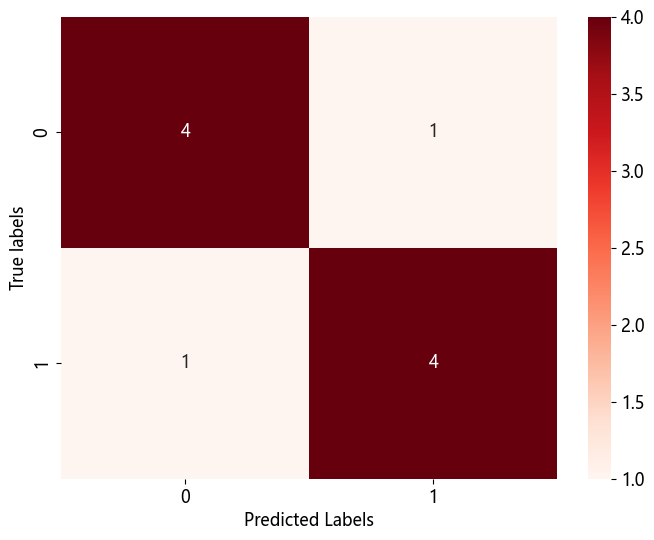

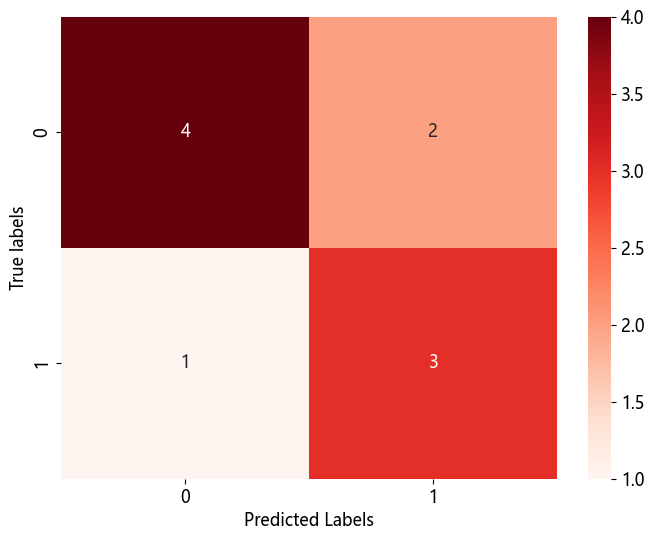

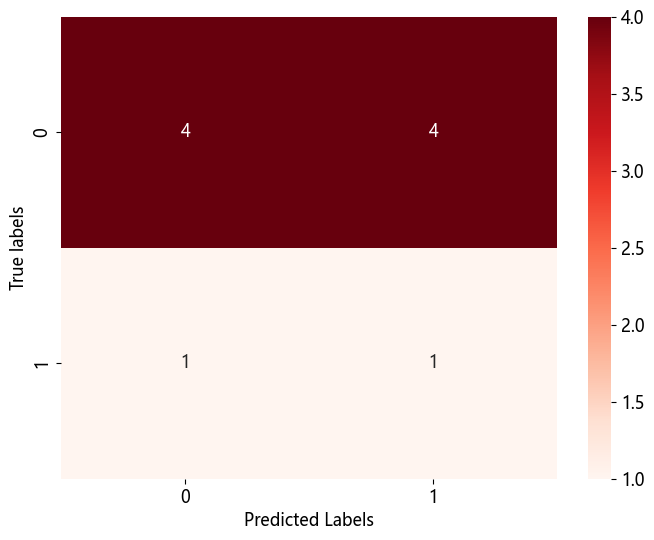

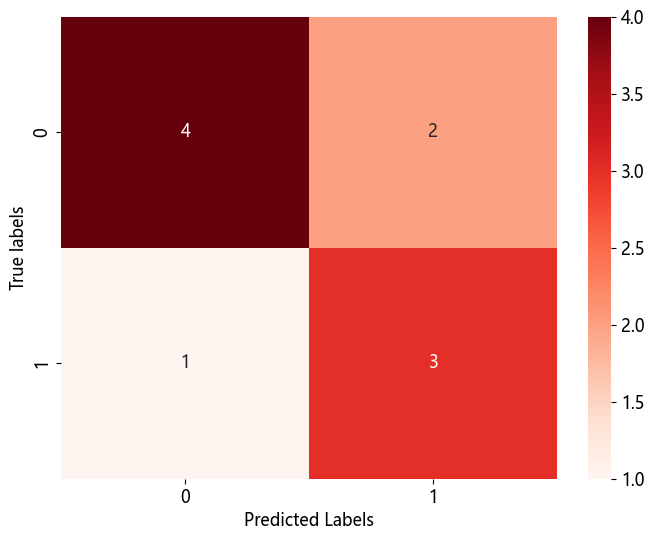

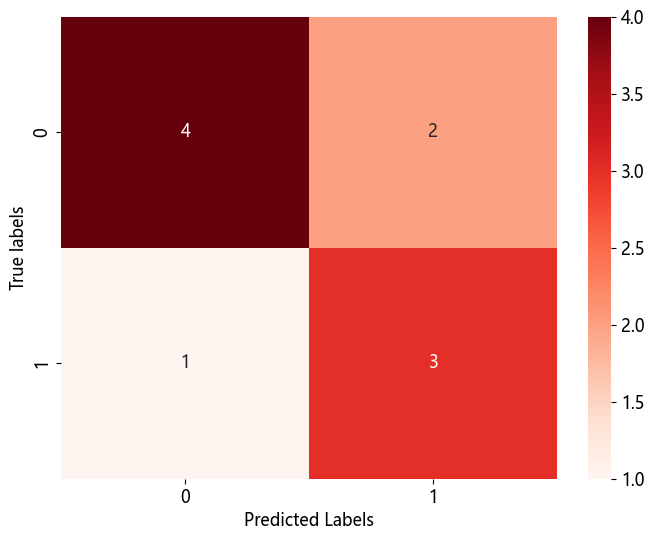

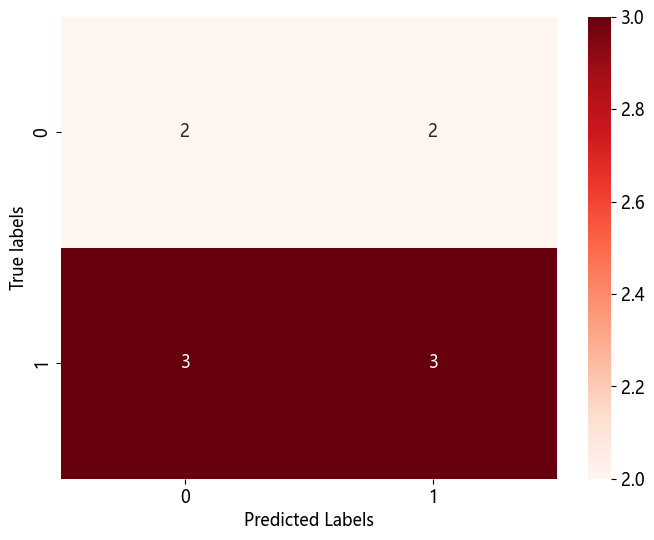

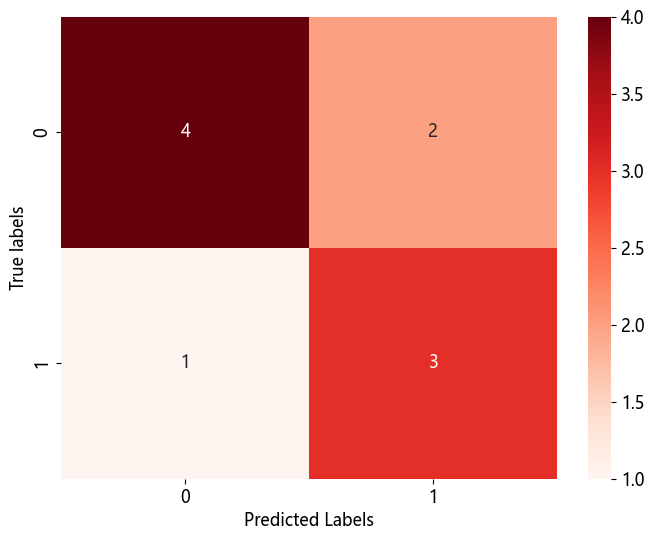

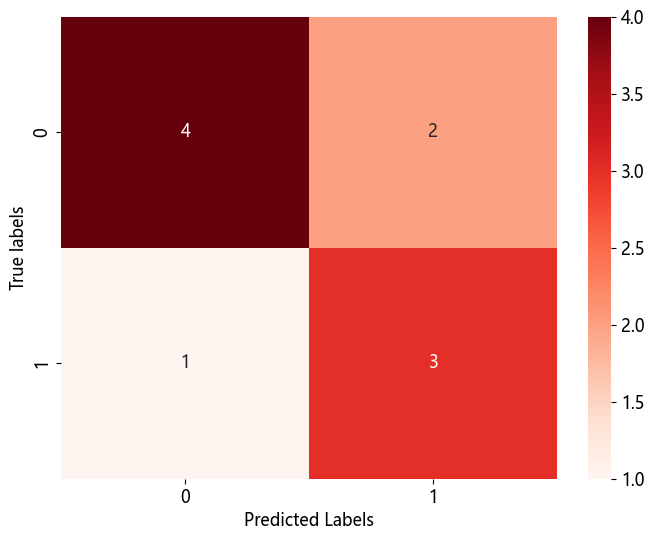

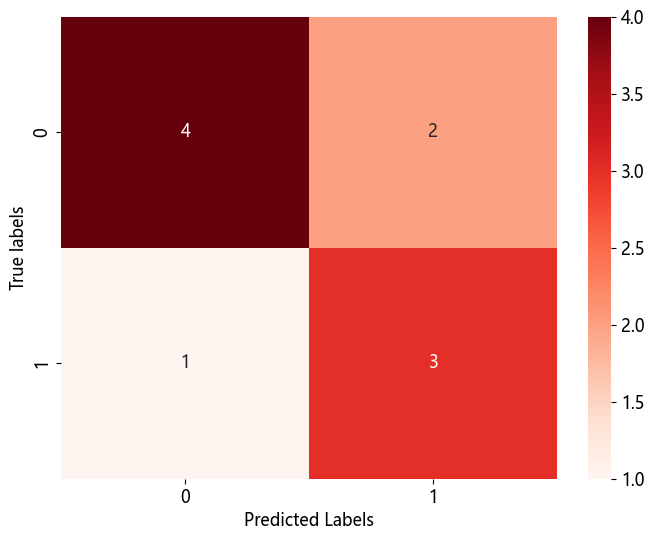

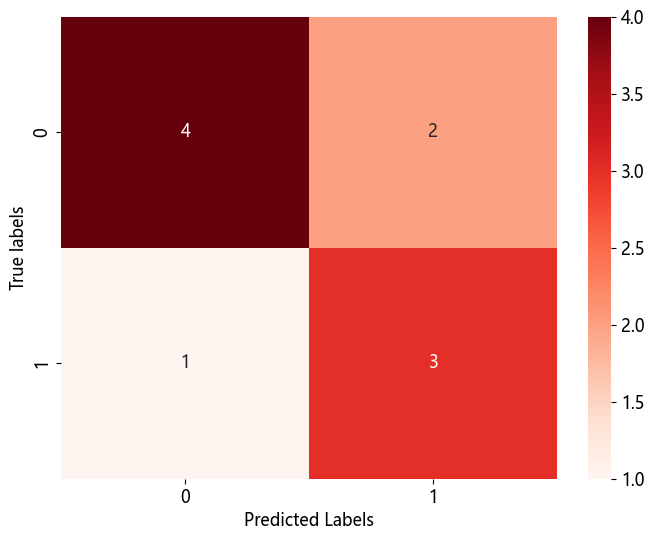

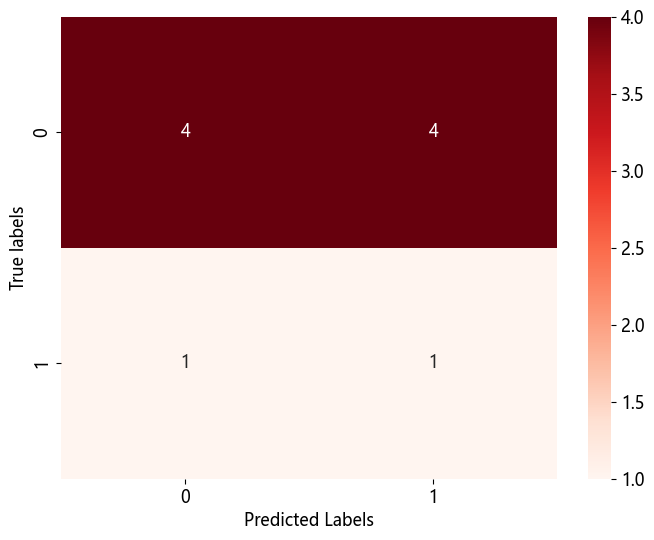

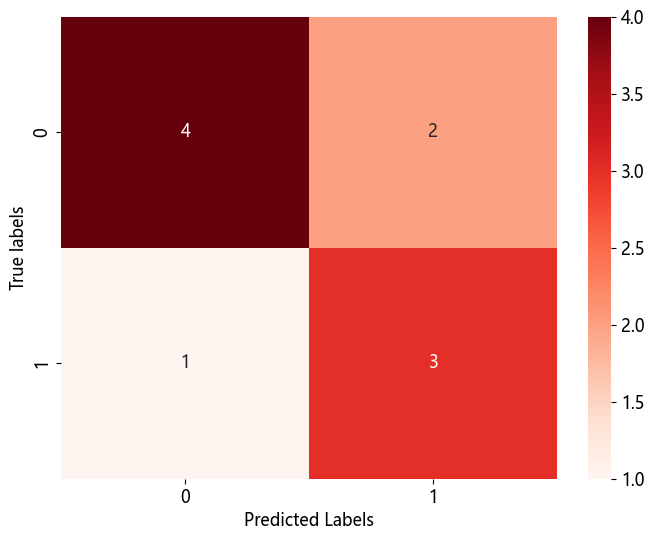

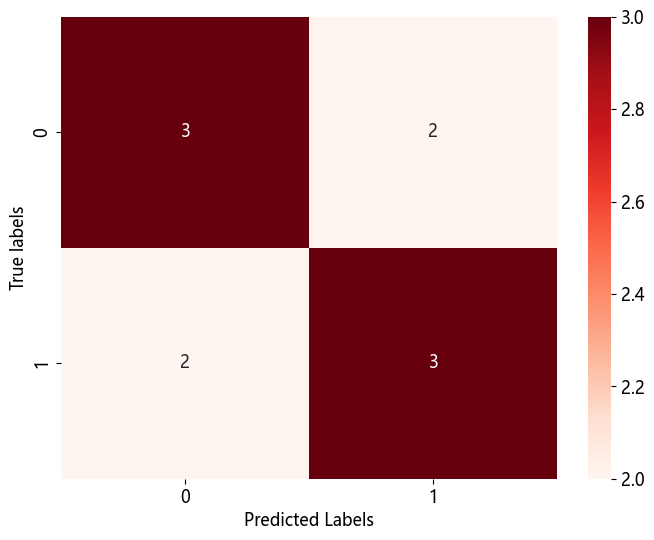

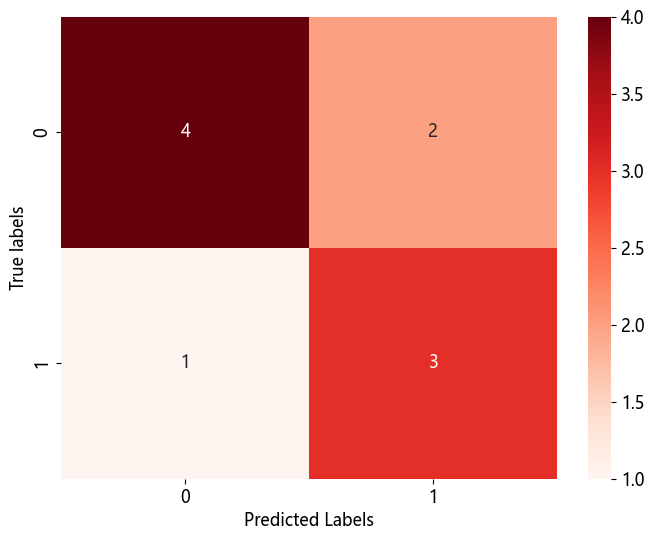

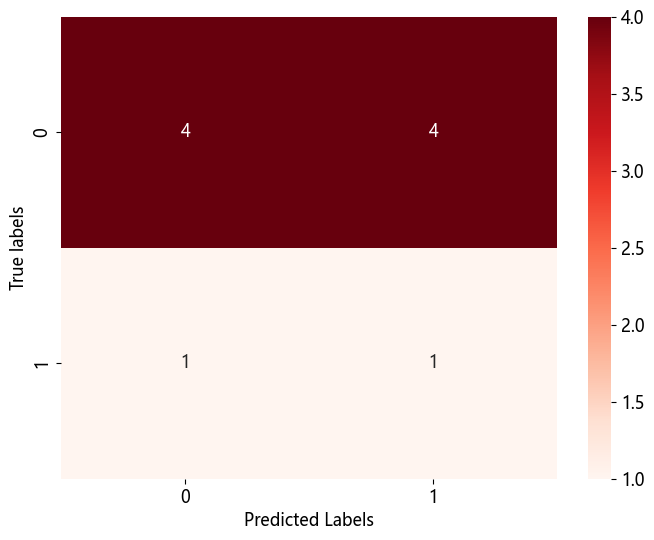

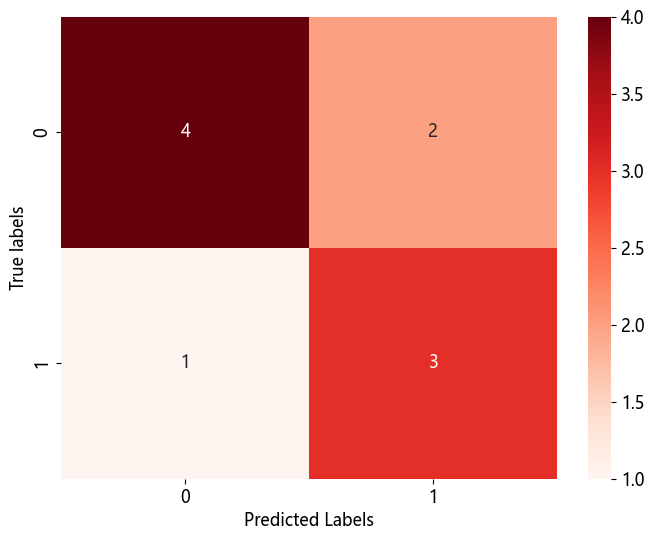

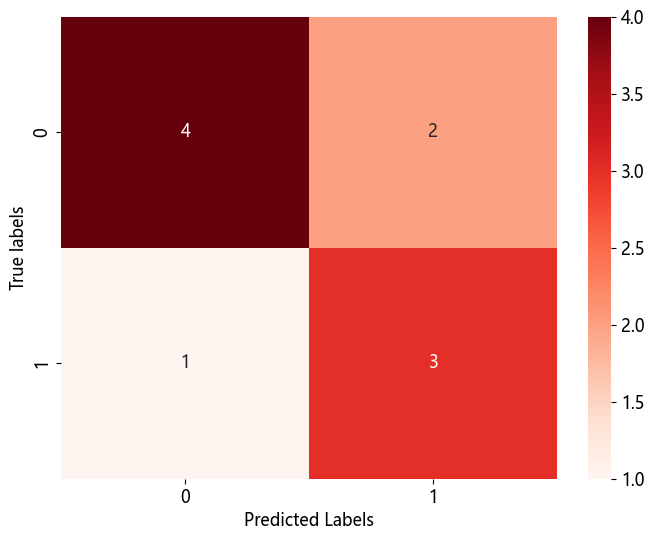

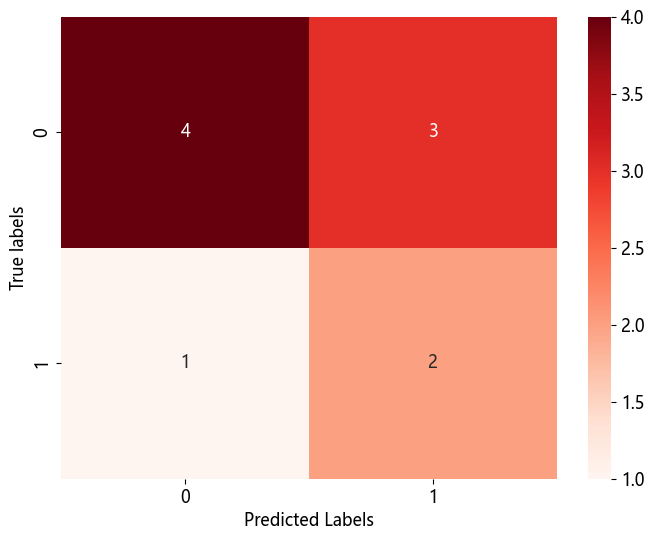

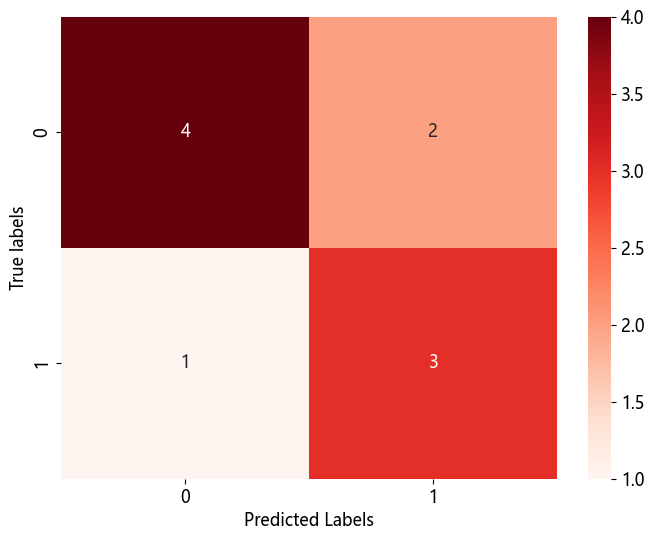

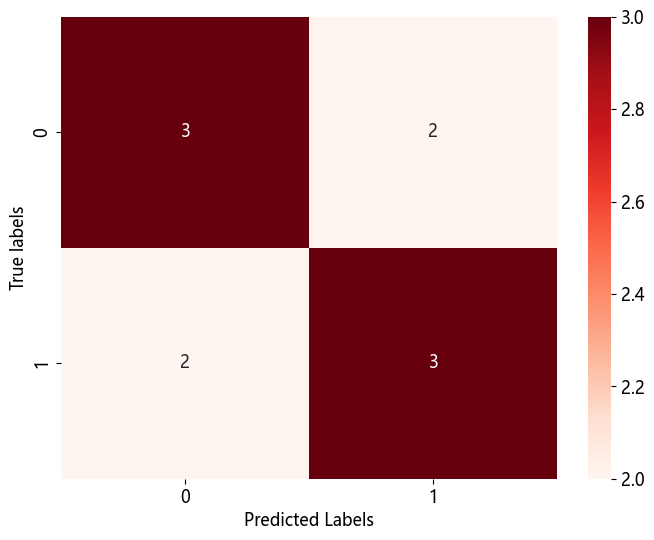

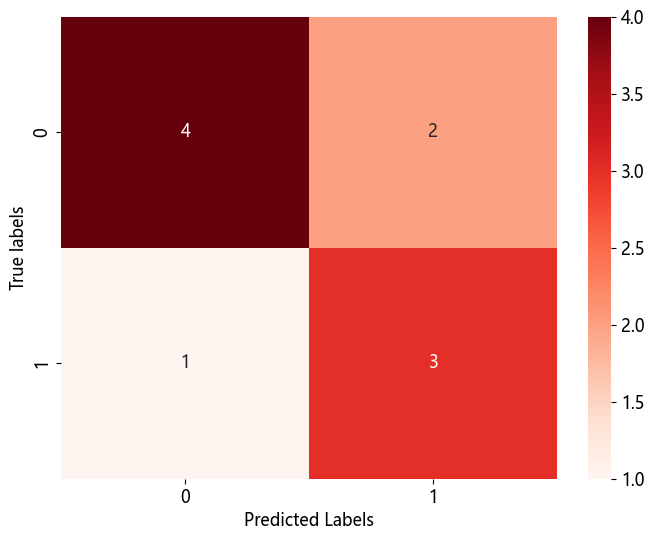

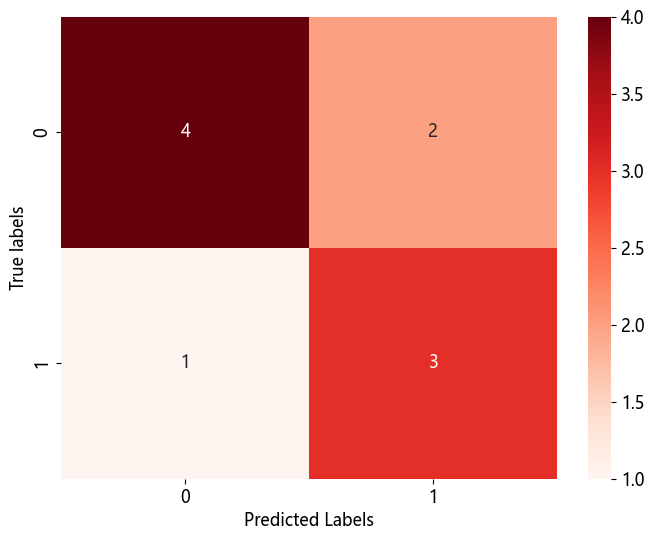

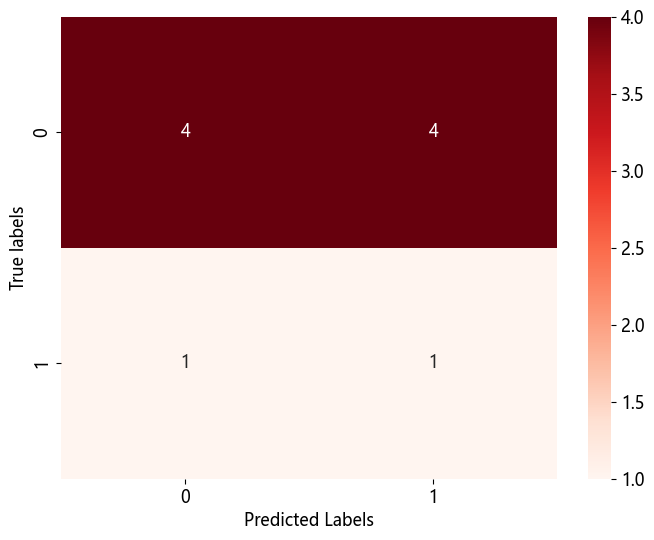

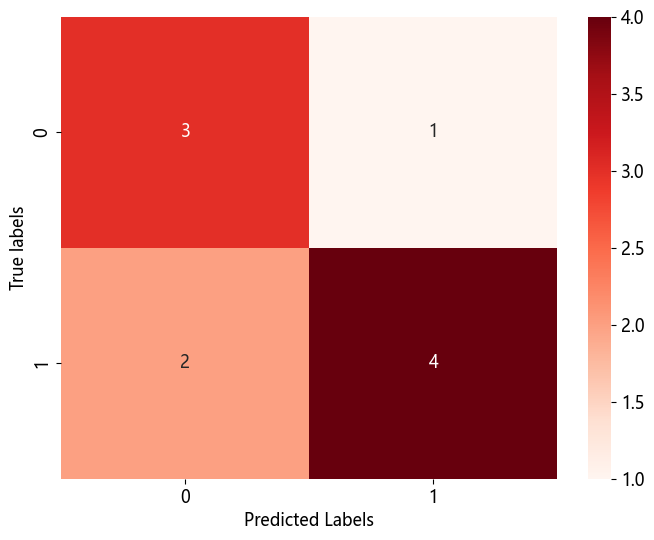

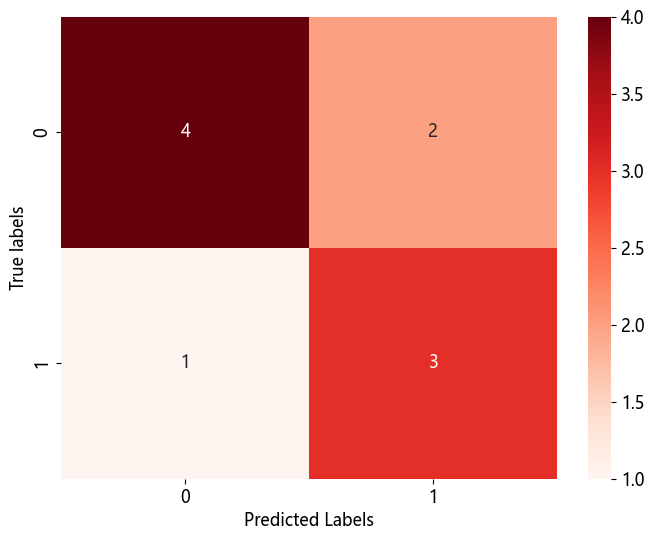

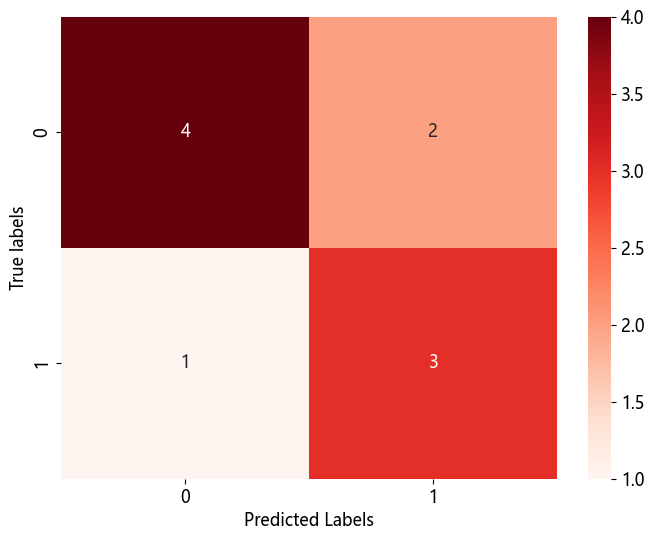

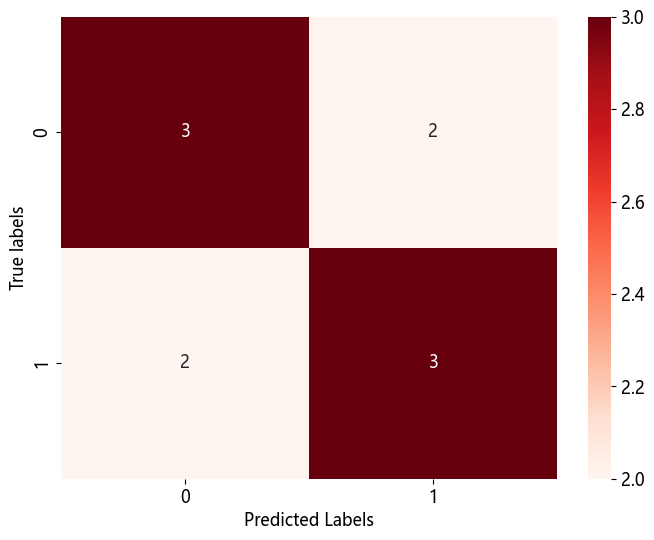

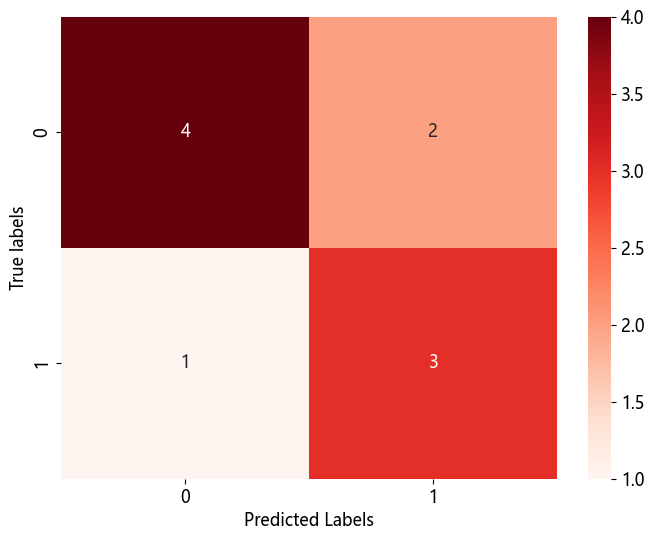

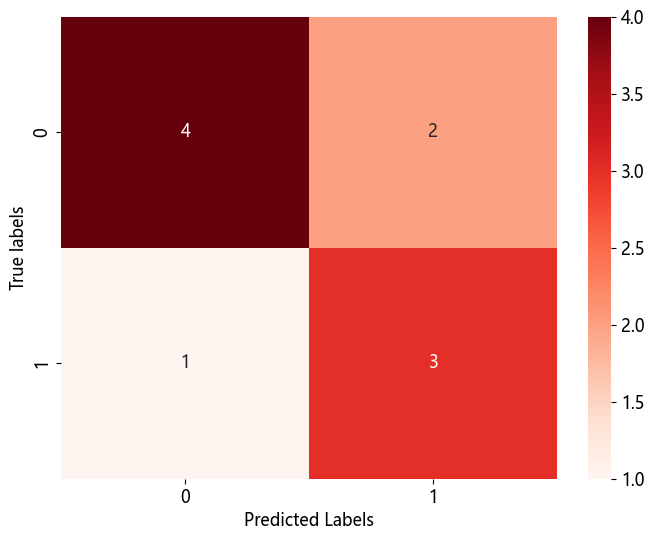

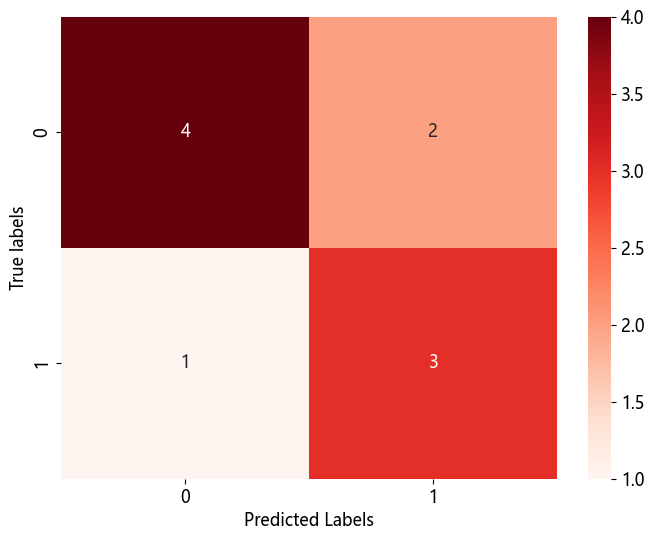

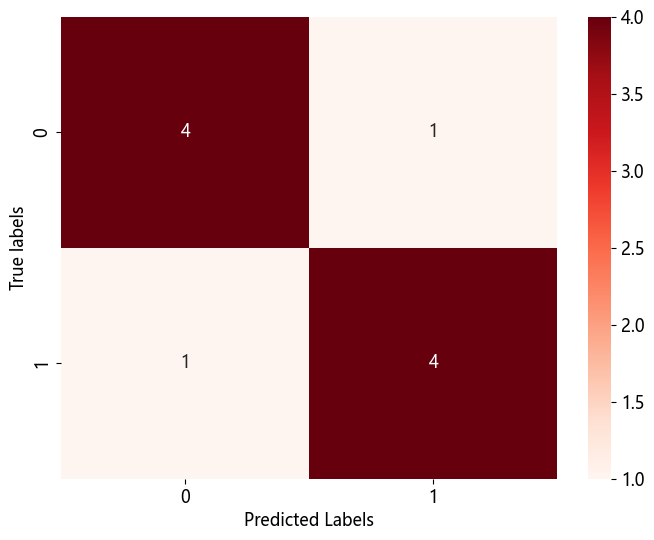

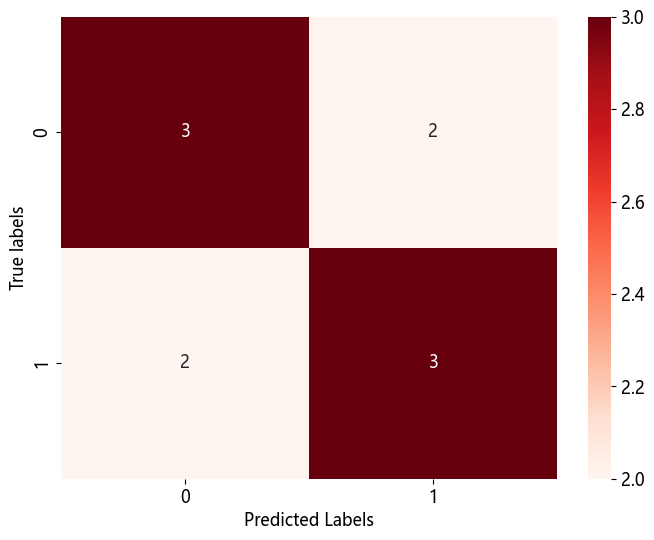

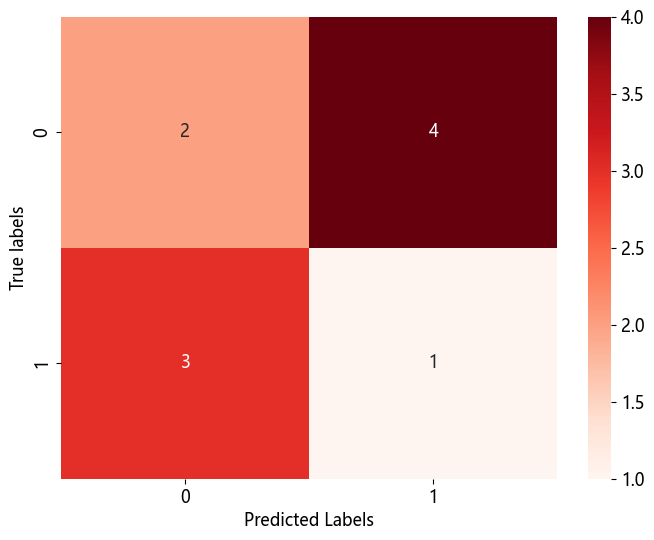

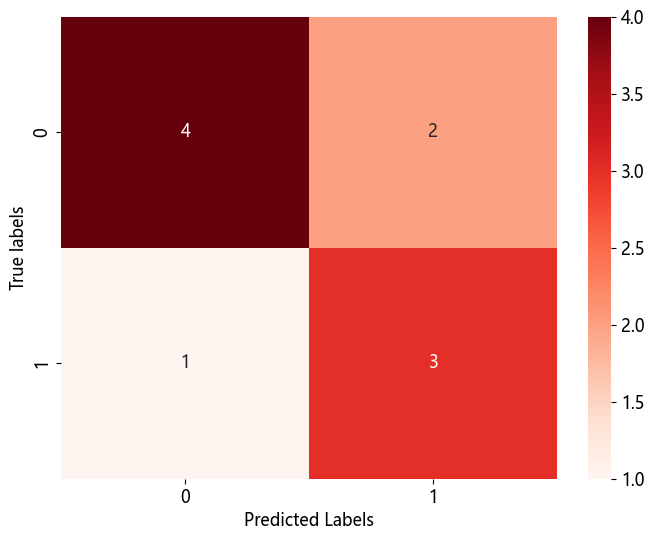

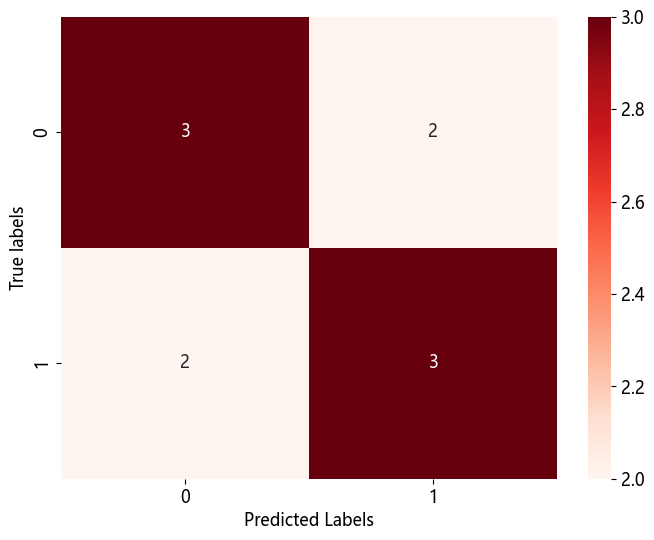

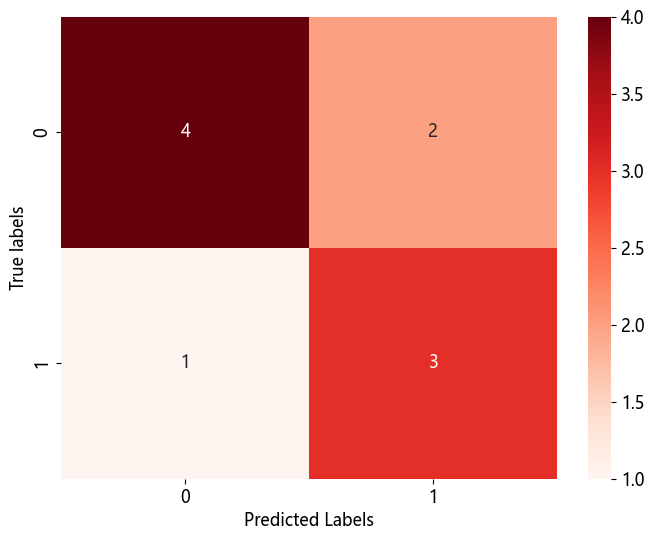

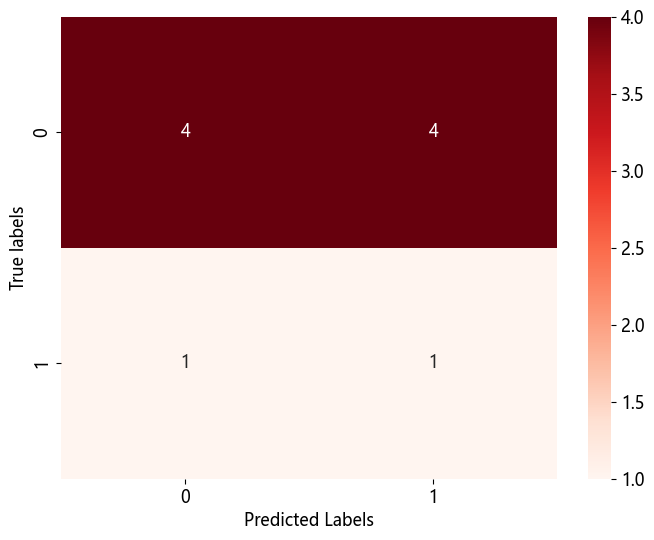

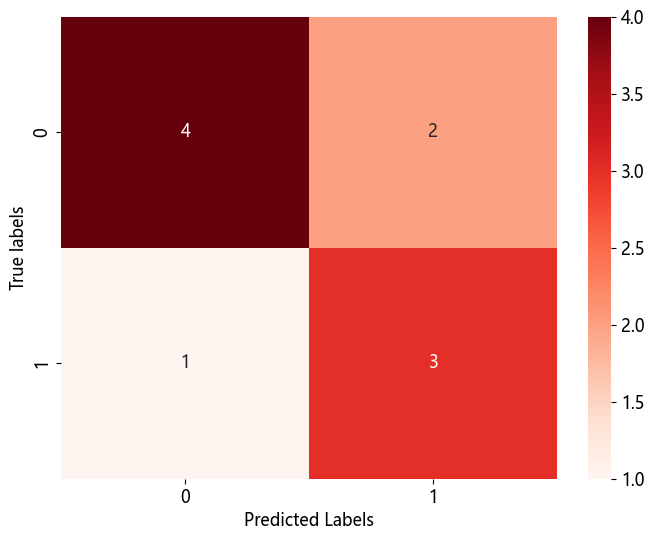

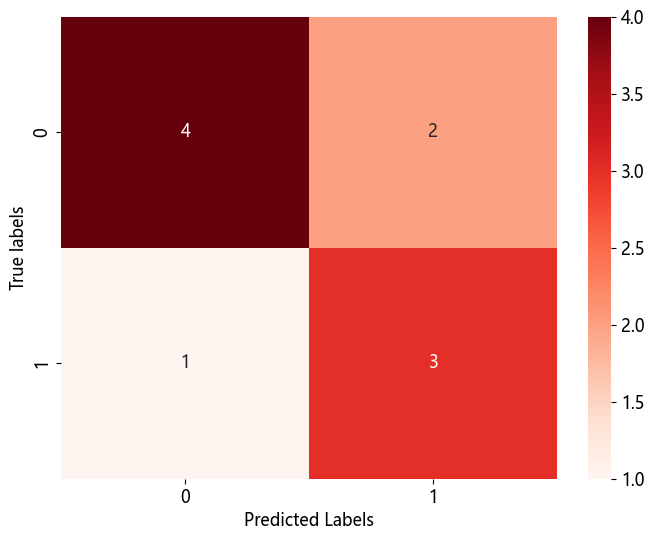

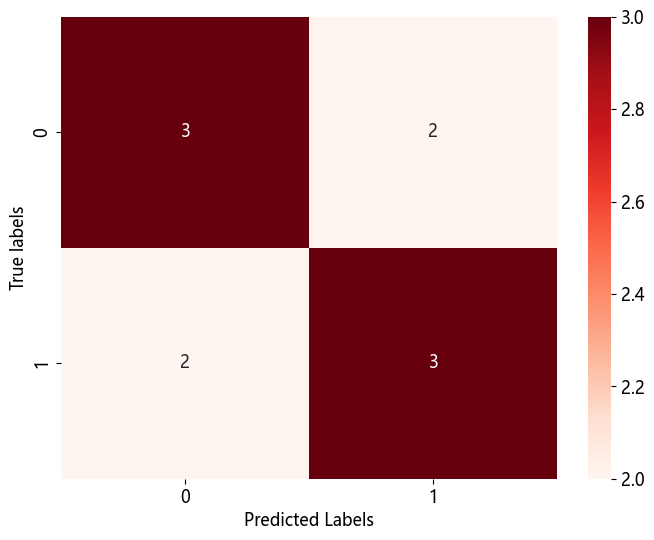

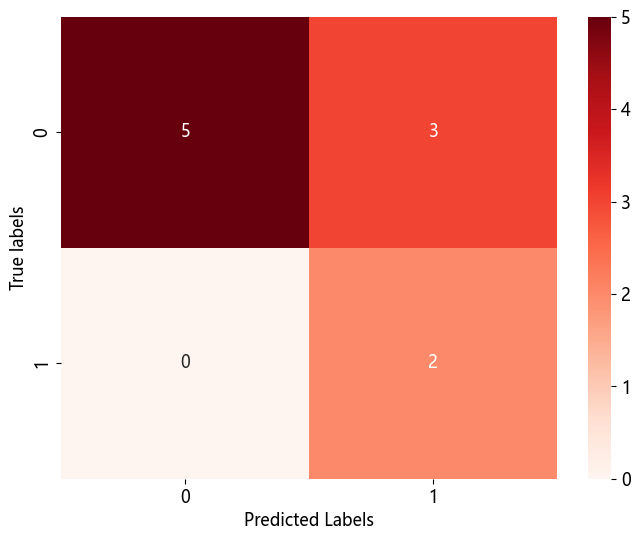

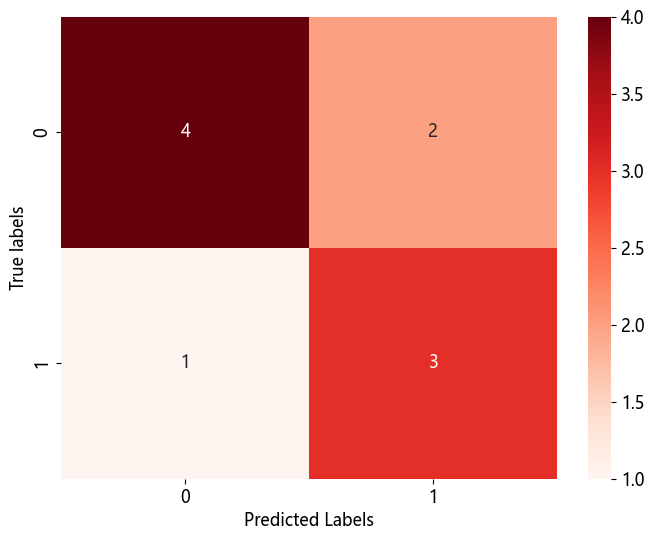

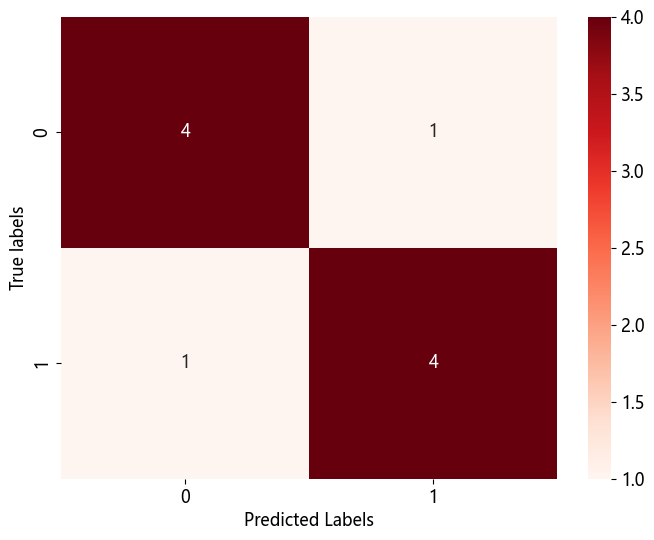

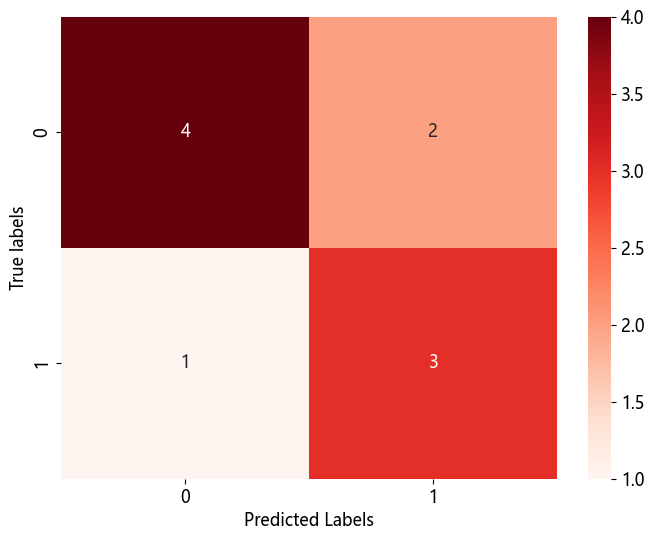

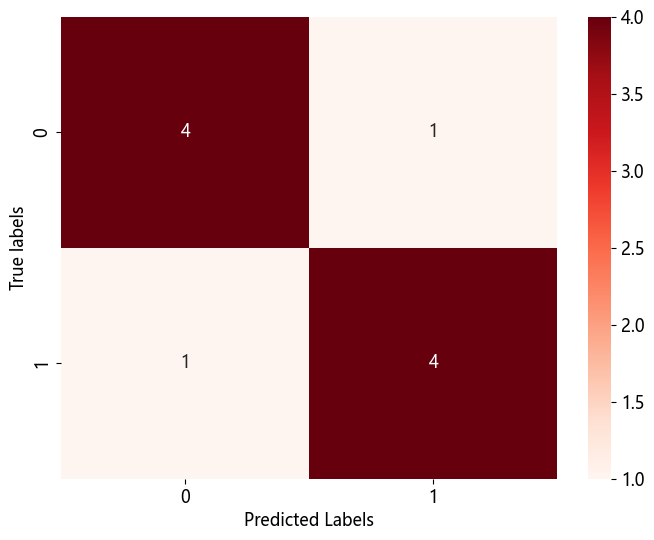

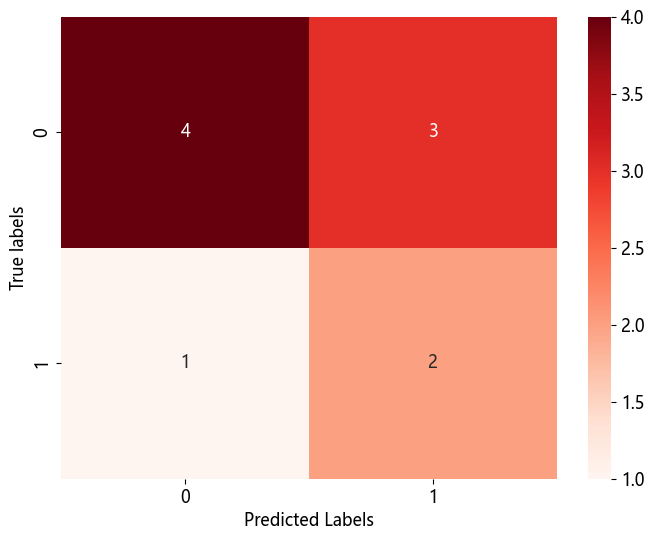

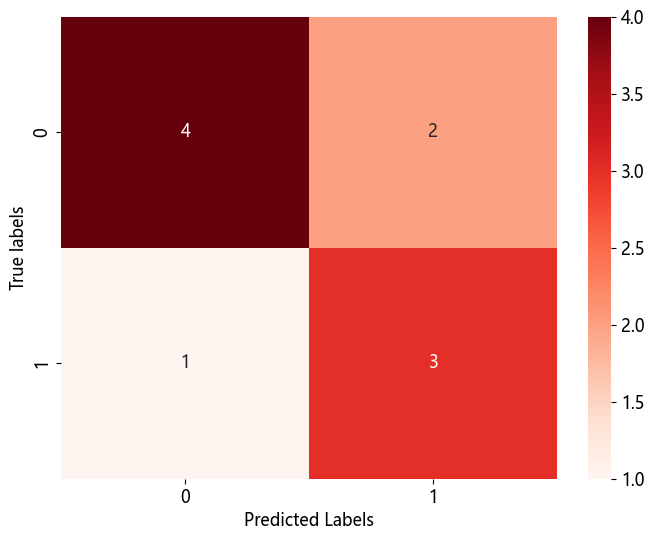

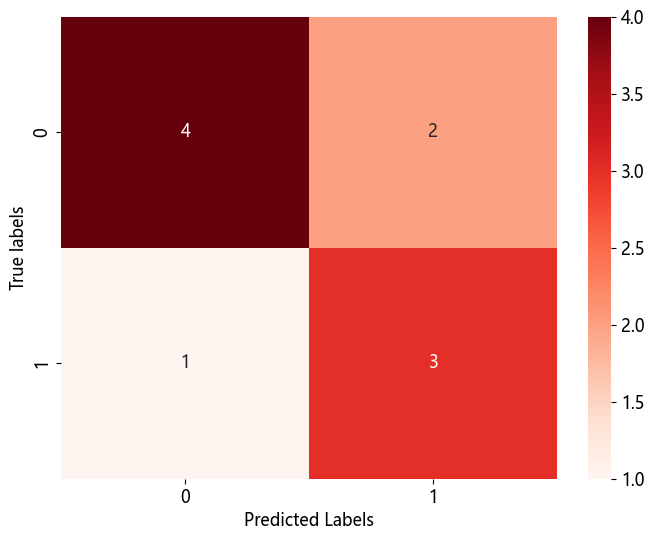

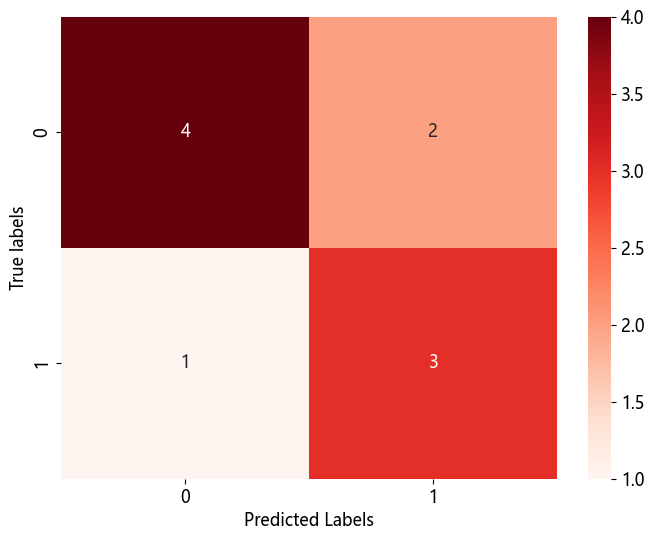

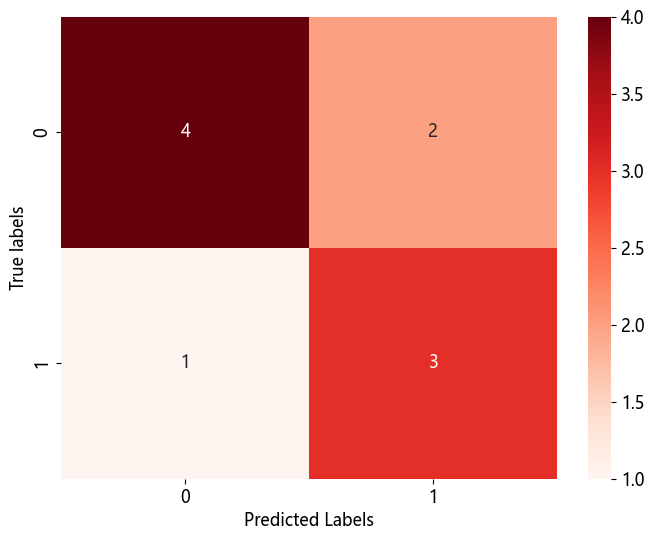

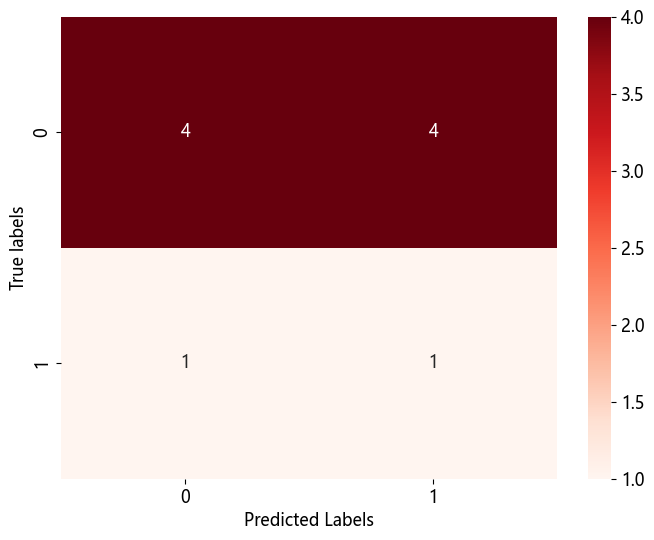

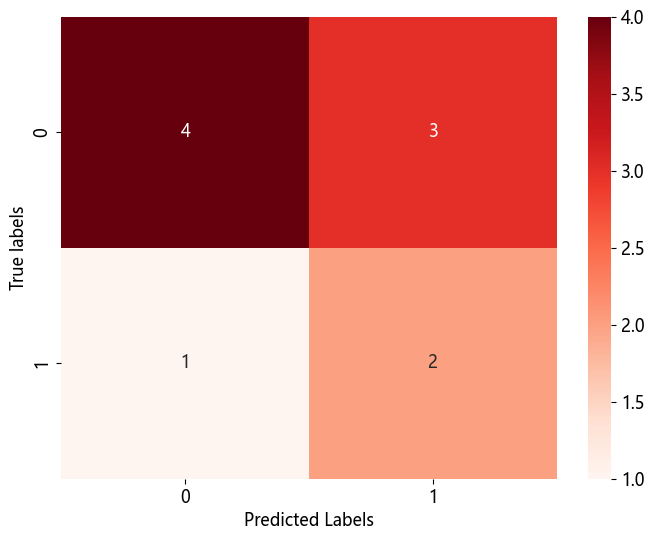

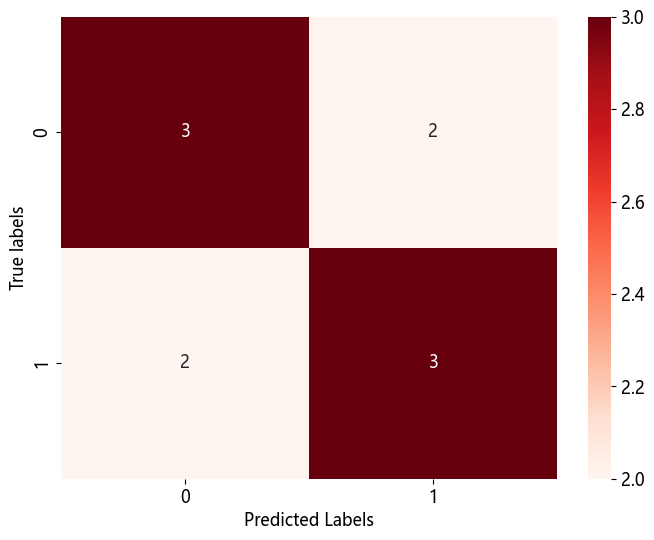

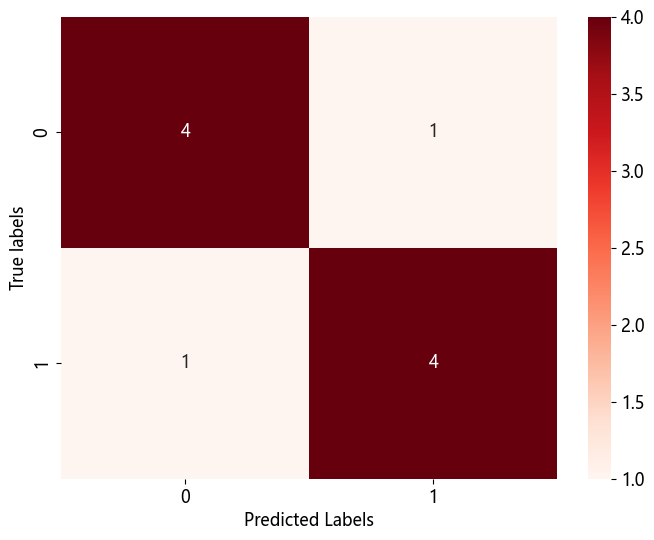

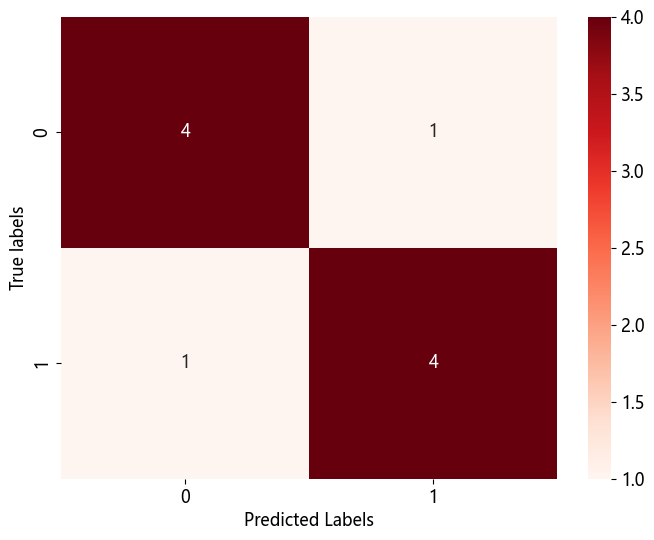

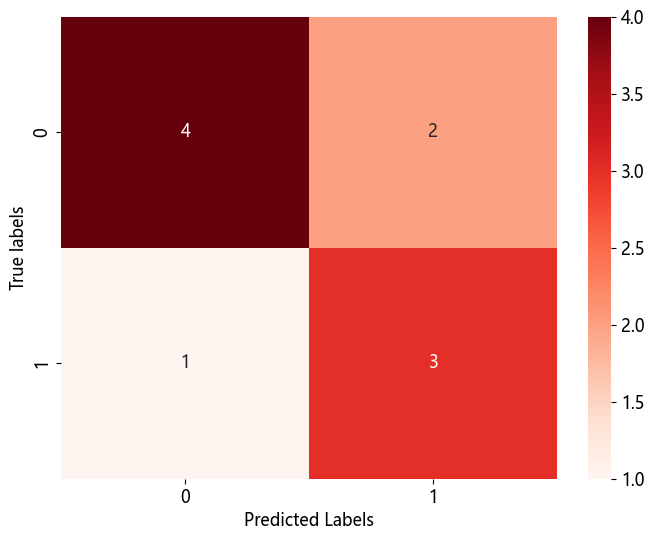

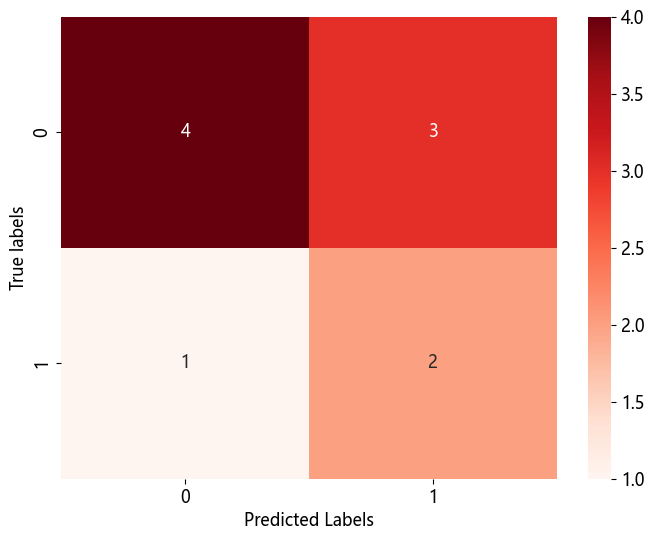

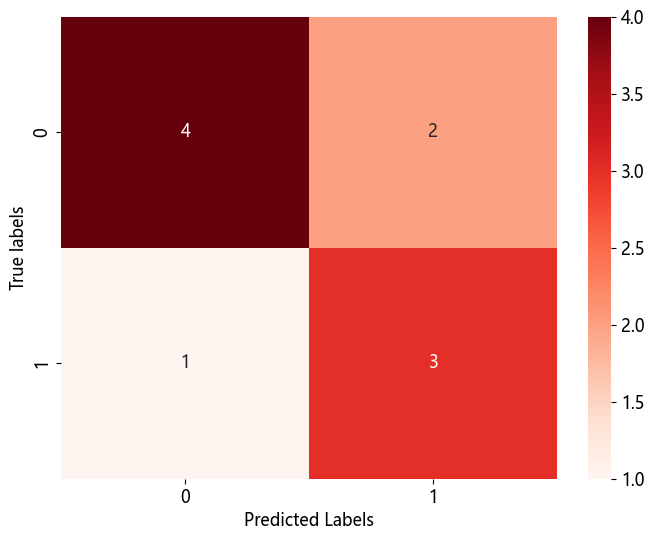

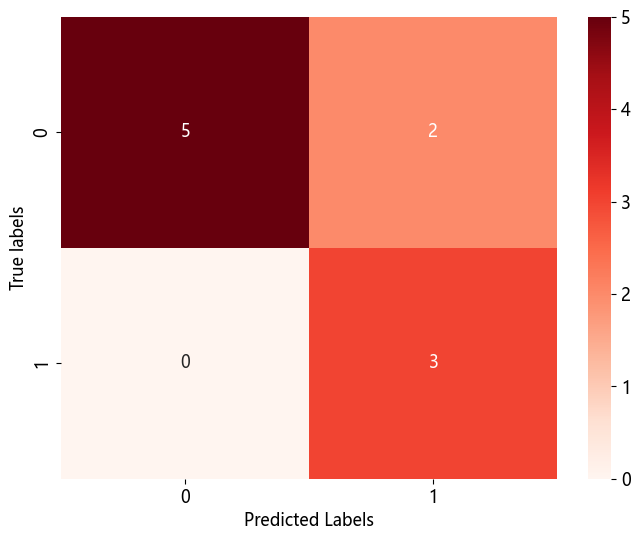

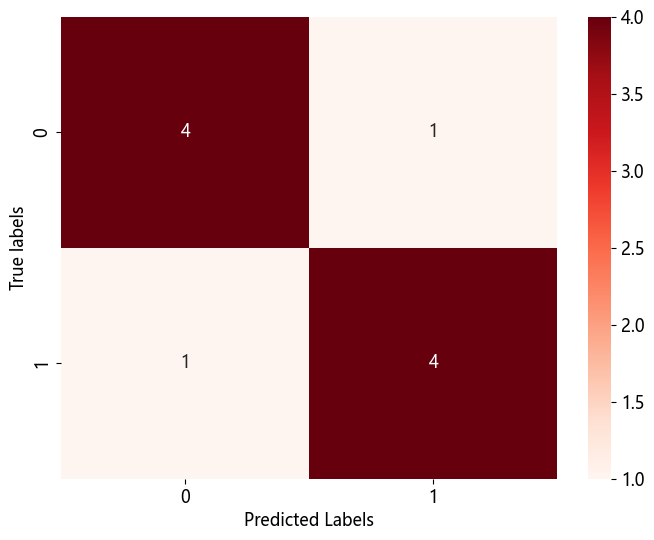

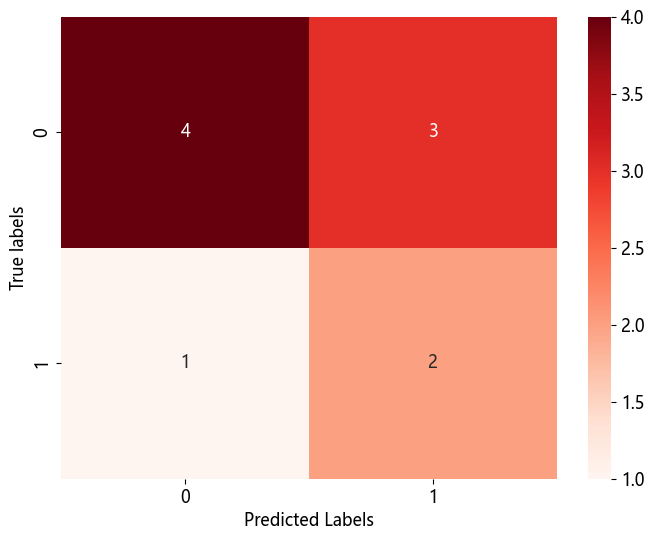

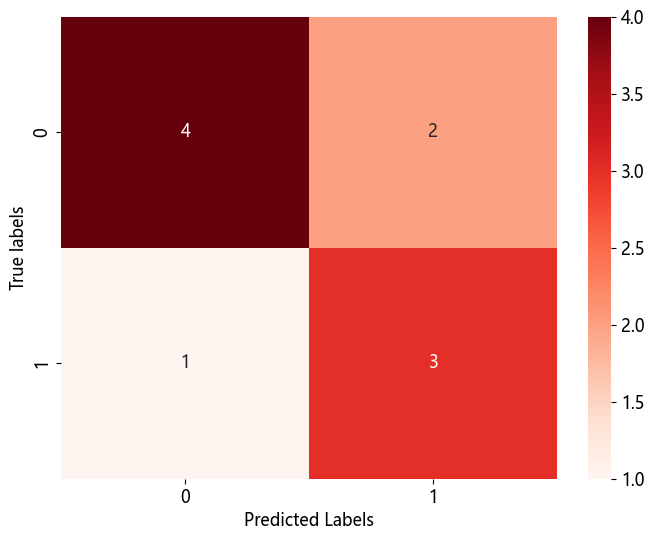

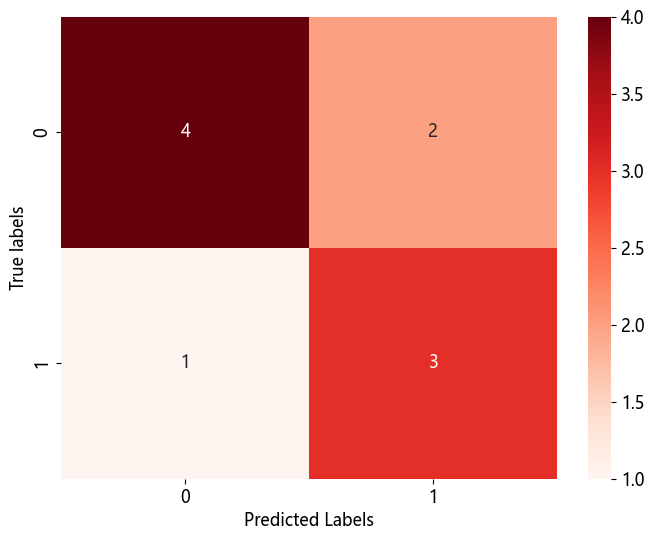

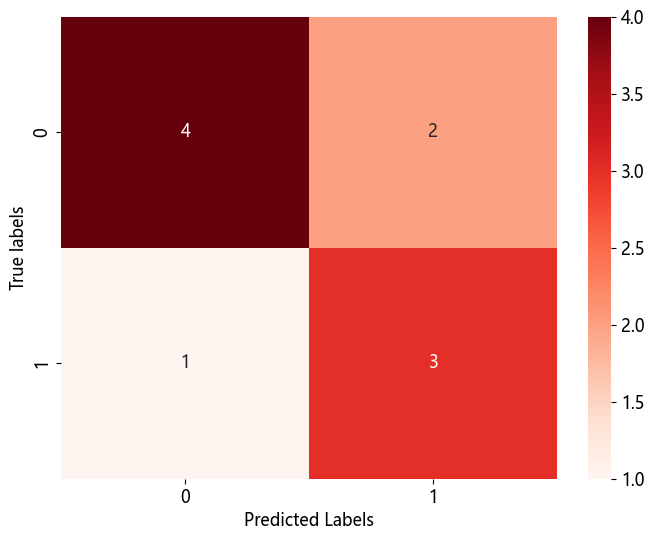

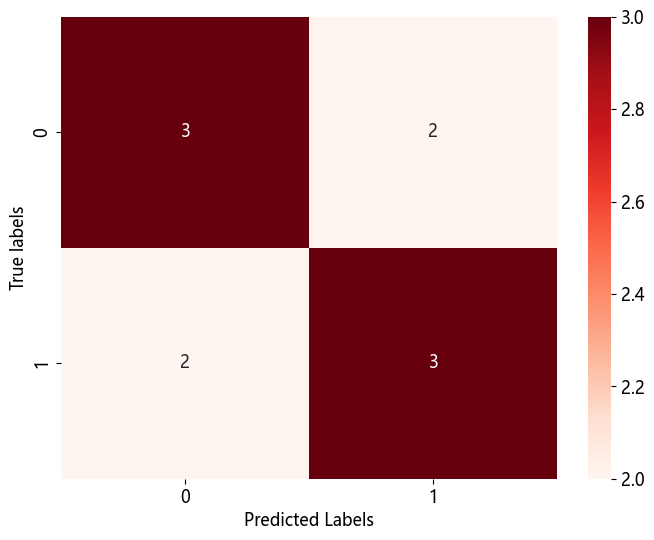

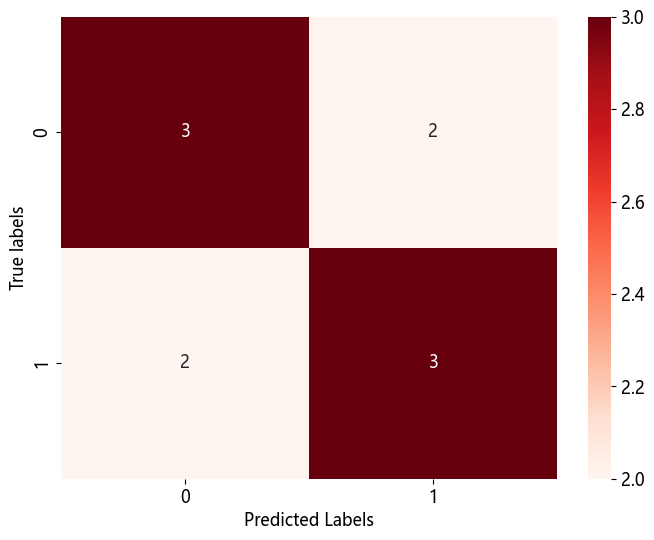

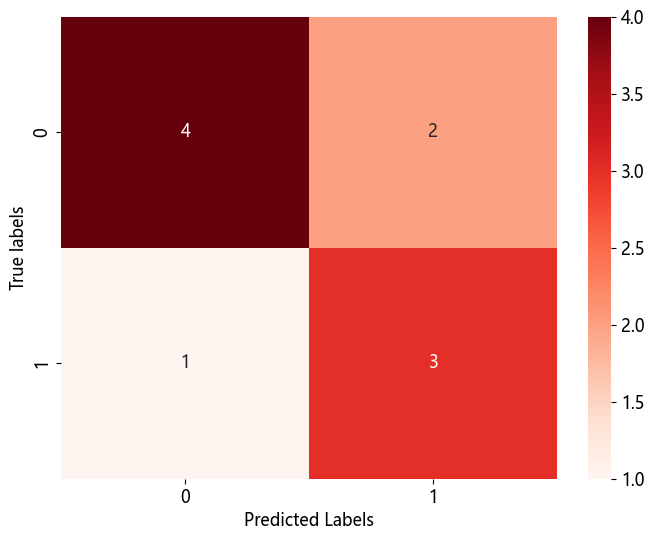

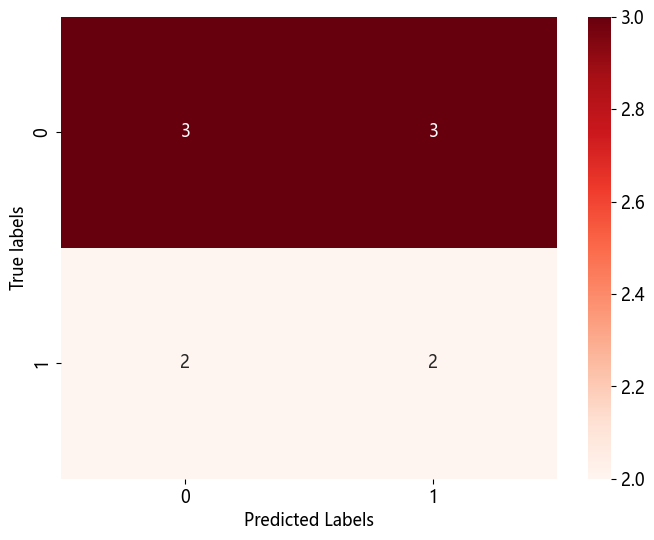

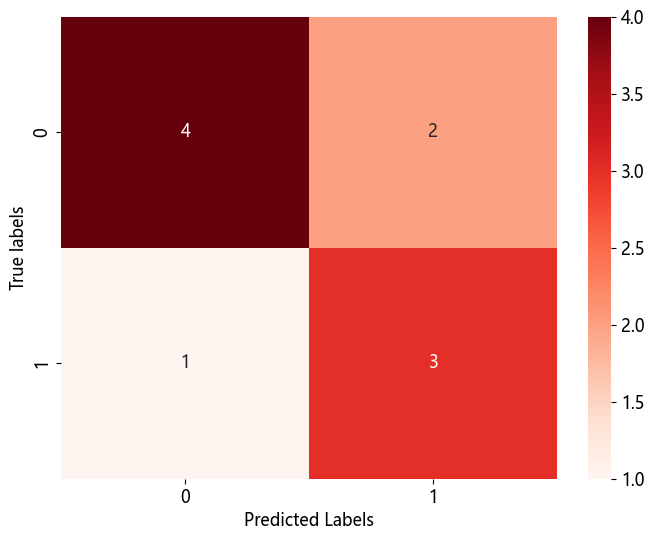

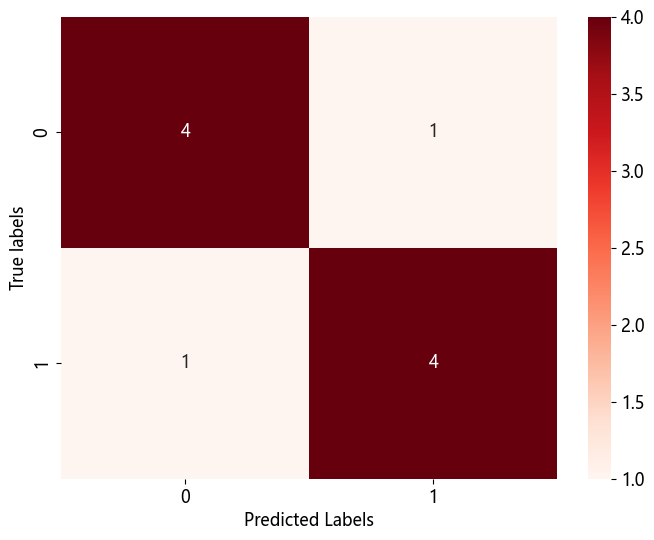

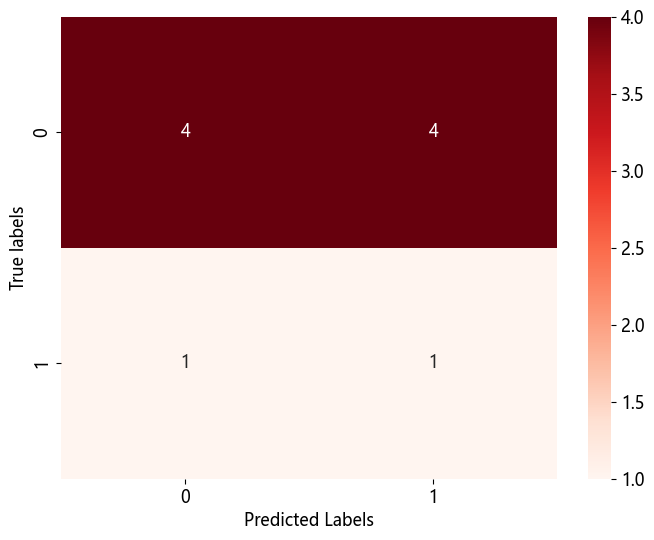

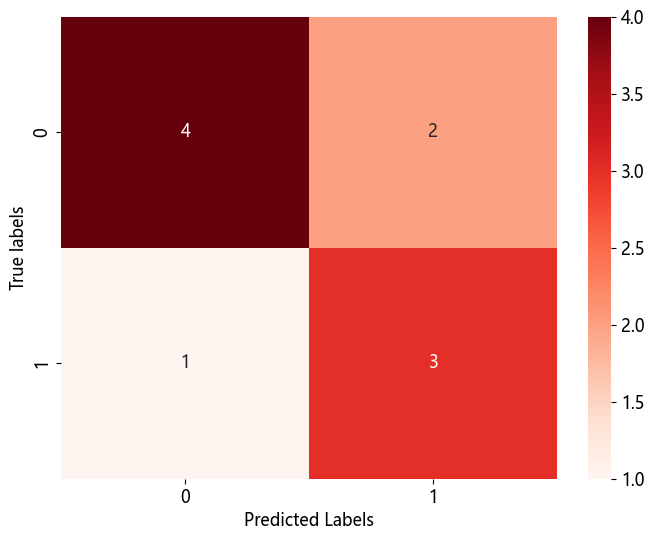

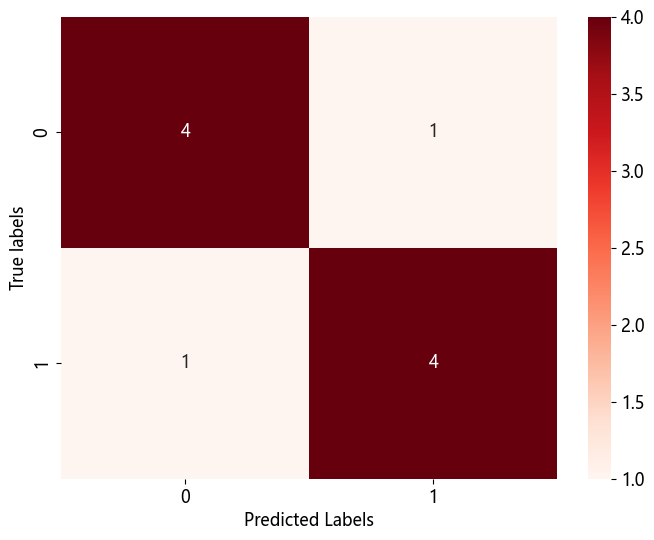

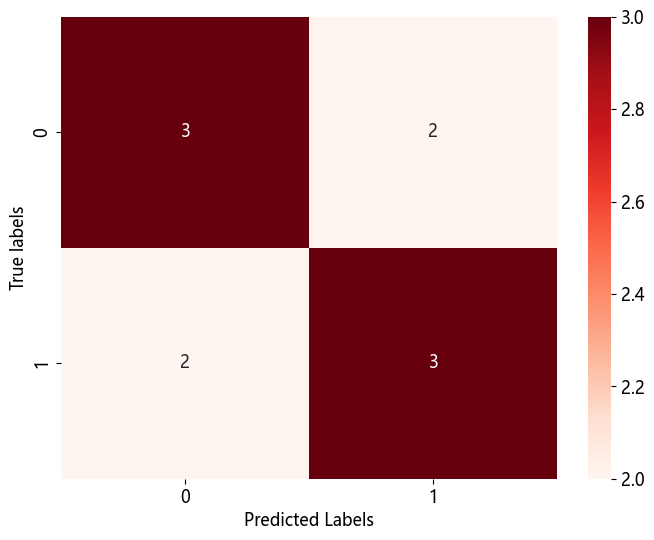

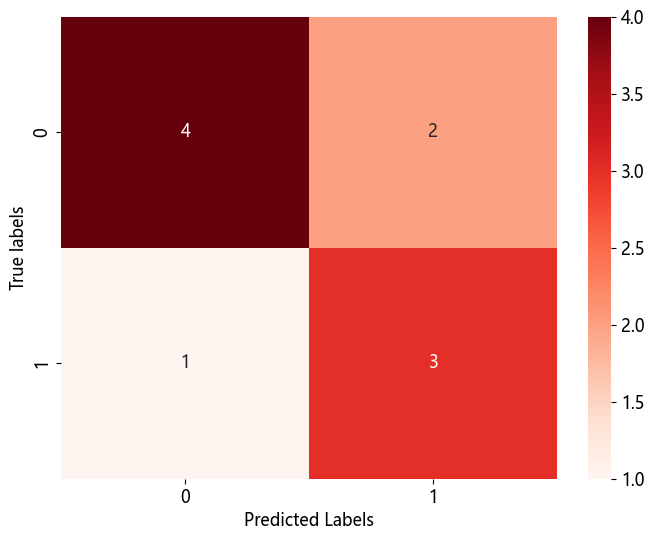

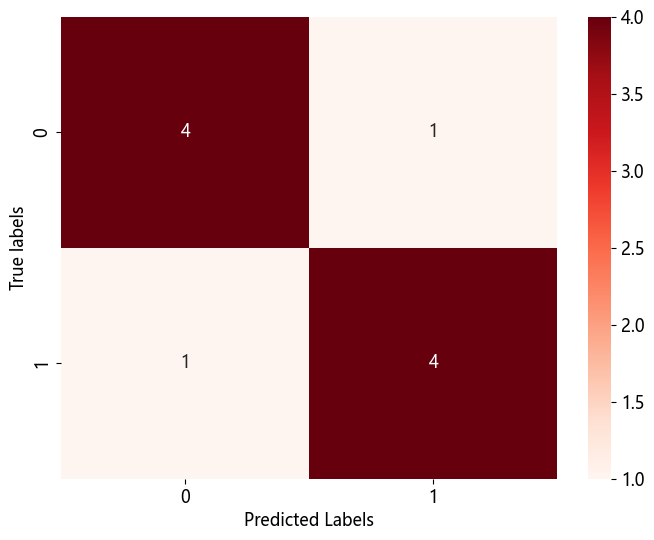

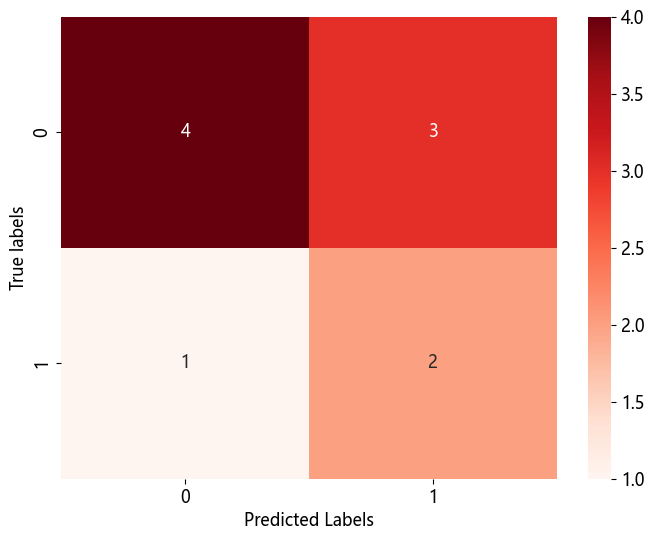

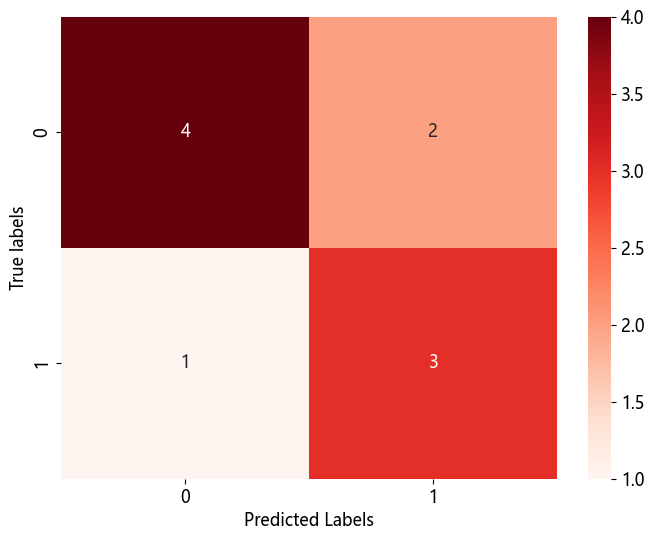

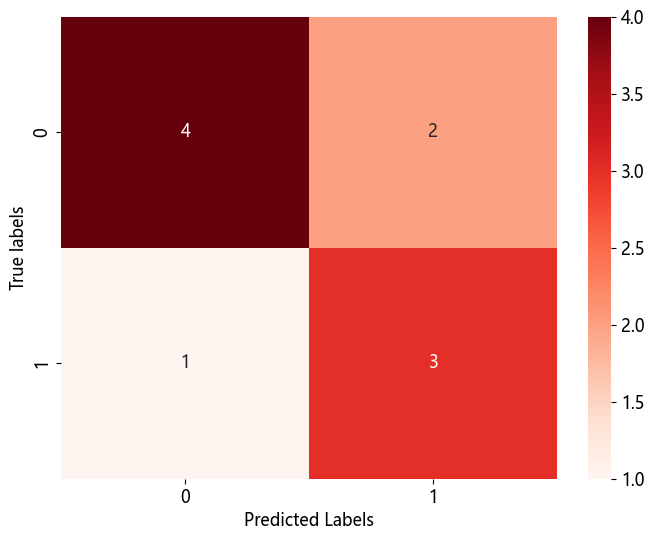

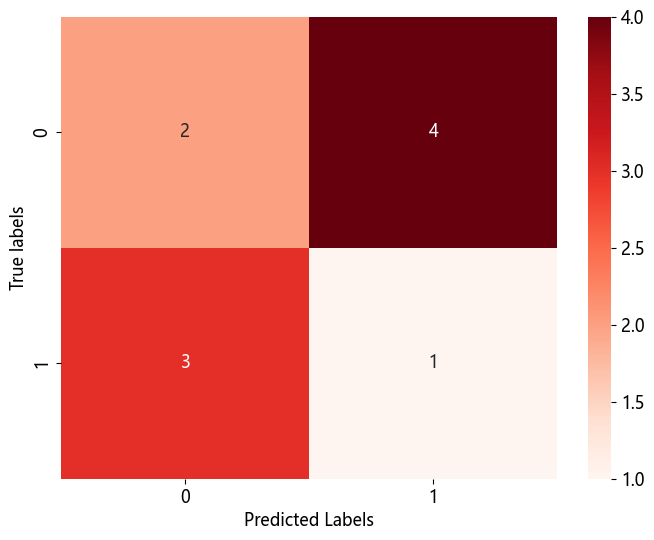

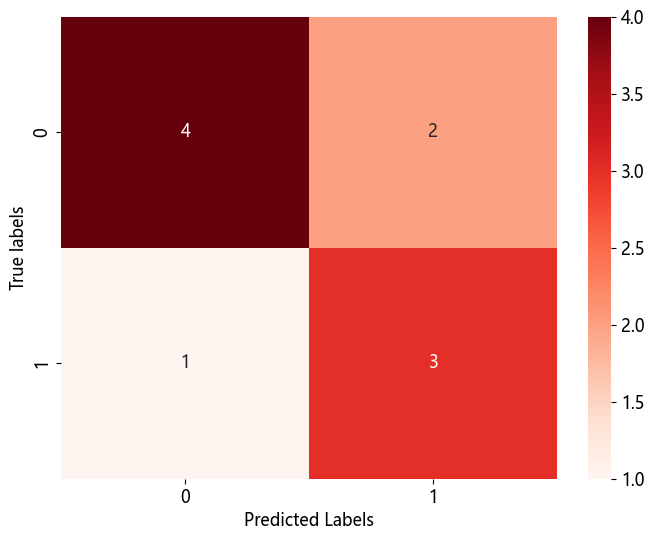

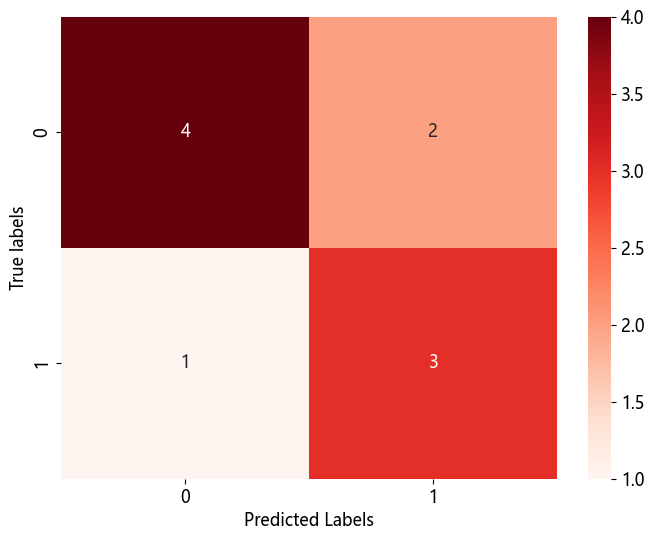

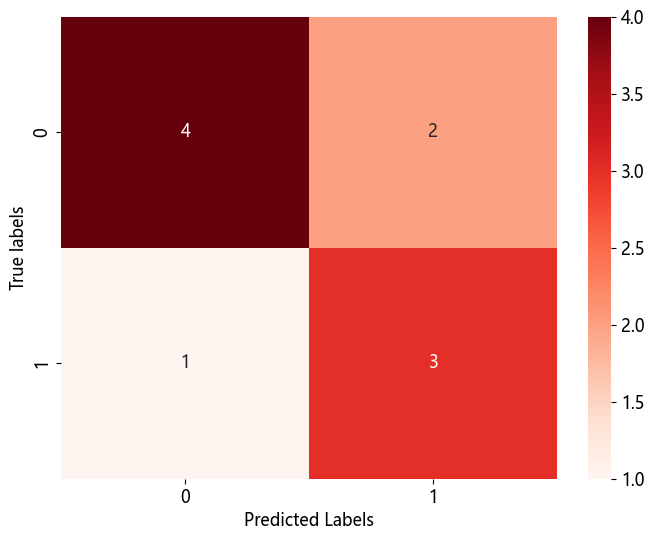

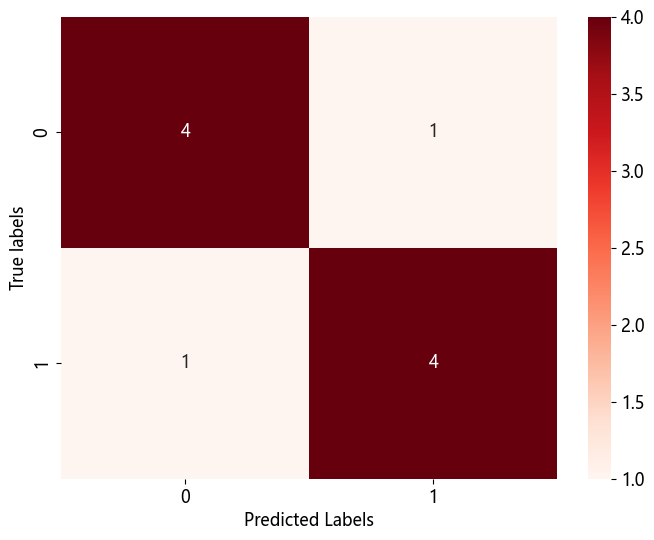

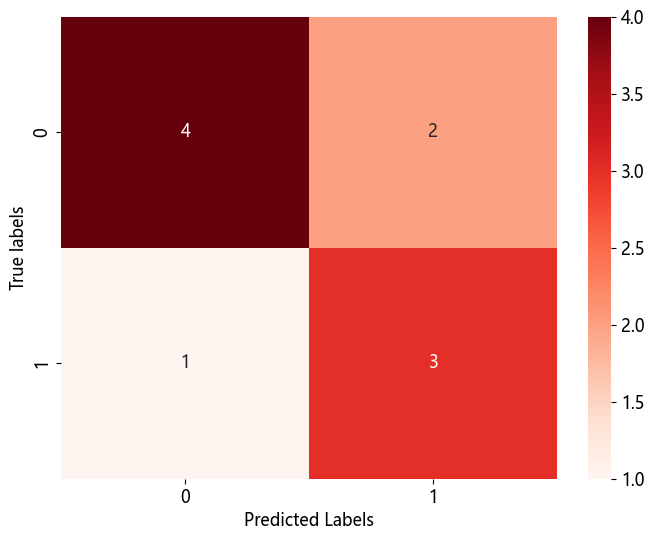

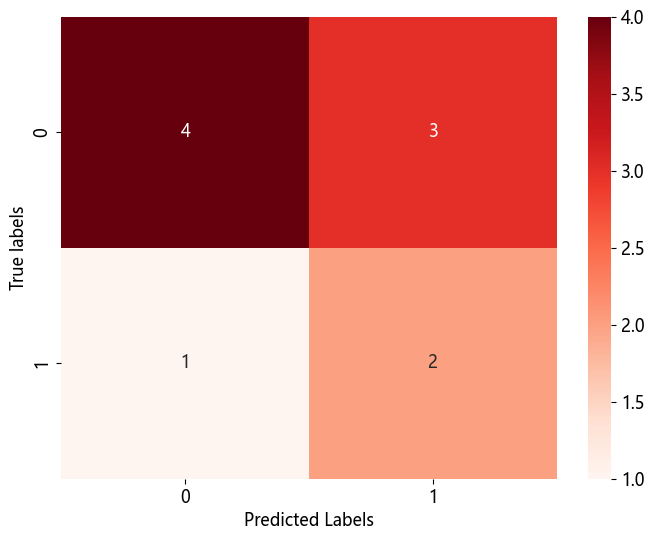

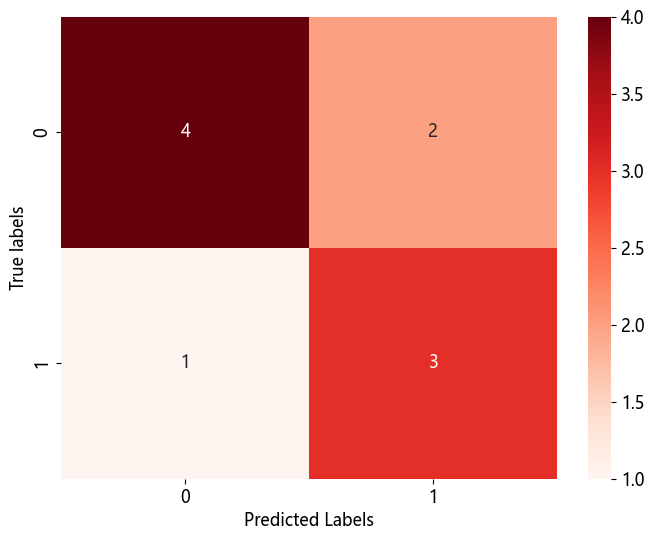

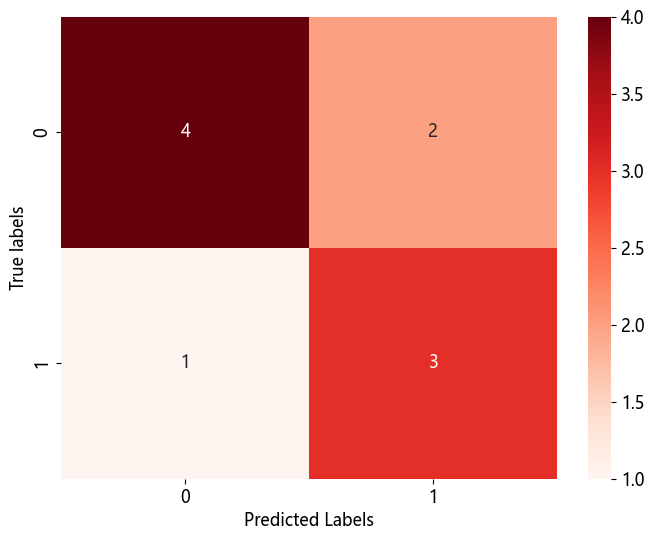

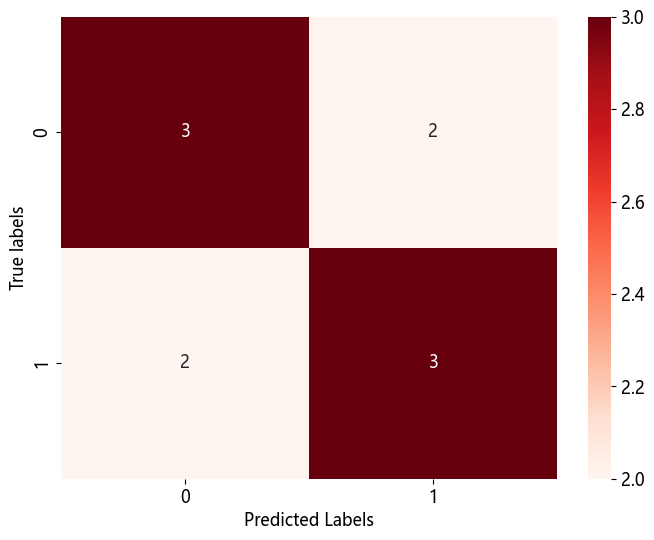

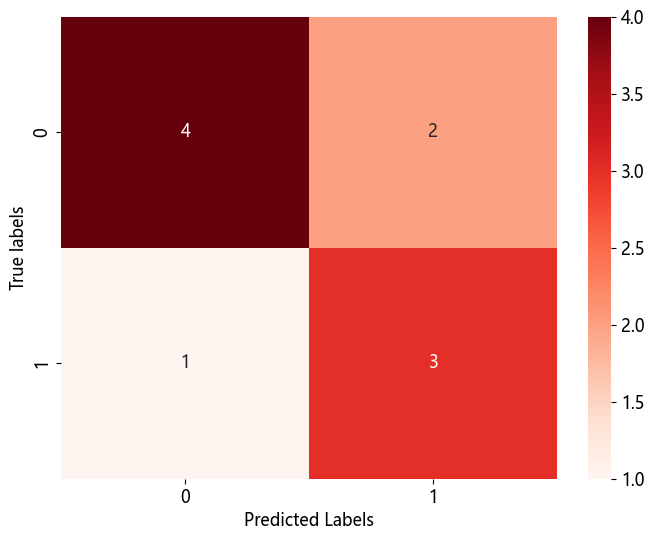

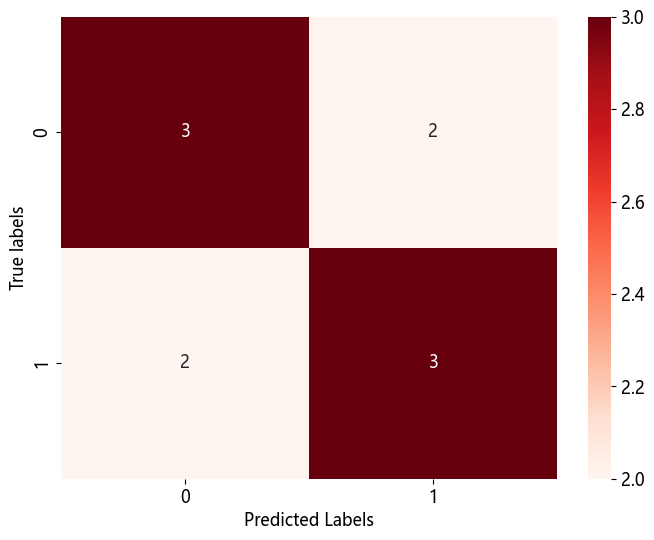

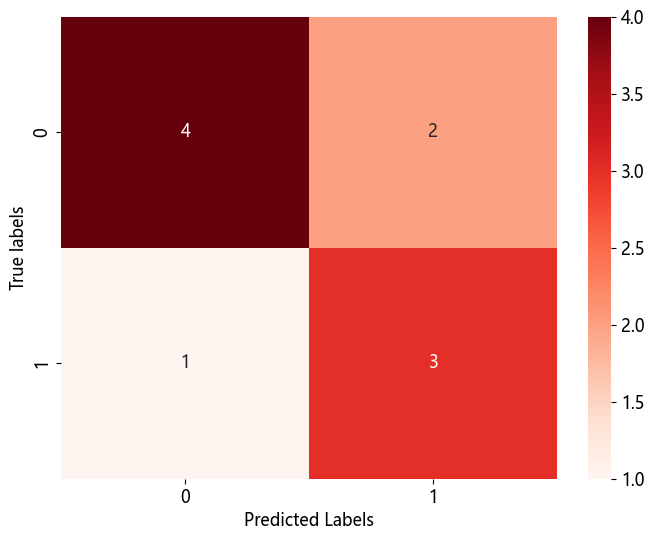

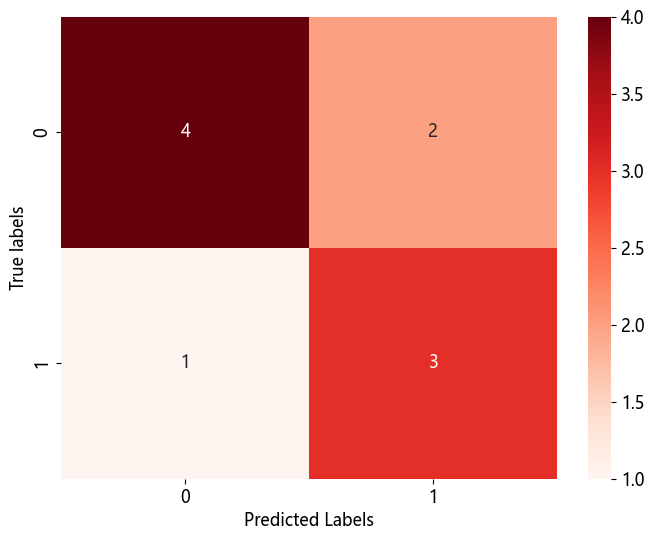

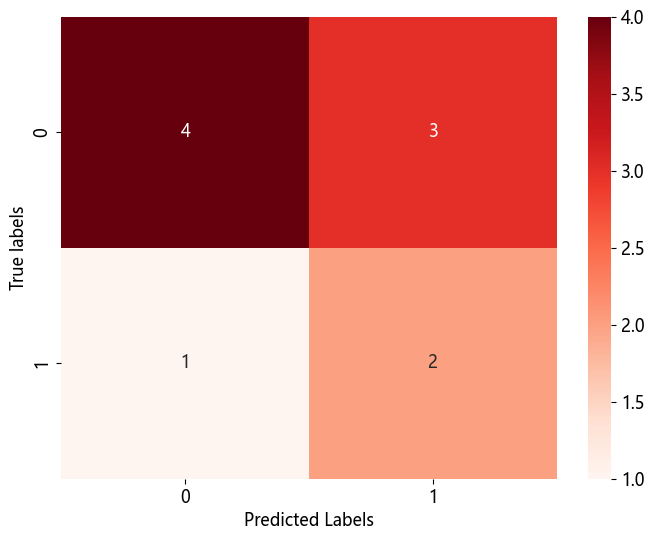

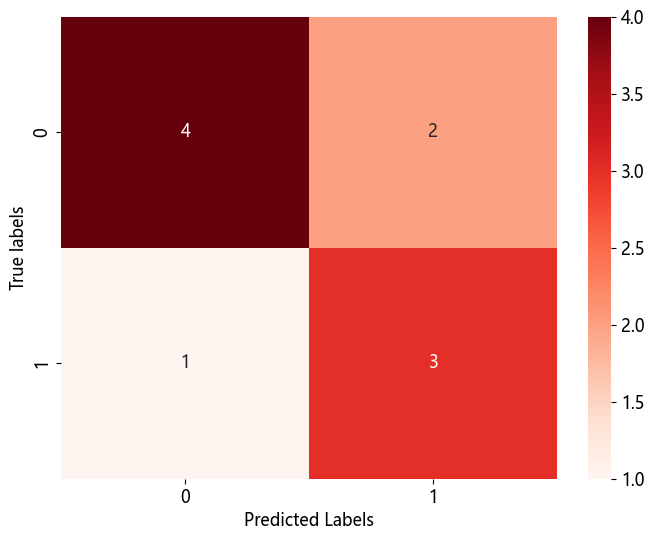

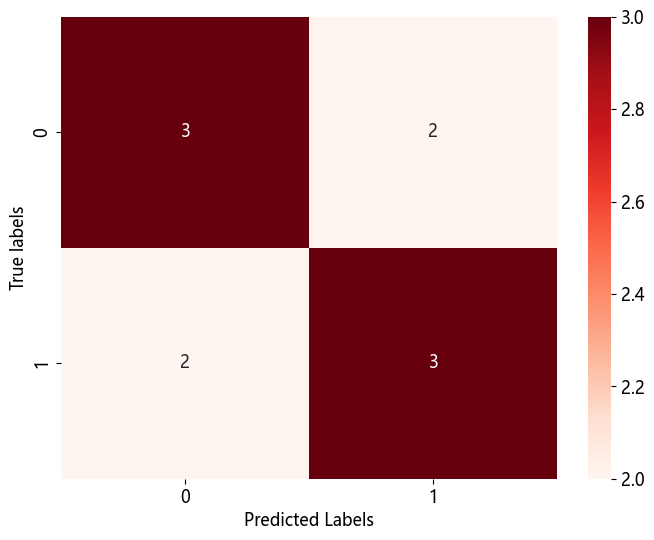

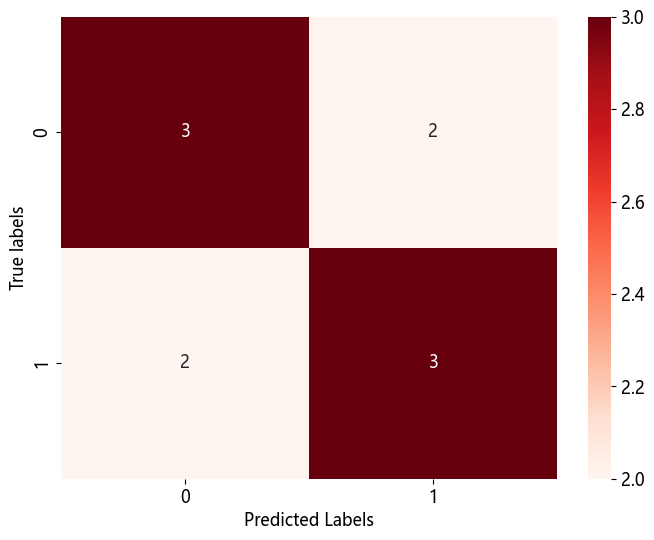

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import pydotplus
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import warnings  
warnings.filterwarnings('ignore')
import joblib
import os 
import shutil
from glob import glob
from openpyxl import load_workbook
from utils import *
plt.rcParams['font.sans-serif']=['Microsoft YaHei']  
plt.rcParams['font.size'] = 12  
plt.rcParams['axes.unicode_minus'] = False

save_model = False
data_excel = 'predict.xlsx'
data_name = 'GDS'  
label_name = 'GDS' # Name of the dataset label
sheet_name = f'{data_name}_data'
data = pd.read_excel(data_excel, sheet_name=sheet_name)
data = data.fillna(0)

size_threshold = 1.5

data_target = pd.DataFrame([1 if x > size_threshold else 0 for x in data[label_name]])  # Divide the original GDS into two categories based on the threshold, where 0 represents smaller values, and 1 represents larger values
print(data_target.value_counts())
print('threshold', size_threshold)
# print(type(data_target))
# print('Number of 0:', data_target.count(0), '\nNumber of 1:', data_target.count(1))
# print(data[label_name])
# print(type(data_target))

feature_names = ['cC','cO','cN','cF','cP','cS','OCr','FCr','FOr','PCr','NCr',
                 'SCr','NFr','POr','NOr','SOr','PFr','SFr','SPr','NSr','FNS/Or',
                 'FP/Or','FNS/FPr']

data_features_part = data[feature_names]
epoch_num = 100
n_splits = 3
# print(data[feature_names].values[:,0])

StrK = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2)
n_split = StrK.get_n_splits(data_features_part, data_target)  # Divide into 3 folds

# Create related folders
main_path = f'{data_name}_classification_predict'
if save_model:
    create_dir(main_path, True)

    for i in range(1000):
        if not os.path.exists(main_path + '/' + main_path + '1'):
            main_path = main_path + '/' + main_path + '1'
            create_dir(main_path, True)
            break
        else:
            if not os.path.exists(main_path + '/' + main_path + str(i)):
                main_path = main_path + '/' + main_path + str(i)
                create_dir(main_path, True)
                break
            else:
                continue
if save_model:
    create_dir(main_path + '/report')
    create_dir(main_path + '/model')
    create_dir(main_path + '/confusion_matrix')
    create_dir(main_path + '/Feature importance ranking of different models')

# Record fold situation
ls1 = ['fold' + str(i) for i in range(n_splits)]

fold_dict = dict(zip(ls1, [0 for i in range(len(ls1))]))

train = True
# Dataset table
excel = main_path + '/predict.xlsx'
if train == True:
    if not os.path.exists(excel) and save_model:
        mycopyfile(data_excel, main_path) # Create a new copy of the dataset table in the folder

    clf = RandomForestClassifier(criterion='gini', n_estimators=30, max_features='log2', max_depth=5, max_samples=None)

    for i, (train_index, test_index) in enumerate(StrK.split(data_features_part, data_target)):
        # pass
        print(f'-------------Fold {i} cross-validation-----------')
        fold_dict['fold' + str(i)] = train_index
        f1_score_ls = []
        x_train = data_features_part.iloc[train_index]
        y_train = data_target.iloc[train_index]

        x_test = data_features_part.iloc[test_index]
        y_test = data_target.iloc[test_index]
        
        for n in range(epoch_num):
            f1_score_sum = 0
            print(f'Training for the {n}th time')
            clf.fit(x_train, y_train)

            test_predict = clf.predict(x_test)
            f1_score = metrics.f1_score(y_test, test_predict)
            
            # recall = metrics.recall_score(y_test, test_predict)

            # print(f'Fold {i} f1_score=', f1_score)
            report = metrics.classification_report(y_test, test_predict)

            plt.figure(figsize=(8, 6))  # The optimal size for plotting a confusion matrix is (8,6) or a similar ratio
            confusion_matrix_result = metrics.confusion_matrix(test_predict, y_test, labels=[0, 1])
            sns.heatmap(confusion_matrix_result, annot=True, cmap='Reds')
            plt.xlabel('Predicted Labels')
            plt.ylabel('True labels')
            if save_model:
                plt.savefig(f'{main_path}/confusion_matrix(temp)/Model prediction confusion matrix {i}.jpg')
            # print('Generated confusion matrix image')
            # plt.show()     
            # Save model file
            if save_model:
                joblib.dump(clf, main_path + '/model(temp)/' + f'model{i}.pkl')
            # print('Saved model file')

            # Print report
            if save_model:
                file = open(main_path + f'/report(temp)/report{i}.txt', 'w')
                file.write(report)

            if len(f1_score_ls) == 0 or f1_score > max(f1_score_ls):
                print(f'Fold {i}, Training for the {n}th time, f1_score mean', f1_score)
                f1_score_ls.append(f1_score)
                if save_model:
                    mycopyfile(main_path + f'/model(temp)/model{i}.pkl', main_path + '/model')
                    mycopyfile(main_path + f'/report(temp)/report{i}.txt', main_path + '/report')
                    mycopyfile(main_path + f'/confusion_matrix(temp)/Model prediction confusion matrix {i}.jpg', main_path + '/confusion_matrix')
                    file = open(main_path + f'/report/report{i}.txt', 'w')
                    print(f'Fold {i}, Training for the {n}th time, report\n', report)
                    file.write(report)
                    file.write('threshold' + str(size_threshold))

            if i == n_splits - 1 and save_model:
                ls = list(fold_dict.values())
                df = pd.DataFrame(ls)
                book = load_workbook(excel)
                with pd.ExcelWriter(excel) as writer:
                    writer.book = book
                    df.to_excel(writer, sheet_name='k-fold')
                    
            if f1_score >= 0.95:
                break

                # df = pd.read_excel(excel, sheet_name='k-fold')
                # print('Training set indices:', list(df))

In [3]:
exit()